In [1]:
println("Hello super people: V2 here!")

#NOTES
#YELLOW = -1, BLUE = 1, EMPTY = 0

Hello super people: V2 here!


In [3]:
using Random, Plots, Statistics, Combinatorics, LaTeXStrings, CSV, DataFrames, StatsBase, LaTeXStrings
using Colors


In [4]:
#define the grid
#schelling used originally 13x13 grid
GRID_SIZE = 13
CELL_COUNT = GRID_SIZE^2
#PP is related to the proportion of GRID_SIZE for each agent type count
PP = 5

#agent population numbers on the grid
YELLOW_COUNT = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
BLUE_COUNT = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
EMPTY_COUNT = CELL_COUNT - YELLOW_COUNT - BLUE_COUNT

#for positions in the grid how many are needed for homogeneity satisfaction
THRESHOLD_SAME = 4
THRESHOLD_EDGE = 3
THRESHOLD_CORNER = 2

#simulation iterations
MM = 100#number of simulations
TT = 30#number of time points in simulation

#for the lattice heatmaps to show the grid cell indices
GRID_STEP = floor( GRID_SIZE / 15 ) + 1

#THE COLOR CHOICES FOR THE AGENTS (-1,0,+1)
COLOR_GRADIENT = ColorGradient([:orange,:white,:blue])

#the maximum value of the spatial residential satisfaction
R_MAX = YELLOW_COUNT + BLUE_COUNT

#sample number for the distributions
NUM_RAND_SAMPLES = 2000

#The total income some for each group of residents
TOTAL_INCOME_GROUP = -1

#sample number for the uniform finance case that is more time consuming
UNIFORM_SAMPLE_NUM = 20

20

In [5]:
#plot index tracker for the order
PLOT_NUM = 0
PLOT_DIR = "FigsV2/"
PLOT_START_STR = "fig"
PLOT_END_STR = ".png"
function newFigNameString()
    global PLOT_NUM
    PLOT_NUM += 1
    return string(PLOT_DIR,PLOT_START_STR,PLOT_NUM,PLOT_END_STR)
end


newFigNameString (generic function with 1 method)

In [6]:
#BOLTZAMANN CONSTANT
K_B = 1.380649*10^-23;

In [7]:
#R ENTROPY / PERMUTATIONS FOR THE SPATIAL ARRANGEMENTS WITHOUT INCOME

#the total number of possible configurations of the grid placements of residents and incomes
CELLS_SPACE_SIZE = multinomial(BigInt(YELLOW_COUNT),BigInt(BLUE_COUNT),BigInt(EMPTY_COUNT));

In [8]:
#S_RI ENTROPY / PERMUTATIONS FOR THE SPATIAL ARRANGEMENTS WITH INCOME
CELLS_SPACE_SIZE_2D = BigInt(-1)
#total number of possible configurations for the 2D grid state dimensions
#2 macrostate variables
function SET_2D_SPATIAL_INCOME_CELL_SPACE(TOTAL_INCOME_GROUP)
    global CELLS_SPACE_SIZE_2D
    spatial = multinomial(BigInt(YELLOW_COUNT),BigInt(BLUE_COUNT),BigInt(EMPTY_COUNT)) 
    incomeYellow = BigInt(YELLOW_COUNT)^(BigInt(TOTAL_INCOME_GROUP))
    incomeBlue = BigInt(BLUE_COUNT)^(BigInt(TOTAL_INCOME_GROUP))
    CELLS_SPACE_SIZE_2D = spatial * incomeYellow * incomeBlue
    
end


SET_2D_SPATIAL_INCOME_CELL_SPACE (generic function with 1 method)

In [9]:
#sample the random intializations and investigate 
function make_random_grid()#random initial allocation heatmap viz
    sample_grid = zeros(GRID_SIZE,GRID_SIZE)
    sample_grid[1:YELLOW_COUNT] .= 1
    sample_grid[YELLOW_COUNT+1:YELLOW_COUNT+BLUE_COUNT] .= -1
    shuffle!(sample_grid)
    return sample_grid
end


make_random_grid (generic function with 1 method)

In [10]:
#return the array of those agents around it, returns arrays like [-1,1,0,1]
function cell_surround_array(grid,row,col)
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!( (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || 
                        (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE) ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end
        end
    end
    return cell_surrounding
end



cell_surround_array (generic function with 1 method)

In [11]:
#Return the value of the binary satisfaction [0,1] for the array neighborhood in the grid
function thresholdFN(cellSurroundArray,cellType,row,col)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end

#same as thresholdFN but does not need to have the cellType passed to it
function is_cell_satisfied(grid,row,col)
    cellSurroundArray = cell_surround_array(grid,row,col)
    #println(cellSurroundArray)
    cellType = grid[row,col]    
    homogeneity = length(findall(cellType .== cellSurroundArray))
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#testing for if a cell would be satisfied if it were placed there
function would_cell_be_satisfied(grid,row,col,cellType)
    cellSurroundArray = cell_surround_array(grid,row,col)    
    #println(cellSurroundArray)
    homogeneity = length(findall(cellType .== cellSurroundArray))    
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 


would_cell_be_satisfied (generic function with 1 method)

In [12]:
#Search for an unsatisfied iteratively in all the cells through a shuffled list
#find all empty cells
#shuffle the list of the empty cells
#see if the cell would_cell_be_satisfied in any of the cells in sequence
#no, move on to the next cell
#if yes, change the original cell position to empty and make the new cell the cell type
#loop till all non-empty cells are tested
#PASS GRID TO RETURN MOVED GRID
function move_cells_for_satisfaction(grid)    
    newGrid = deepcopy(grid)
    nonZeroCells = findall(grid .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)
    satisfiedNonZeroCells = [is_cell_satisfied(newGrid,nzc[1],nzc[2]) for nzc in nonZeroCells2]       
    satisfiedInds = findall(satisfiedNonZeroCells .== 1)
    deleteat!(nonZeroCells2,satisfiedInds)       
    for nzc in nonZeroCells2        
        isCellSatisfied = is_cell_satisfied(newGrid,nzc[1],nzc[2])        
        if(isCellSatisfied != 1)          
            emptyCells = findall(newGrid .== 0)
            emptyCells2 = shuffle(emptyCells)
            #find an empty cell nzc could move to
            moved = false
            for ec in emptyCells2                
                wouldCellBeSatisfied = would_cell_be_satisfied(newGrid,ec[1],ec[2],newGrid[nzc[1],nzc[2]] )
                if(wouldCellBeSatisfied == 1)                      
                    newGrid[ec[1],ec[2]] = newGrid[nzc[1],nzc[2]]
                    newGrid[nzc[1],nzc[2]] = 0  
                    #no longer try to move it
                    moved = true
                    break
                end                
            end              
        end       
    end    
    return newGrid
end

move_cells_for_satisfaction (generic function with 1 method)

In [13]:
#wealth no dynamics just moves the cells around randomly and continuously
#at each iteration check the financial cell deviation, and at each move ...
function move_cells_for_wealth_NoDynamics(gridOrig)    
    grid = deepcopy(gridOrig)     
    nonZeroCells = findall(grid[:,:,1] .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)     
    for nzc in nonZeroCells2 
        emptyCells = findall(grid[:,:,1] .== 0)
        emptyCells2 = shuffle(emptyCells)
        ec = emptyCells2[1]
        grid[ec[1],ec[2],1] = grid[nzc[1],nzc[2],1]
        grid[nzc[1],nzc[2],1] = 0   
           
        grid[ec[1],ec[2],2] = grid[nzc[1],nzc[2],2]
        grid[nzc[1],nzc[2],2] = 0 
        #radiate the finance randomly on the surroundings
        #grid = cell_surround_radiate_financialRandomUniform!(grid,ec[1],ec[2])                    
    end              
    return grid
end

move_cells_for_wealth_NoDynamics (generic function with 1 method)

In [14]:
#take the dataframe from the wealth data and return an array of wealth for each percentage index 
#simple data mongering
#THE MEAN OF THE BRACKET IS TAKEN!!! 
function df2wealthArray(dfWealth)
    meansBracket = []
    for i in 1:size(dfWealth)[1]        
        inds = findall(isequal(' '),dfWealth[i,1])        
        money1 = dfWealth[i,1][1:inds[1]-1]
        money2 = dfWealth[i,1][inds[2]+1:end]        
        if(i == size(dfWealth)[1])
            money2 = money1
        end        
        money1 = replace(money1,","=>"")
        money2 = replace(money2,","=>"")
        money1 = parse(Float64,money1)
        money2 = parse(Float64,money2)
        append!(meansBracket,mean([money1,money2]))        
    end
    return meansBracket
end

df2wealthArray (generic function with 1 method)

In [15]:
#SAMPLE INCOMES FROM POPULATION BRACKETS
#now sample according to the population a wealth bracket to produce a wealth number from the data
function wealthBracketSample()
    brackets = findall(isequal(true), rand()*100 .<= percsAndWealth[:,1] )
    maxBracketInd = maximum(brackets)
    #println(maxBracketInd)
    return percsAndWealth[maxBracketInd,2]
end

wealthBracketSample (generic function with 1 method)

In [16]:
#we need to allocate wealth according to the word tuple probability as a 'process'
#the process will individually allocate a single dollar to a resident till the total is accumulated
#returns incomes for all residents, NEEDS TOTAL_INCOME_GROUP to be allocated first  
function randUniformWealthBracketSample()
    incomes = zeros(YELLOW_COUNT)
    #println(TOTAL_INCOME_GROUP)
    for dollar in 1:TOTAL_INCOME_GROUP
        indDrop = rand(1:YELLOW_COUNT)
        incomes[indDrop] += 1      
    end
    return incomes
end

randUniformWealthBracketSample (generic function with 1 method)

In [17]:
#Makes a finance income grid that has the resident types uniformly placed and 
#the income uniformly drawn from the total
function make_uniform_sampled_finance_grid()    
    empty_grid = zeros(GRID_SIZE,GRID_SIZE,2)
    shiftsTmp = GRID_SIZE^2;
    
    #set the agent occupations in the lattice
    empty_grid[1:YELLOW_COUNT] .= 1
    empty_grid[YELLOW_COUNT+1:YELLOW_COUNT+BLUE_COUNT] .= -1
    #set the financial values for the agents
    empty_grid[1+shiftsTmp:YELLOW_COUNT+shiftsTmp] .= randUniformWealthBracketSample()
    empty_grid[YELLOW_COUNT+1+shiftsTmp:YELLOW_COUNT+BLUE_COUNT+shiftsTmp] .= randUniformWealthBracketSample()
    
    indShuffle = shuffle(1:GRID_SIZE^2)
    indShuffleShift = indShuffle .+ GRID_SIZE^2
    empty_grid[1:GRID_SIZE^2] = empty_grid[indShuffle]
    empty_grid[1 .+ GRID_SIZE^2 : GRID_SIZE^2 .+ GRID_SIZE^2 ] = empty_grid[indShuffleShift]
    return empty_grid
end

make_uniform_sampled_finance_grid (generic function with 1 method)

In [18]:
#sample incomes according to real data distribution and spatial arrangements of residents
function make_random_finance_grid()    
    empty_grid = zeros(GRID_SIZE,GRID_SIZE,2)
    shiftsTmp = GRID_SIZE^2;
    
    wealthSamplesYellow = getResidentIncomeSamples(TOTAL_INCOME_GROUP)
    wealthSamplesBlue = getResidentIncomeSamples(TOTAL_INCOME_GROUP)    
        
    #set the agent occupations in the lattice
    empty_grid[1:YELLOW_COUNT] .= 1
    empty_grid[YELLOW_COUNT+1:YELLOW_COUNT+BLUE_COUNT] .= -1
    #set the financial values for the agents
    empty_grid[1+shiftsTmp:YELLOW_COUNT+shiftsTmp] .= wealthSamplesYellow
    empty_grid[YELLOW_COUNT+1+shiftsTmp:YELLOW_COUNT+BLUE_COUNT+shiftsTmp] .= wealthSamplesBlue
    
    indShuffle = shuffle(1:GRID_SIZE^2)
    indShuffleShift = indShuffle .+ GRID_SIZE^2
    empty_grid[1:GRID_SIZE^2] = empty_grid[indShuffle]
    empty_grid[1 .+ GRID_SIZE^2 : GRID_SIZE^2 .+ GRID_SIZE^2 ] = empty_grid[indShuffleShift]
    
    return empty_grid
end

make_random_finance_grid (generic function with 1 method)

In [19]:
#sample incomes for each group of residents
#normalize according to the mean income so that the total sum is consistent
#if slightly off, randomly padd a resident with that diff to stabilize
function getResidentIncomeSamples(totalIncomeGroup)
    wealthSamplesYellow = [wealthBracketSample() for i in 1:YELLOW_COUNT]
    wealthSamplesYellow = wealthSamplesYellow .* ( sum(totalIncomeGroup) / sum(wealthSamplesYellow) )
    wealthSamplesYellow = round.(wealthSamplesYellow)
    diffYellowTotal = (totalIncomeGroup) - sum(wealthSamplesYellow)
    #padd a random resident
    randIndex = rand(1:length(wealthSamplesYellow))
    wealthSamplesYellow[randIndex] += diffYellowTotal
    diffYellowTotal = (totalIncomeGroup) - sum(wealthSamplesYellow)

    return wealthSamplesYellow
end

getResidentIncomeSamples (generic function with 1 method)

In [167]:
#get the financial surroundings
#pass the grid and provide the cell to get the surrounding finance or type array
function cell_surround_arrayTMP_financial(gridFull,row,col,third)
    grid = gridFull[:,:,third]
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || 
                        (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end
        end
    end
    
    return cell_surrounding
end

function cell_surround_array_grid(gridFull,row,col,third)
    grid = gridFull[:,:,third]
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || 
                        (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end
        end
    end
    return cell_surrounding
end

cell_surround_array_grid (generic function with 1 method)

In [21]:
#the equivalent of 'thresholdFN' that examines a locality to see financial deviation
#give the full grid, the surrounding array for the finance and return the MAD in this case
function financial_cell_deviation(gridFull,row,col)
    cellFinance = gridFull[row,col,2]
    cellSurroundArray = cell_surround_arrayTMP_financial(gridFull,row,col,2)
    if(gridFull[row,col,1] == 0)
        return 0
    end       
    
    deviation = mad(cellSurroundArray,center=cellFinance,normalize=false)#BUGGY???
    #deviation = median(abs.(cellSurroundArray .- cellFinance))

    return deviation
end

financial_cell_deviation (generic function with 1 method)

In [22]:
#find the total deviation for the cell incomes using the MAD
#find all the financial deviations accross all the cells and aggregate
function financial_grid_deviation(gridFull)
    cell_deviation = []
    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE            
            moneyDeviation = financial_cell_deviation(gridFull,row,col)
            append!(cell_deviation,moneyDeviation)            
        end
    end    
    return sum(cell_deviation)        
end

financial_grid_deviation (generic function with 1 method)

In [23]:
#return the entropy value for the spatial arrangement that has R as the macrostate
function S_entropy_values_from_R(R)
    return K_B * log(sampleOmegaR[R])       
end

S_entropy_values_from_R (generic function with 1 method)

In [24]:
#ONLY SPATIAL GRID INPUT, #total sum from zero to max
#macrostate spatial (what is the total satisfaction of the residents in the grid)
function grid_satisfaction(grid)
    cell_satisfaction = []
    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE            
            localAr = cell_surround_array(grid,row,col)  #R2 = R_grid(start_grid)
            tmpBinary = thresholdFN(localAr,grid[row,col],row,col)
            append!(cell_satisfaction,tmpBinary)
        end
    end
    return sum(cell_satisfaction)
end

grid_satisfaction (generic function with 1 method)

In [25]:
#the entropy y ticks need manual setting and this function returns the max and min labels formatted
function entropyYlabels(entropyVals)
    minStr = string(minimum(entropyVals))[1:4] 
    tmp = findfirst( isequal('e') , string(minimum(entropyVals)) )
    tmp2 = string(minimum(entropyVals))[tmp:end]
    labelMin = string(minStr,tmp2)
    maxStr = string(maximum(entropyVals))[1:4] 
    tmp = findfirst( isequal('e') , string(maximum(entropyVals)) )
    tmp2 = string(maximum(entropyVals))[tmp:end]
    labelMax = string(maxStr,tmp2)
    return [labelMin,labelMax]
end


entropyYlabels (generic function with 1 method)

In [26]:
#function for the heatmaps of the agents spatially arranged
function gridHeatMap(gridHM,titleStr,axisShow=false)
    if(axisShow == true)
        h = heatmap(gridHM,title=titleStr,
            showaxis=true,xticks=1:GRID_STEP:GRID_SIZE,yticks=1:GRID_STEP:GRID_SIZE,
            yaxis=:flip,aspect_ratio=1.0,
            framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,    
            c=COLOR_GRADIENT)
        return h 
    elseif(axisShow == false)
        h = heatmap(gridHM,title=titleStr,
            showaxis=true,xticks=false,yticks=false,
            yaxis=:flip,aspect_ratio=1.0,
            framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,    
            c=COLOR_GRADIENT)
        return h 
    end
end

gridHeatMap (generic function with 2 methods)

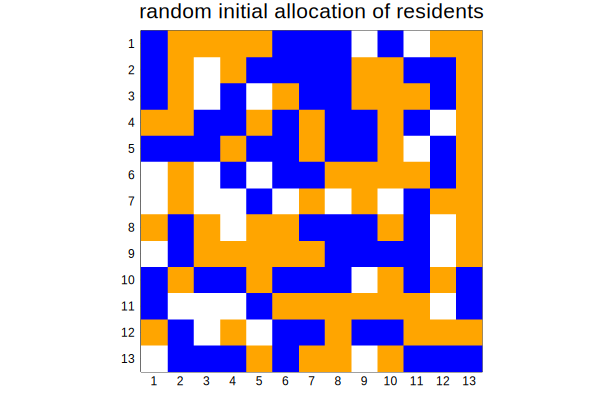

In [27]:
#investigate the random allocation
start_grid = make_random_grid()
title="random initial allocation of residents"
h = gridHeatMap(start_grid,title,true)
display(h)
savefig(h,newFigNameString())

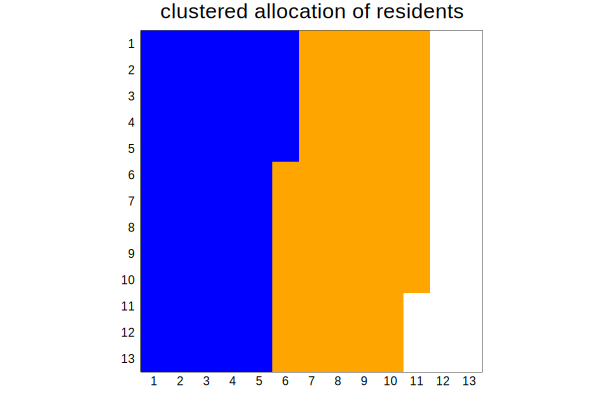

In [28]:
#look at the organized residents on the grid
set_grid = zeros(GRID_SIZE,GRID_SIZE)
set_grid[1:YELLOW_COUNT] .= 1
set_grid[YELLOW_COUNT+1:YELLOW_COUNT+BLUE_COUNT] .= -1

title="clustered allocation of residents"
h = gridHeatMap(set_grid,title,true)
display(h)
savefig(h,newFigNameString())

In [29]:
#after making these FNs set the max satisfaction value
R_MAX = grid_satisfaction(set_grid)
println("set grid satisfaction value MAX = ",R_MAX)


set grid satisfaction value MAX = 140


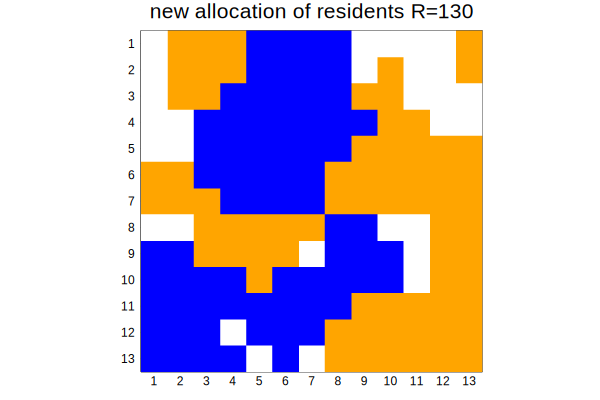

In [30]:
#test the single step of the grid movements 
newGrid = move_cells_for_satisfaction(start_grid)

satisfiedOneGrid = grid_satisfaction(newGrid)
title="new allocation of residents R=$(satisfiedOneGrid)"
h = gridHeatMap(newGrid,title,true)
display(h)
savefig(h,newFigNameString())


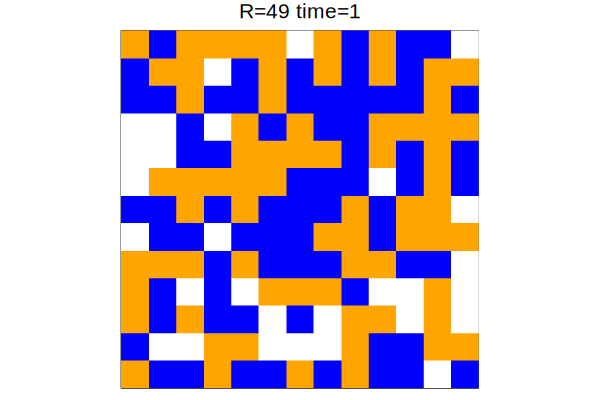

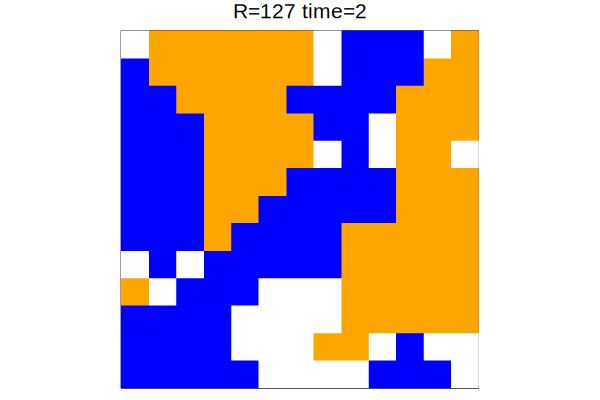

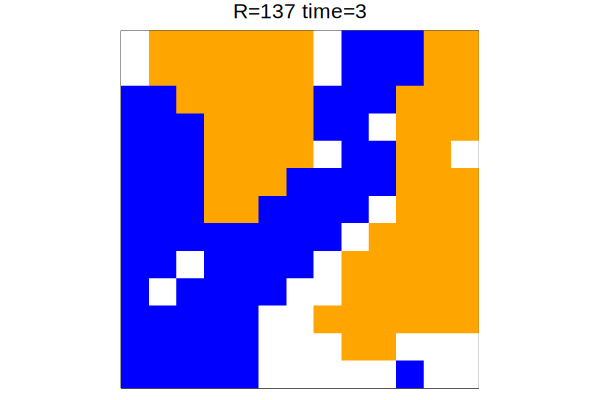

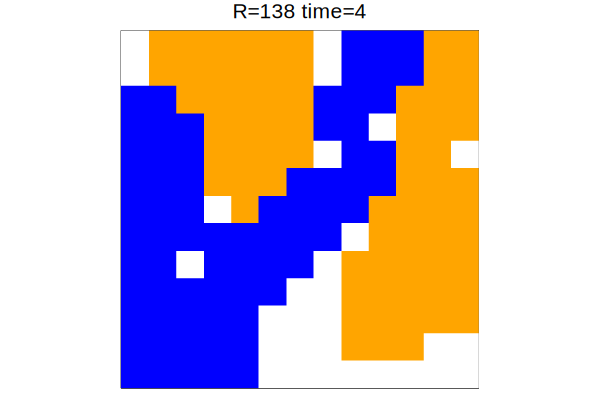

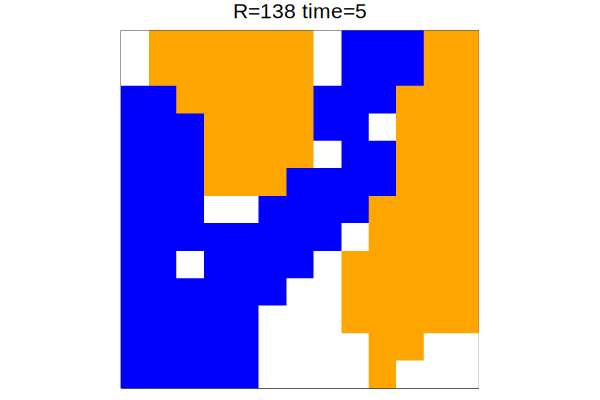

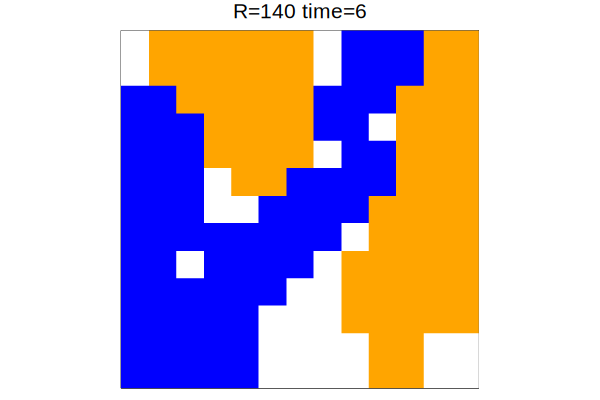

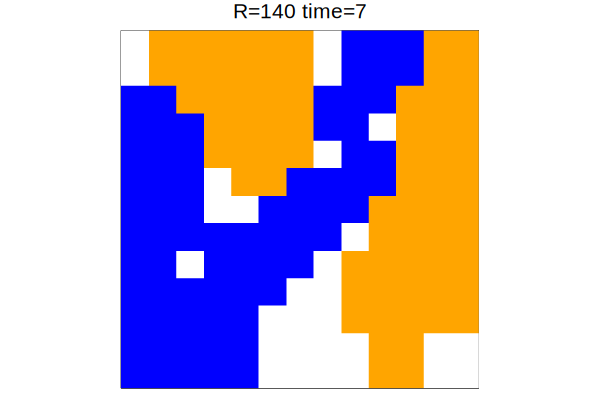

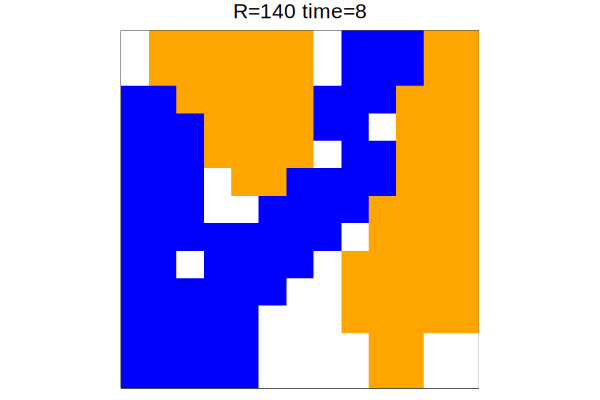

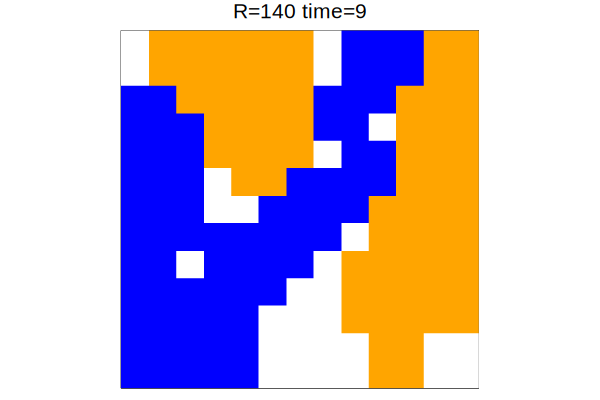

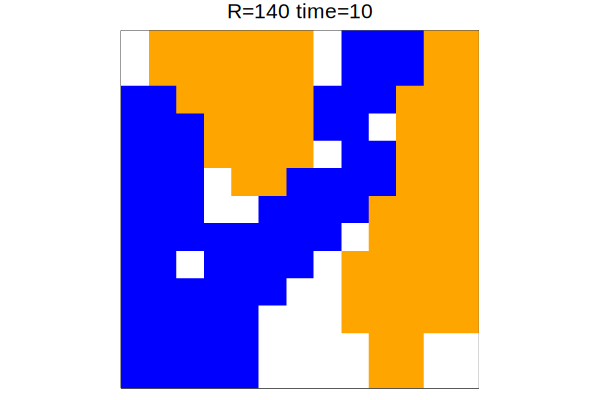

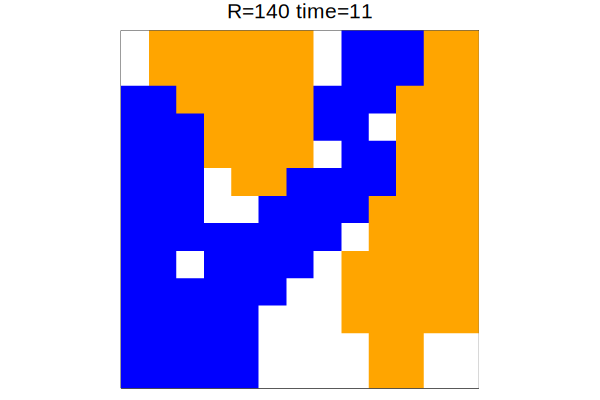

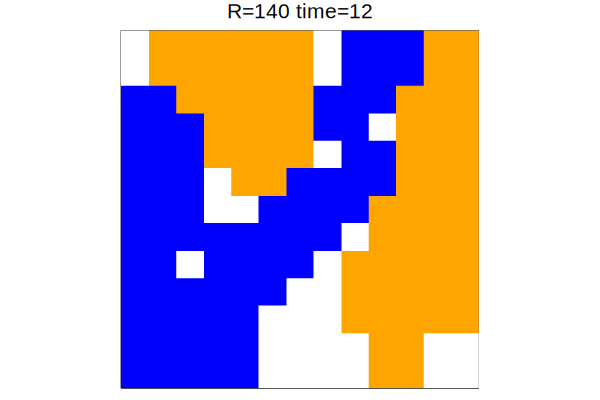

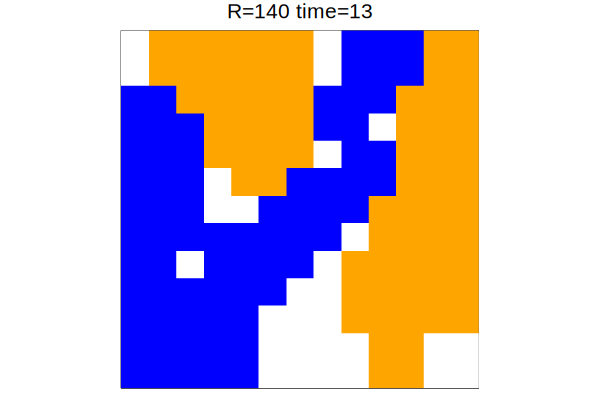

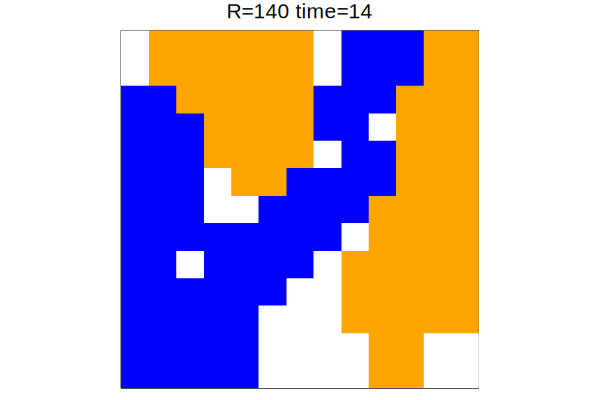

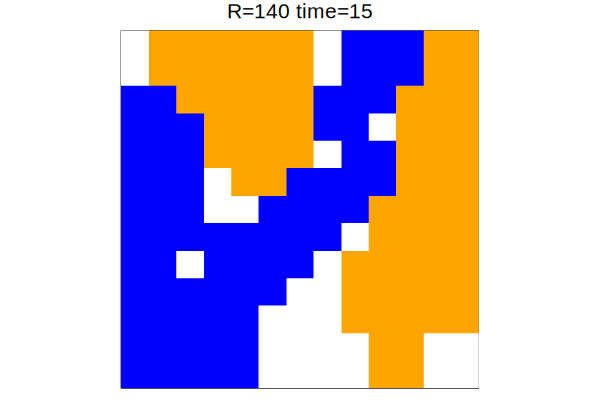

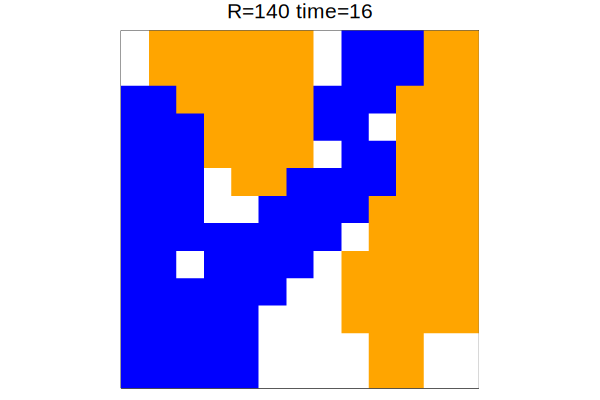

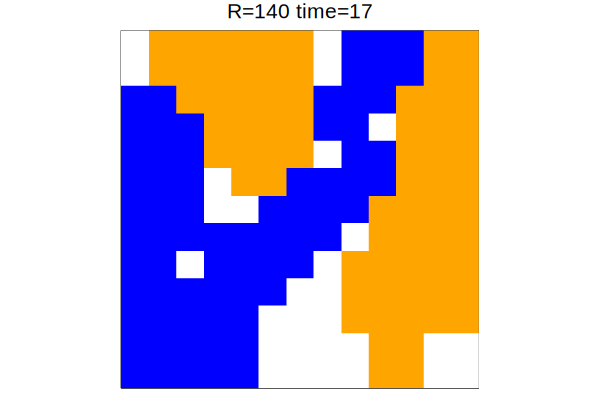

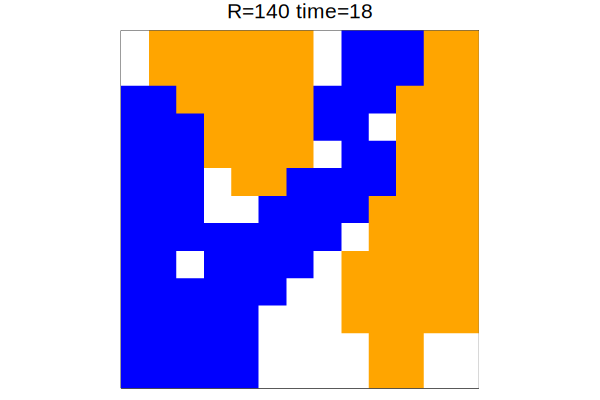

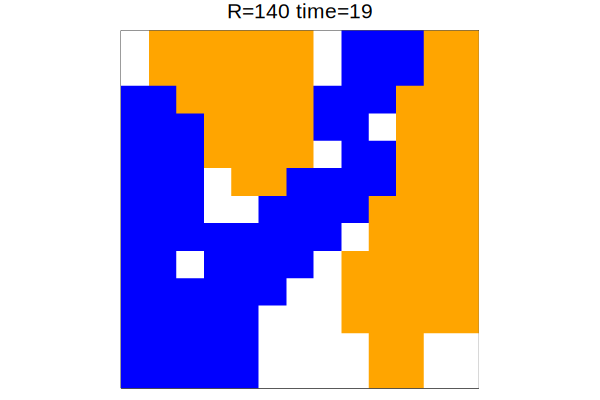

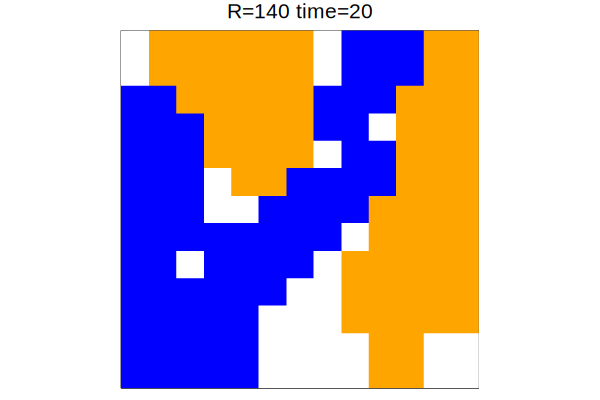

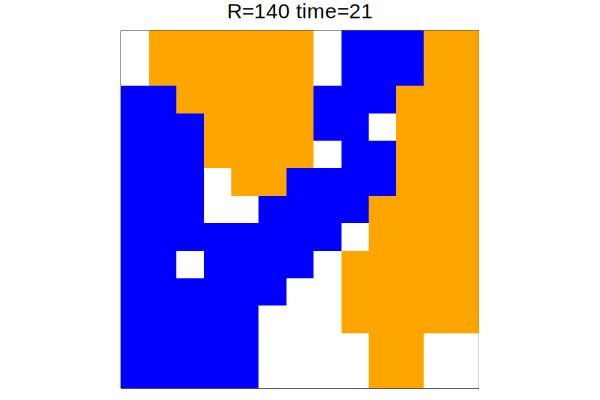

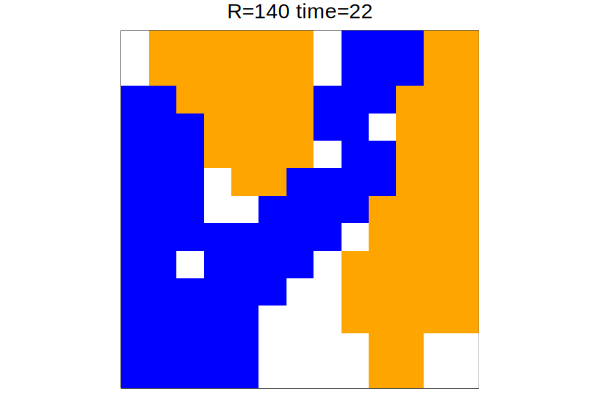

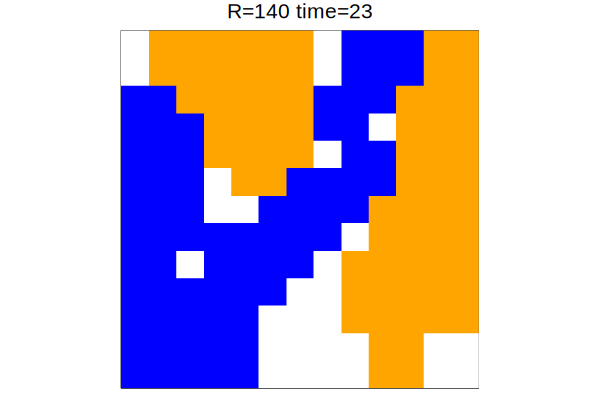

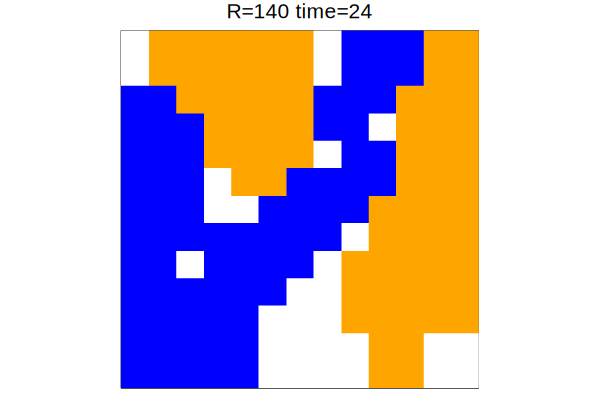

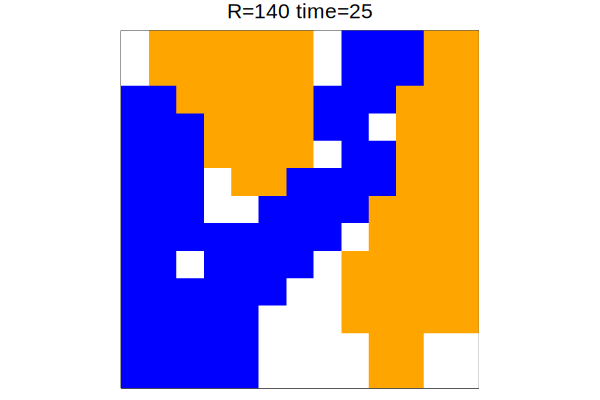

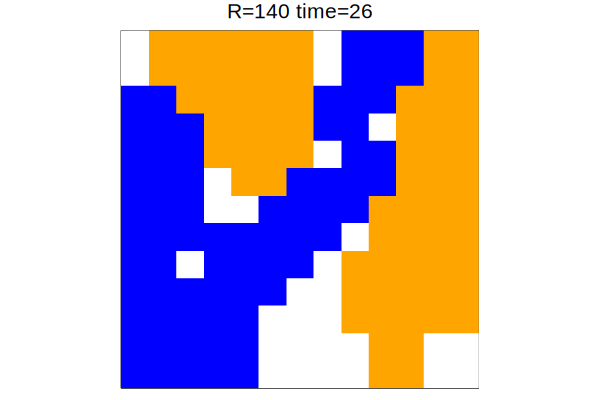

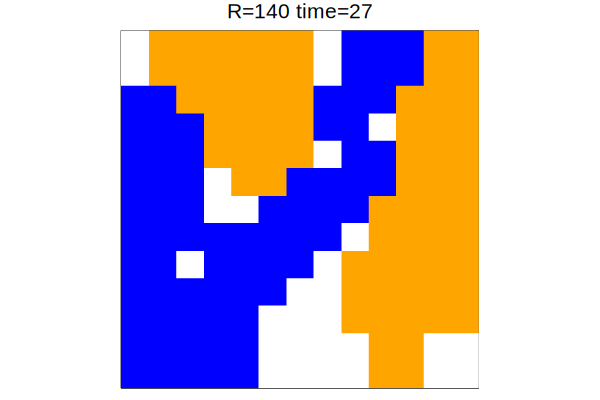

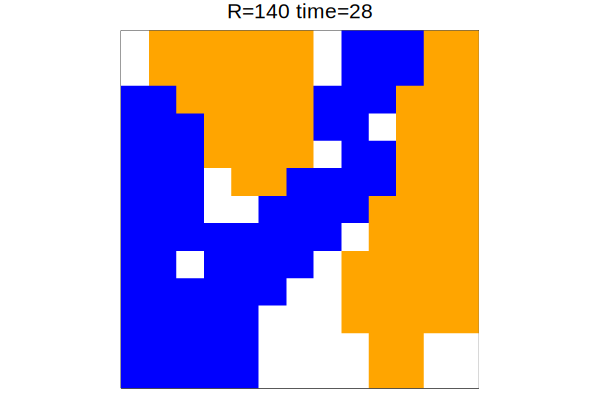

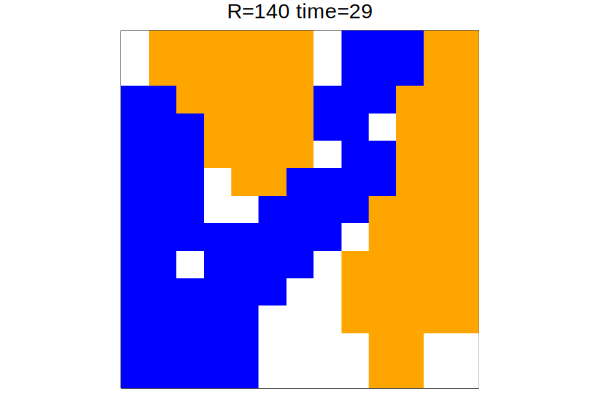

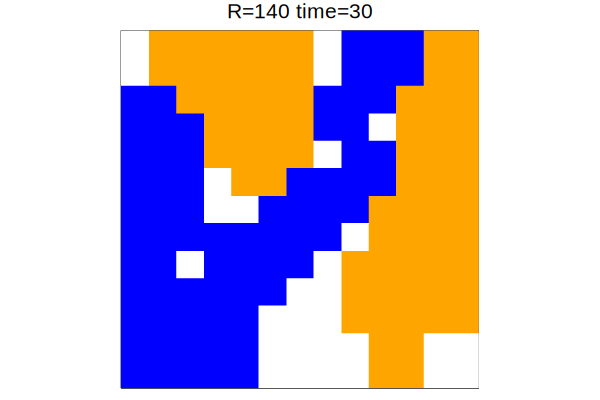

In [31]:
#show the steps of the Schelling Dynamics on the pure spatial
gridDict = Dict()#gets used in later cells
gridDict[1] = make_random_grid()

for tt in 2:TT
gridDict[tt] = move_cells_for_satisfaction(gridDict[tt-1])
end
for tt in 1:TT
    R = grid_satisfaction(gridDict[tt])    
    title="R=$(R) time=$(tt)"
    h = gridHeatMap(gridDict[tt],title,false)
    display(h)    
    savefig(h,"FigsV2/simulationSnapShots1/time$(tt).png")
end

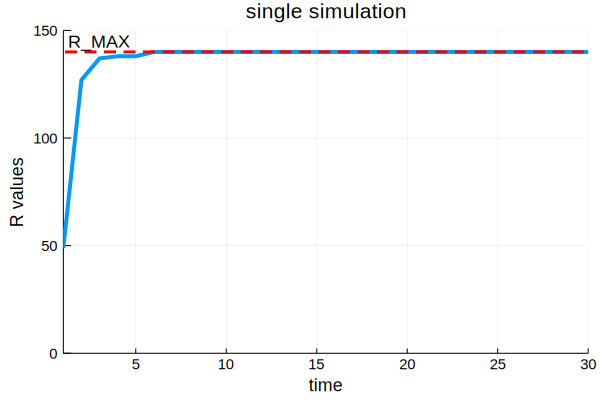

In [32]:
#let's look at this trajectory without the spatial
traceR = Int[]
for tt in 1:TT    
    append!(traceR,grid_satisfaction(gridDict[tt]))    
end
anns = [(3, 145, text("R_MAX",12,0.1pi))]
plt = plot(traceR,ylim=(0,R_MAX+10),xlim=(1,TT),leg=false,linewidth=4,
    title="single simulation",xlabel="time",ylabel="R values",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
hline!([R_MAX],line=(3,:dash),leg=false,color=:red,anns=anns)
display(plt)
savefig(plt,newFigNameString())


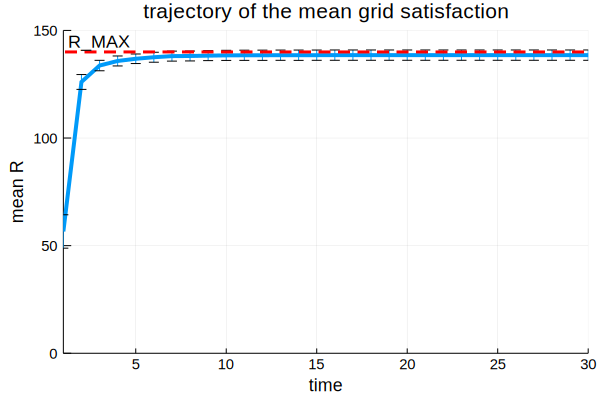

In [33]:
#perform multiple simulations of Schelling and get the mean and std of the R values
simulationRvals = zeros(TT,MM)
for mm in 1:MM
    newGrid = make_random_grid()
    traceR = []
    append!(traceR,grid_satisfaction(newGrid))#initial time zero point
    for tt in 2:TT
        newGrid = move_cells_for_satisfaction(newGrid)
        append!(traceR,grid_satisfaction(newGrid))
    end
    simulationRvals[:,mm] = traceR[:]

end
    
anns = [(3, 145, text("R_MAX",12,0.1pi))]
plt = plot(mean(simulationRvals,dims=2),xlabel="time",ylabel="mean R",
    yerr=std(simulationRvals,dims=2),linewidth=4,ylim=(0,R_MAX+10),xlim=(1,TT),
    title="trajectory of the mean grid satisfaction",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
hline!([R_MAX],line=(3,:dash),leg=false,color=:red,anns=anns)
display(plt)
savefig(plt,newFigNameString())


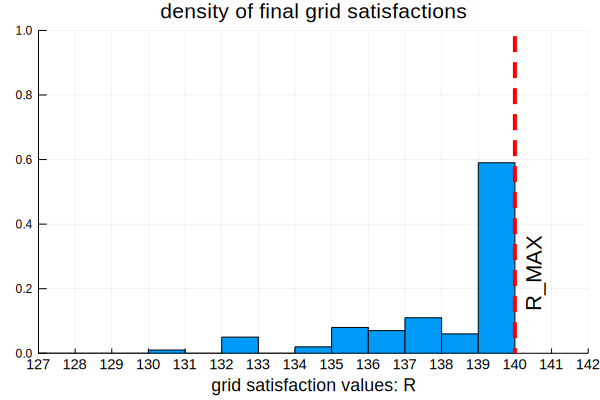

In [34]:
#get the histogram of the final values

anns = [(R_MAX+0.5, 0.25, text("R_MAX",15,28.5pi))]

pltHist = histogram(simulationRvals[end,:] .- 1,ylim=(0,1.0),
    xlim=(minimum(simulationRvals[end,:]),R_MAX+2),
    xticks = (minimum(simulationRvals[end,:]):R_MAX+2),
    normalize=:probability,title="density of final grid satisfactions",
    xlabel="grid satisfaction values: R",leg=false,
    xtickfont=10,titlefont=14,guidefont=12)
vline!([R_MAX],line=(4,:dash),leg=false,color=:red,anns=anns)
display(pltHist)
savefig(pltHist,newFigNameString())


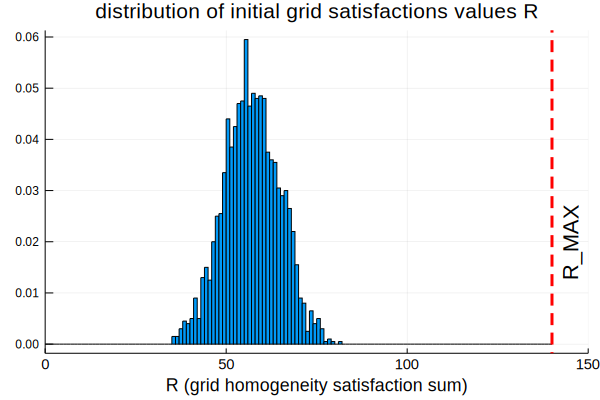

In [35]:
#plot the histogram for the initial grid satisfactions distribution
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:NUM_RAND_SAMPLES]

anns = [(145, 0.02 , text("R_MAX",15,28.5pi))]
pltHist = histogram(randomSatisfactions,normalize=:probability,bins=0:1:R_MAX,
    xlim=(0,R_MAX+10),title="distribution of initial grid satisfactions values R",
    xlabel="R (grid homogeneity satisfaction sum)",xtickfont=10,titlefont=14,guidefont=12)
vline!([R_MAX],line=(3,:dash),leg=false,color=:red,anns=anns)
display(pltHist)
savefig(pltHist,newFigNameString())

In [36]:
#sample random microstates
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:NUM_RAND_SAMPLES]
#set the macrostate count array to those random allocations and count for each R value and index
sampleCountsR = [length(findall(randomSatisfactions .== R)) for R in 1:R_MAX]
#can't have zero occurrences so pad the zeros with non-zero account 1
replace!(sampleCountsR,0=>1)

#get the sample probabilities for the R values from initializations via normalization
sampleProbR = sampleCountsR ./ sum(sampleCountsR);

In [37]:
#ENTROPY calculation for the R values; so that the trace of the R values corresponds to 
#permutation, microstate, uncertainty

#!!!! R index for the number (distribution) of the R to number of microstates
sampleOmegaR = sampleProbR .* CELLS_SPACE_SIZE;

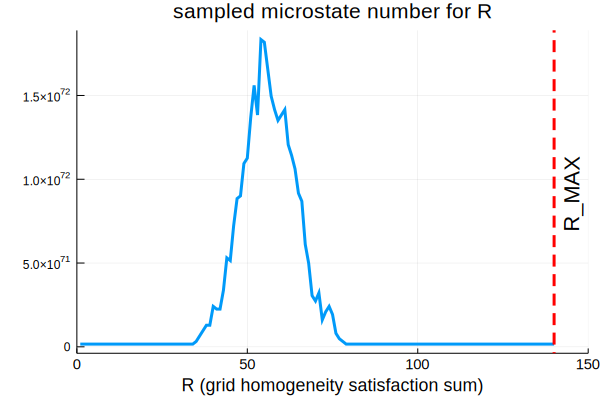

In [38]:
#plot the number of microstates for each macrostate value R
anns = [(145, maximum(sampleOmegaR) / 2, text("R_MAX",15,28.5pi))]

plt = plot(1:R_MAX,sampleOmegaR,xlim=(0,R_MAX+10),
    linewidth=3,title="sampled microstate number for R",
    xlabel="R (grid homogeneity satisfaction sum)",
    xtickfont=10,titlefont=14,guidefont=12)
vline!([R_MAX],line=(3,:dash),leg=false,color=:red,anns=anns)
display(plt)
savefig(plt,newFigNameString())

In [39]:
#transform the microstate count to 'ENTROPY'
entropyVals = [S_entropy_values_from_R(R) for R in 1:R_MAX];


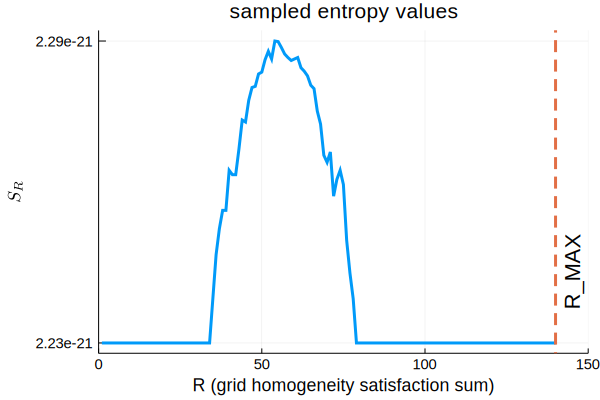

In [40]:
#plot the entropy values for the macrostate values 
eLabels = entropyYlabels(entropyVals)

anns = [(145, (1 + 7*10^-3)*(minimum(entropyVals)) , text("R_MAX",15,28.5pi))]

plt = plot(1:R_MAX,entropyVals,
    yticks=([minimum(entropyVals),maximum(entropyVals)],[eLabels[1],eLabels[2]]),
    xlim=(0,R_MAX+10),ylim=(minimum(entropyVals)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyVals)),
    linewidth=3,title=string("sampled entropy values "),
    xlabel="R (grid homogeneity satisfaction sum)",ylabel=L"S_R",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
vline!([R_MAX],line=(3,:dash),leg=false,anns=anns)
display(plt)
savefig(plt,newFigNameString())

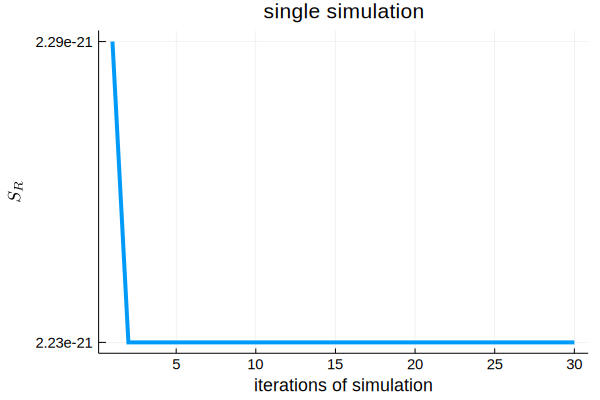

In [41]:
#Single simulation and produce the R and S_R (entropy trace)
newGrid = make_random_grid()
traceR = []
traceS = []
Rtmp = grid_satisfaction(newGrid)
append!(traceR,Rtmp)
append!(traceS,S_entropy_values_from_R(Rtmp))
for tt in 2:TT
    newGrid = move_cells_for_satisfaction(newGrid)
    Rtmp = grid_satisfaction(newGrid)
    append!(traceR,Rtmp)
    append!(traceS,S_entropy_values_from_R(Rtmp))
end

eLabels = entropyYlabels(traceS)

plt = plot(traceS,yticks=([minimum(traceS),maximum(traceS)],[eLabels[1],eLabels[2]]),
    ylims=(minimum(traceS)*(1-(10^-3)),(1 + 10^-3)*maximum(traceS)),
    linewidth=4,title="single simulation",
    xlabel="iterations of simulation",leg=false,ylabel=L"S_R",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
display(plt)
savefig(plt,newFigNameString())

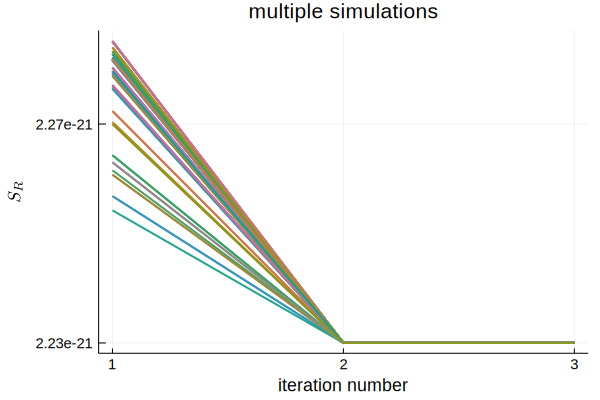

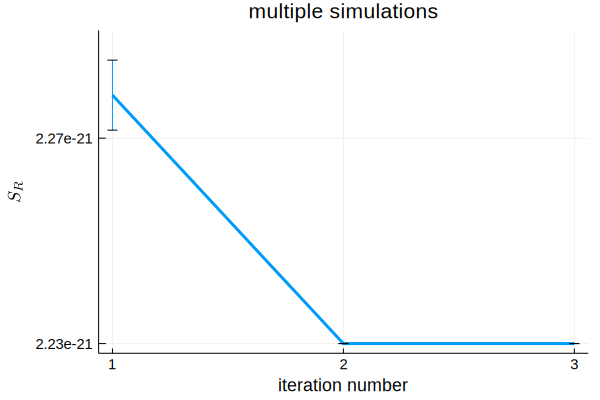

UndefVarError: UndefVarError: labelMin not defined

In [42]:
#Now simulate a series of schellings traces and plot the set of traces
simulationSvals = zeros(TT,MM)
for mm in 1:MM
    traceR = Int[]
    traceS = Int[]
    newGrid = make_random_grid()
    traceR = []
    traceS = []
    Rtmp = grid_satisfaction(newGrid)
    append!(traceR,Rtmp)
    append!(traceS,S_entropy_values_from_R(Rtmp))
    for tt in 2:TT
        newGrid = move_cells_for_satisfaction(newGrid)
        Rtmp = grid_satisfaction(newGrid)
        append!(traceR,Rtmp)
        append!(traceS,S_entropy_values_from_R(Rtmp))
    end
    simulationSvals[:,mm] = traceS[:]
end

eLabels = entropyYlabels(traceS)

plt = plot(simulationSvals[1:3,1:end],
    yticks=([minimum(traceS),maximum(traceS)],[eLabels[1],eLabels[2]]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 10^-3)*maximum(simulationSvals)),
    xticks=1:3, linewidth=2,xlabel="iteration number",
    title="multiple simulations",
    leg=false,ylabel=L"S_R",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
display(plt)
savefig(plt,newFigNameString())

plt = plot(mean(simulationSvals,dims=2)[1:3],
    yerr=std(simulationSvals,dims=2)[1:3],
    yticks=([minimum(traceS),maximum(traceS)],[eLabels[1],eLabels[2]]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 3*10^-3)*maximum(simulationSvals)),
    xticks=1:3,linewidth=3,xlabel="iteration number",ylabel=L"S_R",
    title="multiple simulations",#"S_R for multiple simulations",
    leg=false,
    xtickfont=10,titlefont=14,ytickfont=10,guidefont=12)
display(plt)
savefig(plt,newFigNameString())

plt = plot(mean(simulationSvals,dims=2)[1:3],
    ribbon=std(simulationSvals,dims=2)[1:3],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 3*10^-3)*maximum(simulationSvals)),
    xticks=1:3,linewidth=3,xlabel="iteration number",ylabel=L"S_R",
    title="multiple simulations",#
    leg=false,xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
display(plt)
savefig(plt,newFigNameString())


In [43]:
##################
#FINANCE PART NOW!
##################

#DATA
#wealth distribution data taken from: https://raw.githubusercontent.com/jkeesh/which-percent/master/data.csv
# It is based on data from the US census as well as the Social Security Administration

In [44]:
#wealth distribution data taken from: https://raw.githubusercontent.com/jkeesh/which-percent/master/data.csv
# It is based on data from the US census as well as the Social Security Administration
csvWealth = CSV.File("wealthDistribution.csv",header=false)
dfWealth = DataFrame(csvWealth);


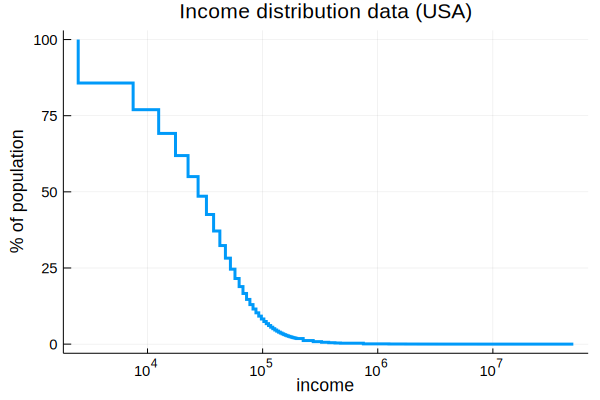

In [45]:
#Create an array from the datafram for the wealth that is 2 column for percentage of wealth bracket
#THE MEAN OF EACH BRACKET IS TAKEN!!! THERE IS A RANGE FOR EACH BUT WE USE A SINGLE VALUE
percs = dfWealth[:,4] #percentages of the population for that wealth or more
percs =[percs[i][1:end-1] for i in 1:length(percs)] 
percs = [ parse(Float64,percs[i]) for i in 1:length(percs)]

wealthBrackets = df2wealthArray(dfWealth)
#first col is the percentage of the population #second is the wealth of the income for that percentage
percsAndWealth = hcat(percs,wealthBrackets) 

plt = plot(percsAndWealth[:,2],percsAndWealth[:,1],leg=false,line = :steppre,
    linewidth=3,xlabel="income",
    title="Income distribution data (USA)",ytickfont=10,ylabel="% of population",
    xtickfont=10,titlefont=14,guidefont=12)
xaxis!(:log10)
display(plt)
savefig(plt,newFigNameString())

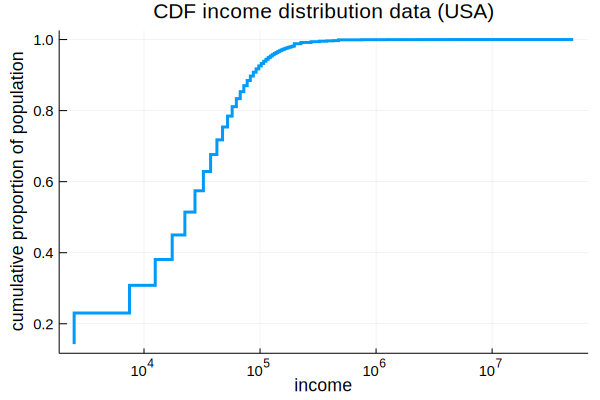

In [46]:
#make a CDF of the income
bracketPercs = [percsAndWealth[x,1] - percsAndWealth[x+1,1] for x in 1:(size(percsAndWealth)[1]-1)]
append!(bracketPercs,percsAndWealth[end,1])
cumsumPerc = cumsum(bracketPercs)
cumsumPerc = cumsumPerc ./ 100
percsAndWealthCumSumProb = hcat(cumsumPerc,percsAndWealth[:,2])

plt = plot(percsAndWealthCumSumProb[:,2],percsAndWealthCumSumProb[:,1],leg=false,line = :steppre,
    linewidth=3,xlabel="income",
    title="CDF income distribution data (USA)",ytickfont=10,ylabel="cumulative proportion of population",
    xtickfont=10,titlefont=14,guidefont=12)
xaxis!(:log10)
display(plt)
savefig(plt,newFigNameString())

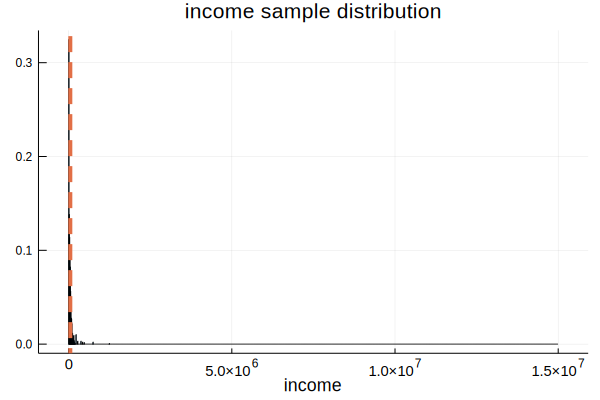

51744.0
3.62208e6
1.4999999995e7


In [47]:
#MEAN INCOME
#we need the mean income for the base expected money per resident
wealthSamples = [wealthBracketSample() for i in 1:NUM_RAND_SAMPLES]
meanIncome = round(mean(wealthSamples)) #MEAN INCOME For each group !!!
println(meanIncome)
TOTAL_INCOME_GROUP = meanIncome * YELLOW_COUNT #regardless of the distribution
println(TOTAL_INCOME_GROUP)
#println("meanIncome=$(meanIncome),"," totalIncomeGroup=$(totalIncomeGroup)")

hist = histogram(wealthSamples,normalize=:probability,
    title="income sample distribution",xlabel="income",leg=false,
    bins=minimum(wealthSamples):10000:maximum(wealthSamples),
    xtickfont=10,titlefont=14,guidefont=12)
vline!([mean(wealthSamples)],line=(4,:dash),leg=false)
display(hist)
savefig(hist,newFigNameString())
println(maximum(wealthSamples))

In [48]:
println(TOTAL_INCOME_GROUP)
println(TOTAL_INCOME_GROUP*2)

3.62208e6
7.24416e6


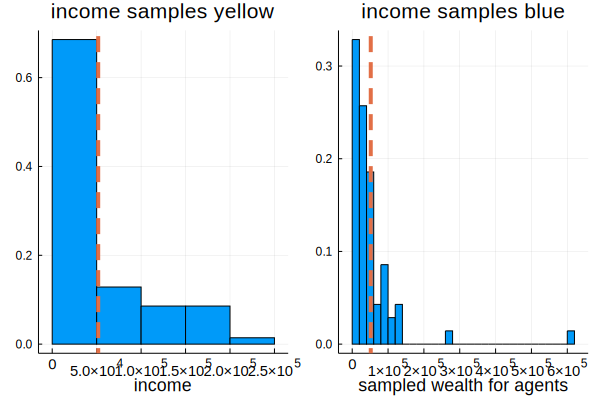

In [49]:
#get income samples that have the same total as the reference distribution
#NO NORMED TO HAVE A GOOD REAL DATA CORRESPONDANCE
wealthSamplesYellow = getResidentIncomeSamples(TOTAL_INCOME_GROUP)
wealthSamplesBlue = getResidentIncomeSamples(TOTAL_INCOME_GROUP)    
    
pltHistYellow = histogram(wealthSamplesYellow,normalize=:probability,
    title="income samples yellow",xlabel="income",leg=false,
    xtickfont=10,titlefont=14,guidefont=12)
vline!([mean(wealthSamplesYellow)],line=(4,:dash),leg=false)
pltHistBlue = histogram(wealthSamplesBlue,normalize=:probability,
    title="income samples blue",xlabel="sampled wealth for agents",leg=false,
    xtickfont=10,titlefont=14,guidefont=12)
vline!([mean(wealthSamplesBlue)],line=(4,:dash),leg=false)
plt = plot(pltHistYellow,pltHistBlue)
display(plt)
savefig(plt,newFigNameString())

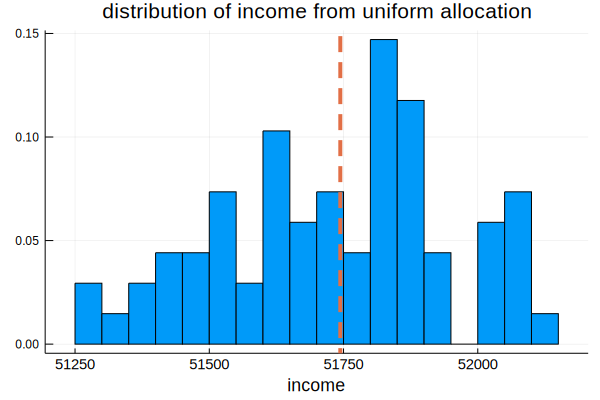

In [50]:
#get the Uniformly allocated incomes for the residents of one type
incomesUniform = randUniformWealthBracketSample()

plt = histogram(incomesUniform,normalize=:probability,
    title="distribution of income from uniform allocation",xlabel="income",leg=false,
    bins=minimum(incomesUniform):50:maximum(incomesUniform),
    xtickfont=10,titlefont=14,guidefont=12)
vline!([mean(incomesUniform)],line=(4,:dash),leg=false)
display(plt)
savefig(plt,newFigNameString())

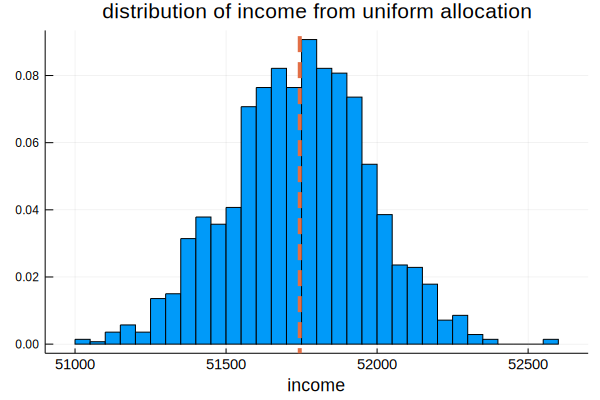

In [51]:
#get the Distribution for multiple iniform income distributed samples

uniformResidentIncomes = [randUniformWealthBracketSample() for x in 1:UNIFORM_SAMPLE_NUM]
uniformResidentIncomesVec = zeros(UNIFORM_SAMPLE_NUM*YELLOW_COUNT)
for i in 1:UNIFORM_SAMPLE_NUM
    uniformResidentIncomesVec[1 + (YELLOW_COUNT*(i-1)): YELLOW_COUNT + (YELLOW_COUNT*(i-1))] = 
        uniformResidentIncomes[i][:]    
end
uniformResidentIncomesMean = mean(uniformResidentIncomesVec)

plt = histogram(uniformResidentIncomesVec,normalize=:probability,
    title="distribution of income from uniform allocation",xlabel="income",leg=false,
    xtickfont=10,titlefont=14,guidefont=12)
vline!([mean(uniformResidentIncomesVec)],line=(4,:dash),leg=false)
display(plt)
savefig(plt,newFigNameString())

In [95]:
#generates the grid where the finance is the uniform dollar drop process
gridUniformIncome = make_uniform_sampled_finance_grid();


In [97]:
#spatial and financial data that is from the income distribution
gridDataIncome = make_random_finance_grid();


In [54]:
#get the financial surroundings
#pass the grid and provide the cell to get the surrounding finance or type array
arrayCellFinance = cell_surround_arrayTMP_financial(gridDataIncome,11,12,2)
println(arrayCellFinance)
arrayCellType = cell_surround_arrayTMP_financial(gridDataIncome,11,12,1)
println(arrayCellType)

Any[0.0, 36926.0, 50353.0, 23498.0, 117491.0, 30736.0, 83922.0, 0.0]
Any[0.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 0.0]


In [55]:
#return the median absolute deviation of an income cell
moneyDeviation = financial_cell_deviation(gridUniformIncome,5,12)
println(moneyDeviation)


364.0


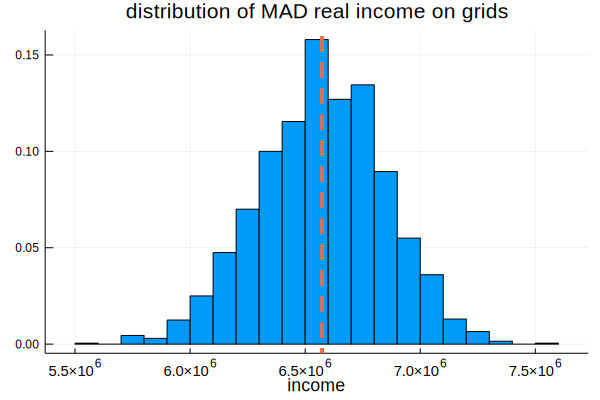

In [56]:
#MAD deviations using the data from incomes 
randomIncomeDataDeviations = [financial_grid_deviation(make_random_finance_grid()) for x in 1:NUM_RAND_SAMPLES]
meanRealSampleIncomeDeviations = mean(randomIncomeDataDeviations)

plt = histogram(randomIncomeDataDeviations,normalize=:probability,
    title="distribution of MAD real income on grids",xlabel="income",leg=false,
    xtickfont=10,titlefont=14,guidefont=12)
vline!([mean(randomIncomeDataDeviations)],line=(4,:dash),leg=false)
display(plt)
savefig(plt,newFigNameString())

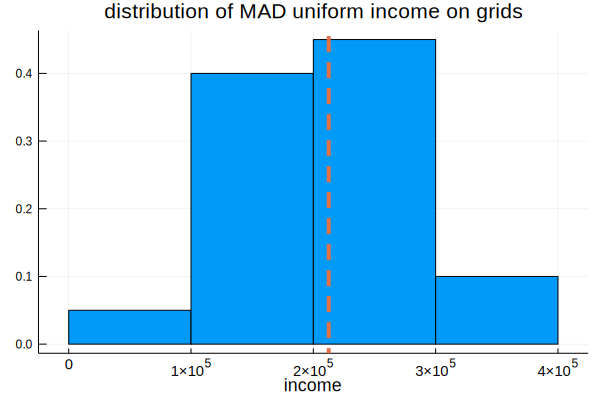

In [57]:
#MAD deviations using the data from incomes 
randomUniformDataDeviations = [financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:UNIFORM_SAMPLE_NUM]#NUM_RAND_SAMPLES]
meanUniformSampleIncomeDeviations = mean(randomUniformDataDeviations)

plt = histogram(randomUniformDataDeviations,normalize=:probability,
    title="distribution of MAD uniform income on grids",xlabel="income",leg=false,
    xtickfont=10,titlefont=14,guidefont=12)
vline!([mean(randomUniformDataDeviations)],line=(4,:dash),leg=false)
display(plt)
savefig(plt,newFigNameString())

In [58]:
#SAMPLES SPACE OF THE 2D MODEL, 
#permutation number for the spatial and the income resident state
SET_2D_SPATIAL_INCOME_CELL_SPACE(TOTAL_INCOME_GROUP); # sets: CELLS_SPACE_SIZE_2D

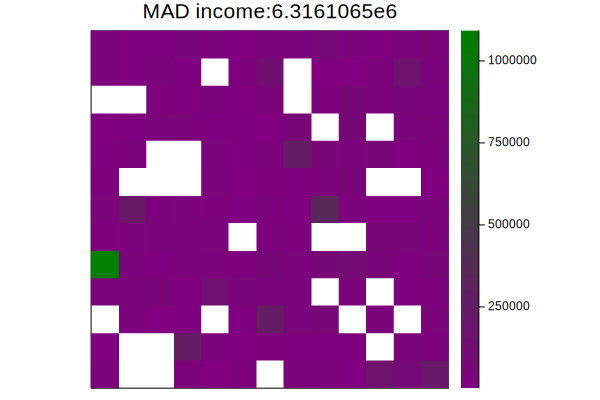

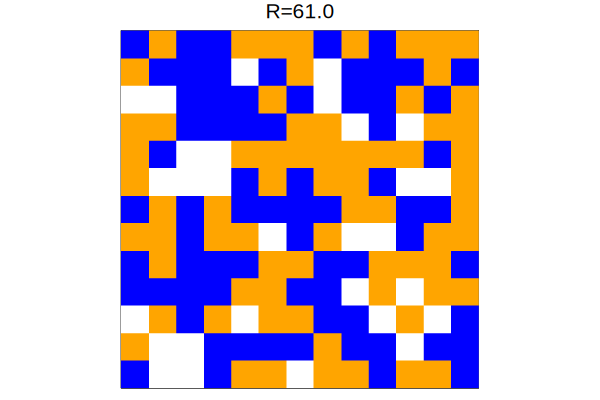

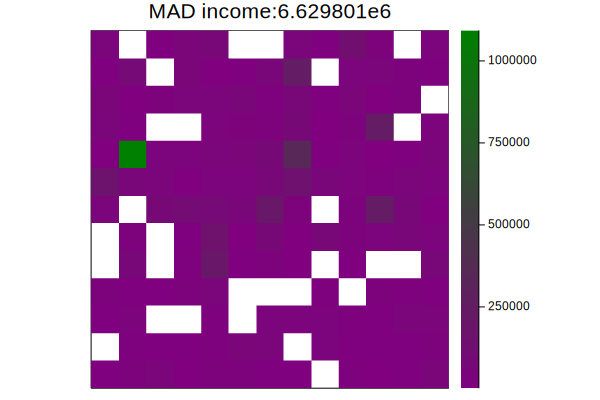

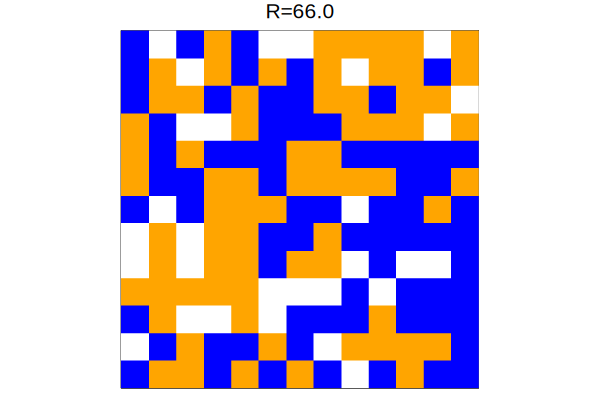

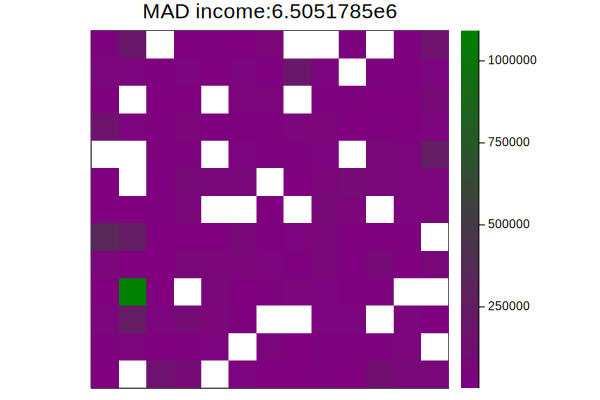

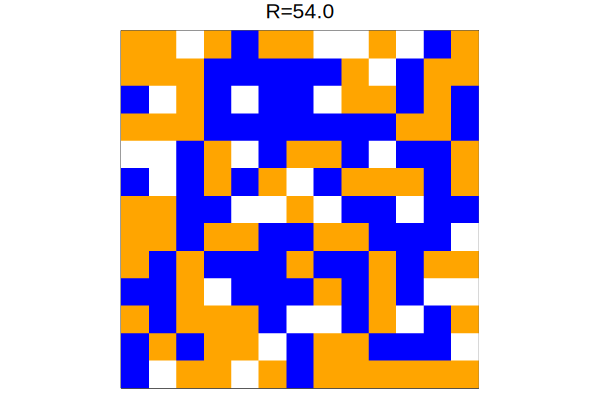

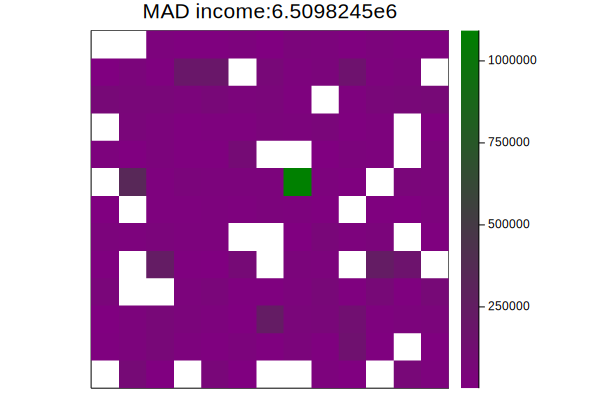

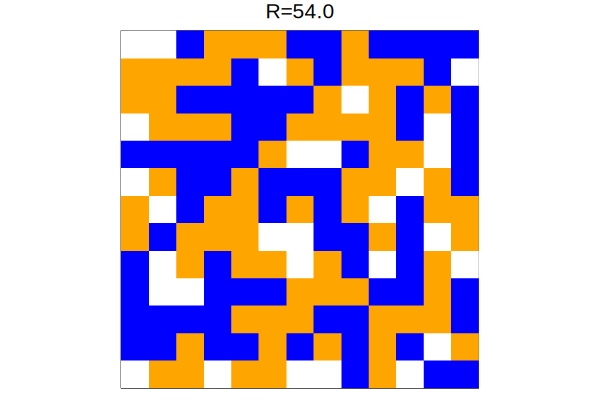

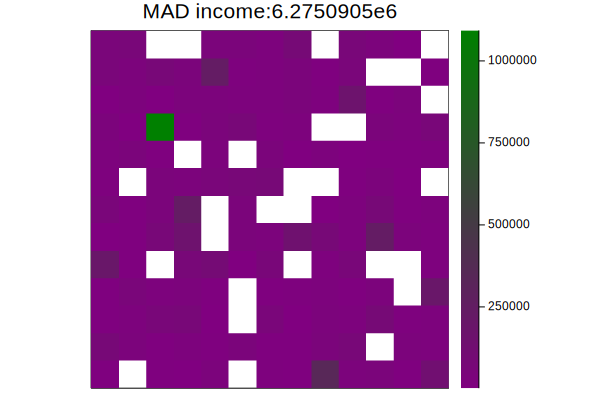

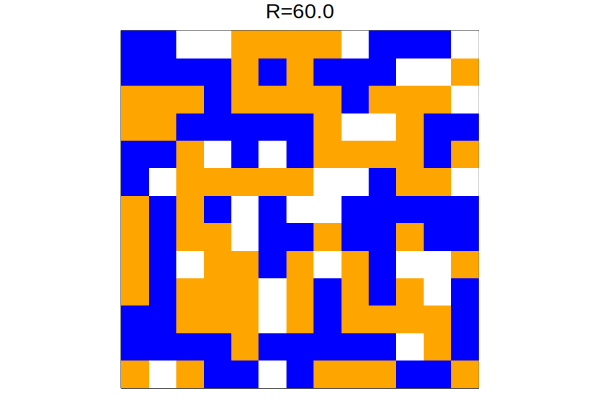

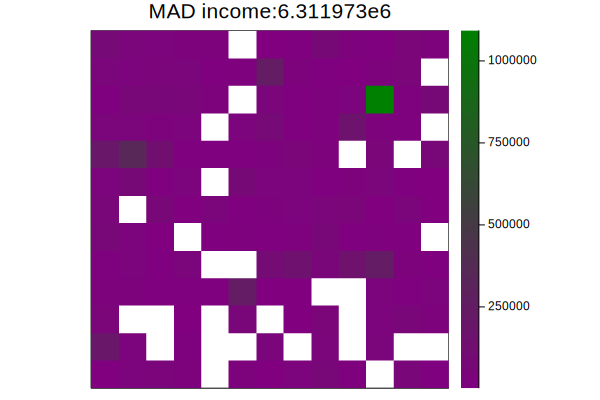

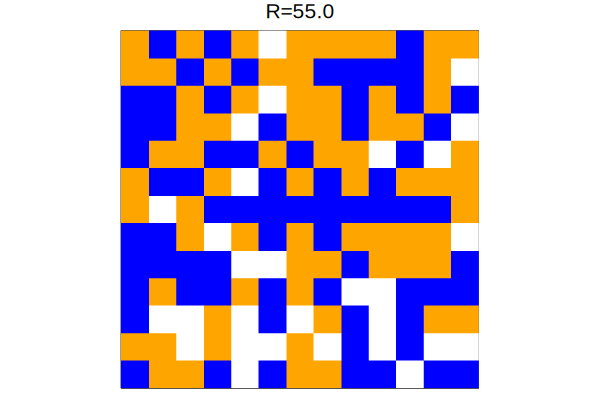

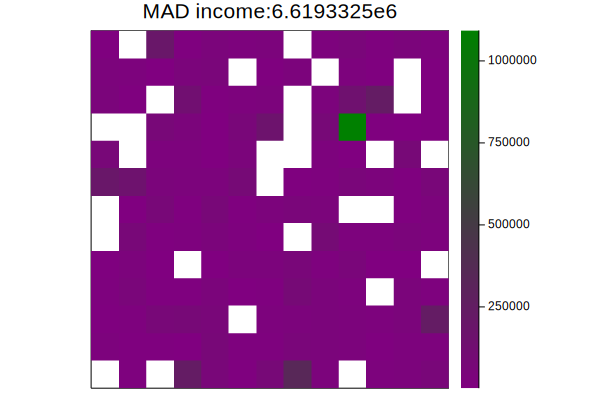

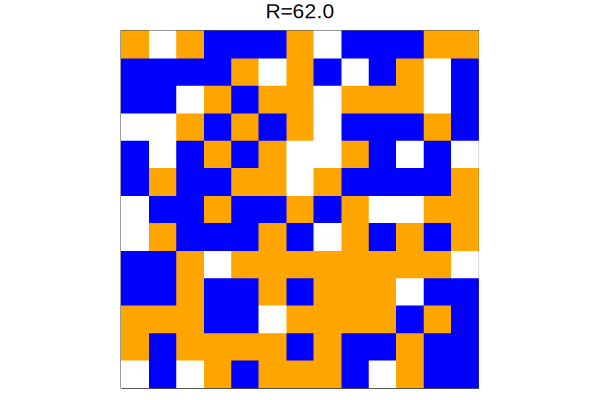

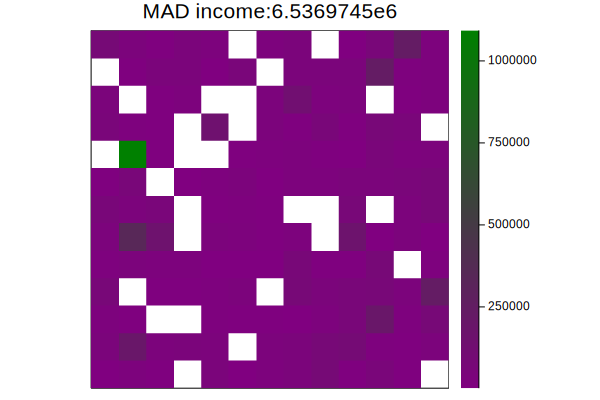

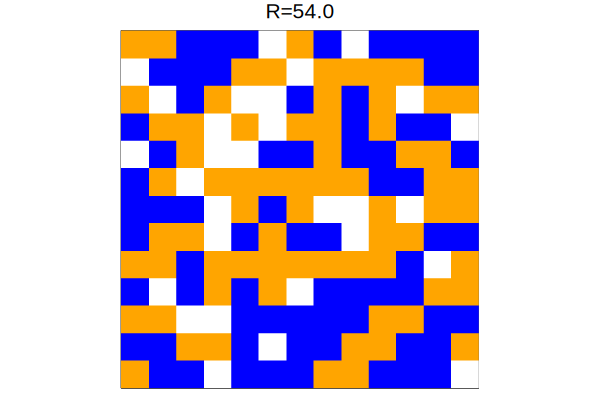

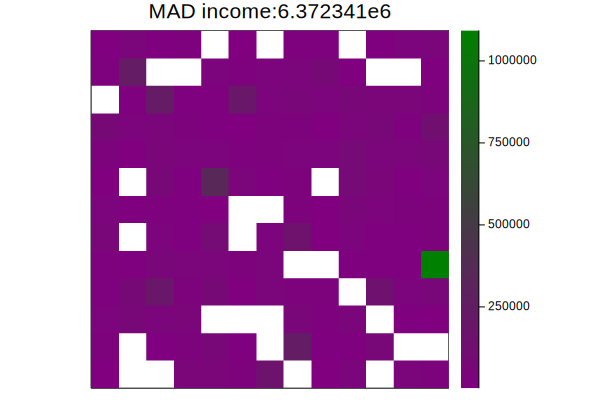

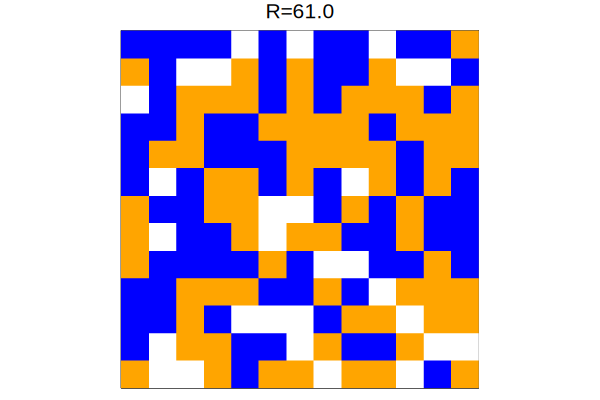

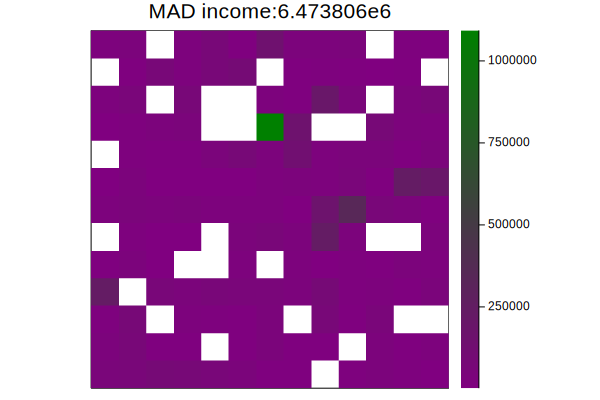

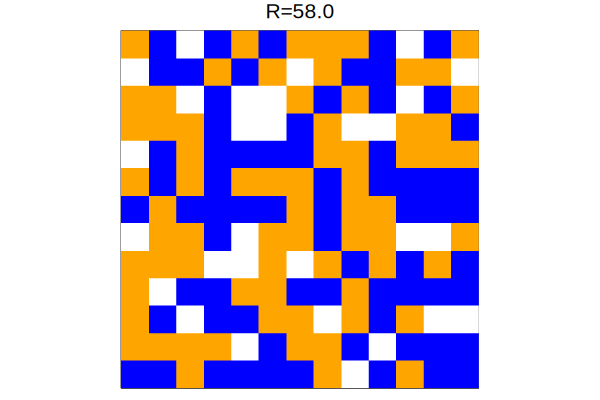

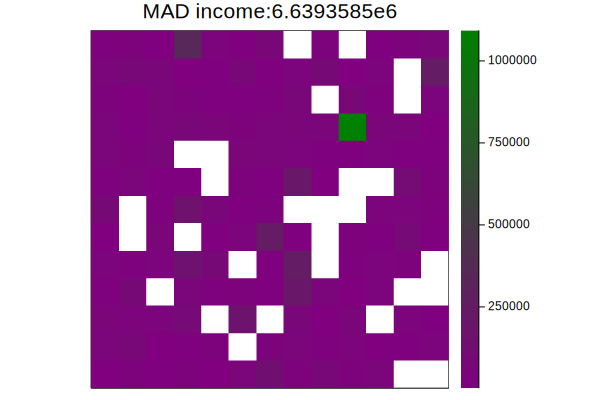

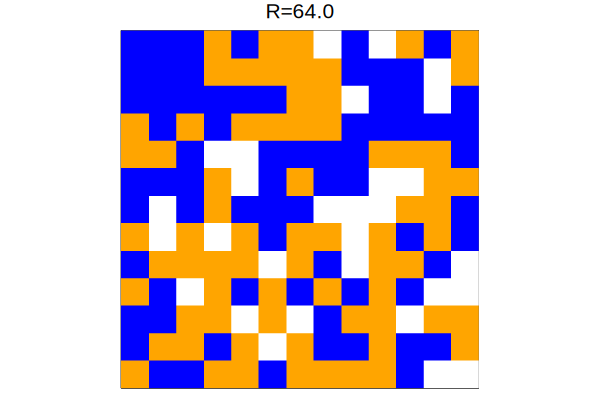

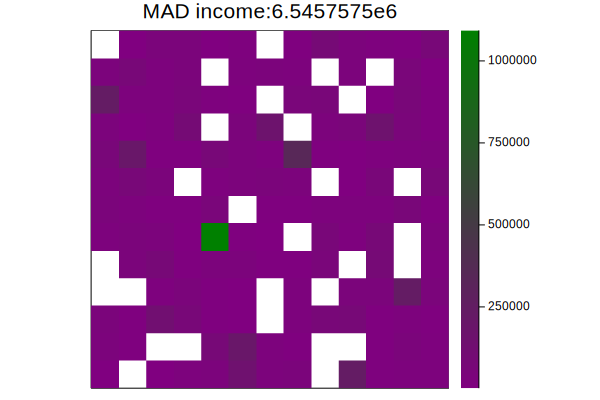

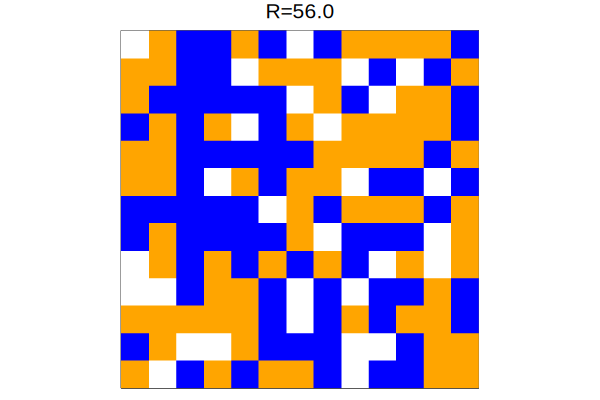

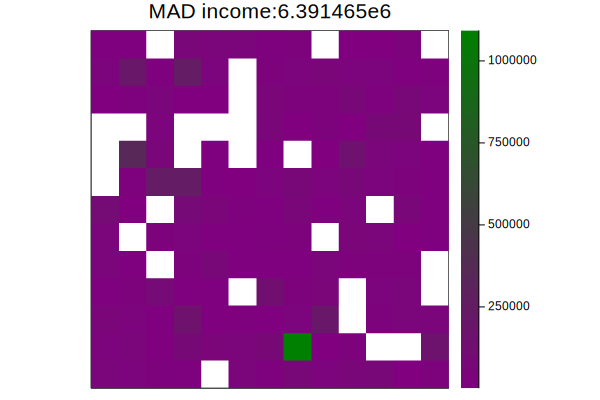

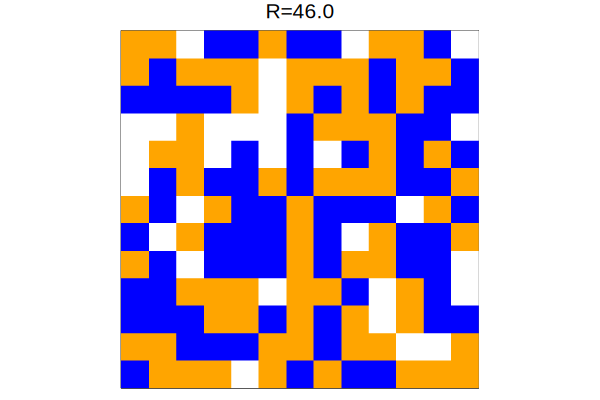

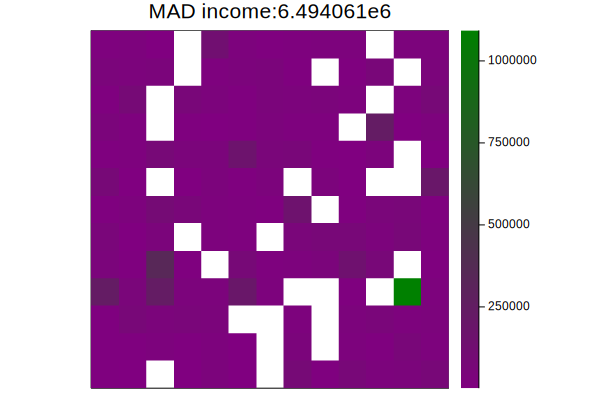

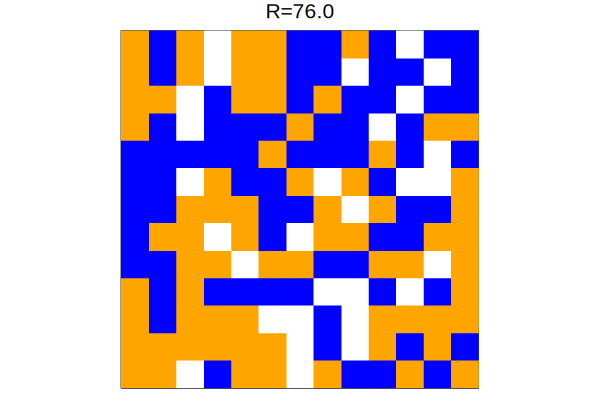

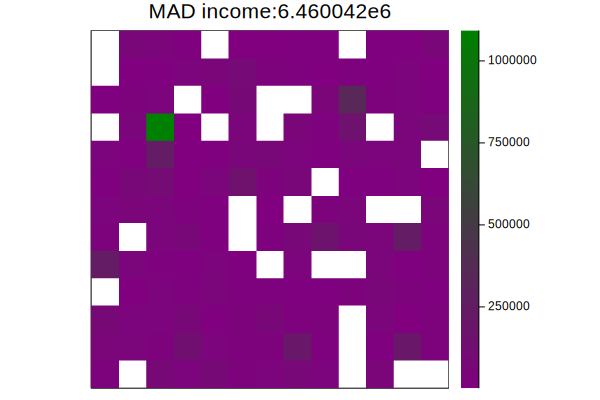

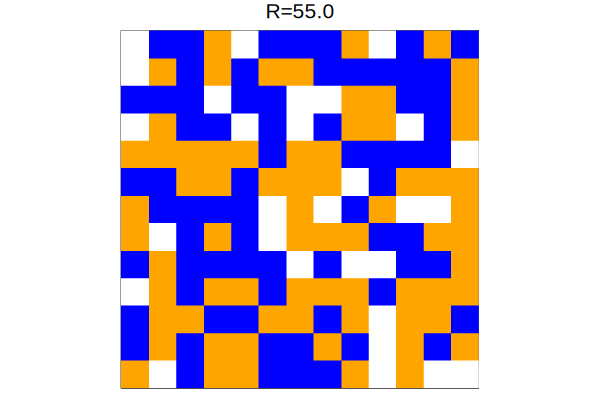

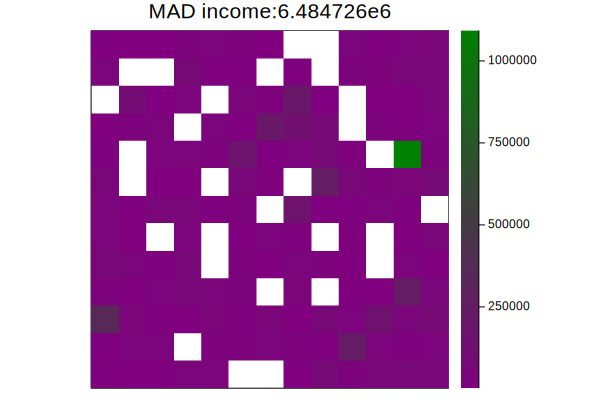

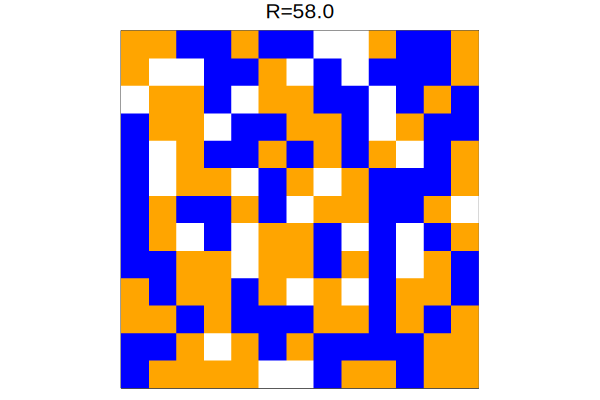

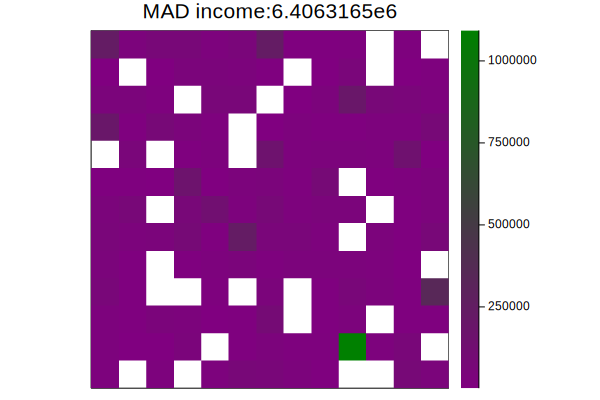

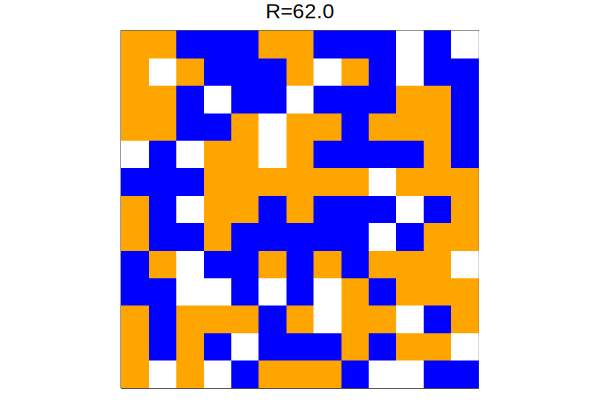

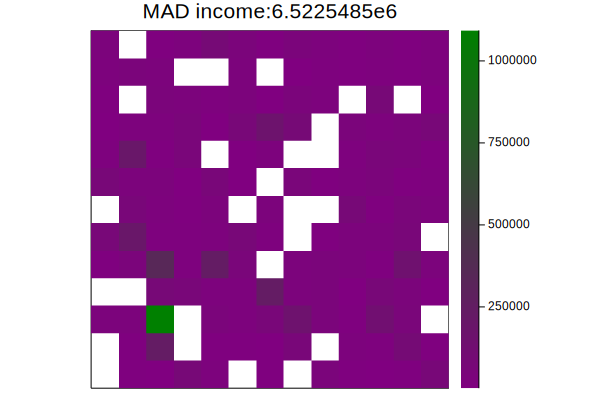

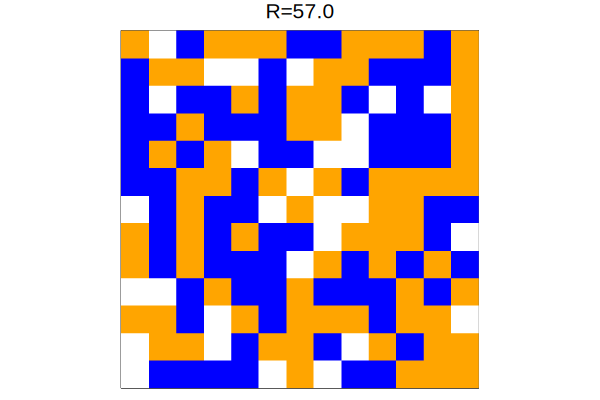

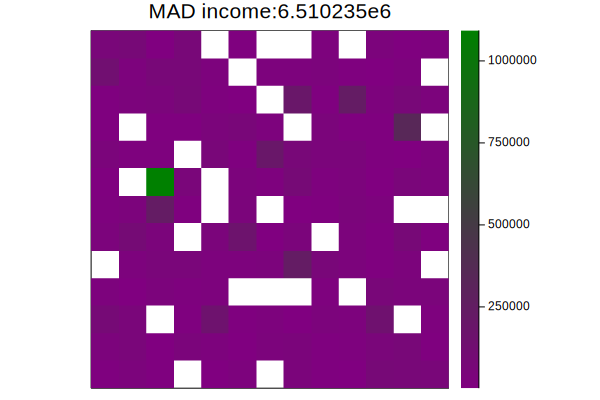

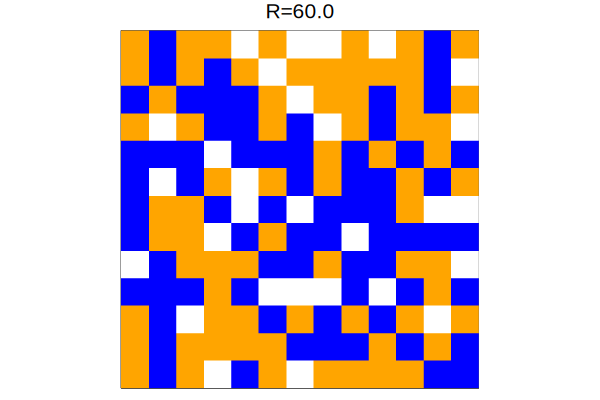

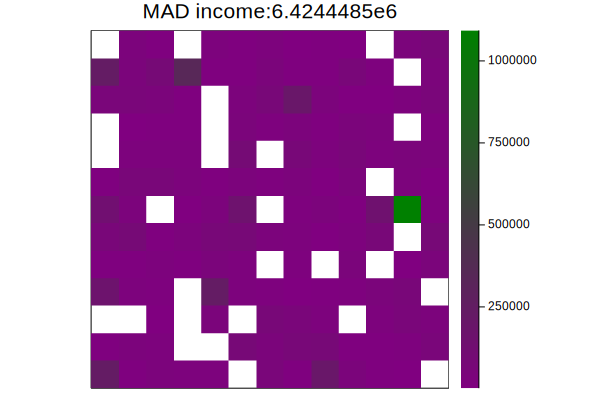

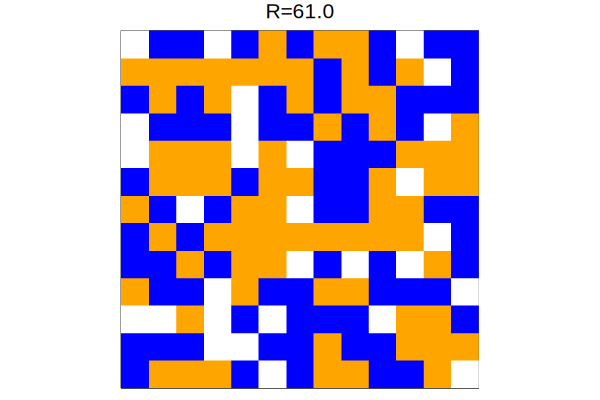

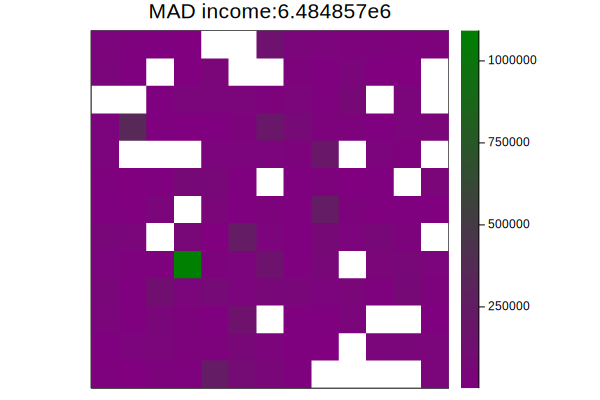

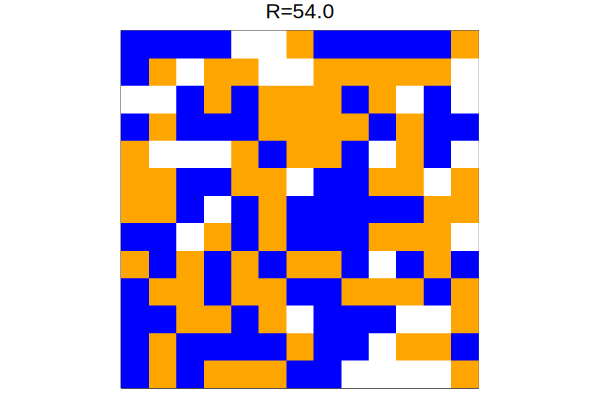

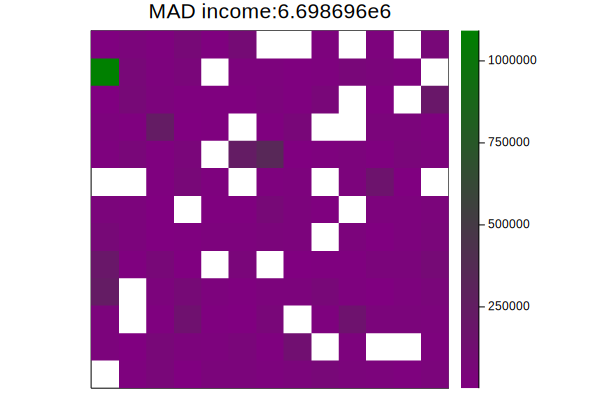

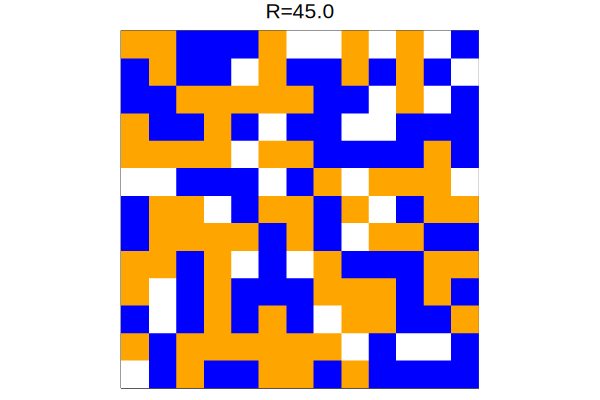

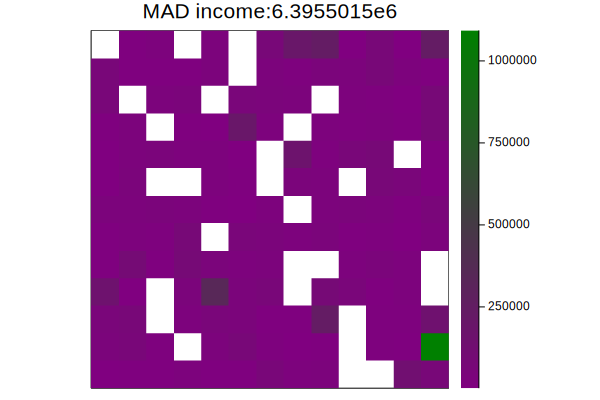

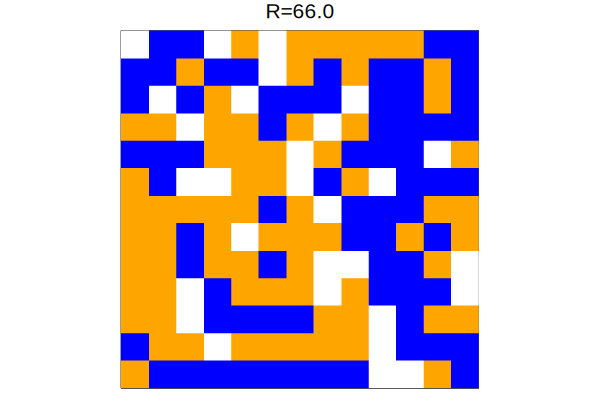

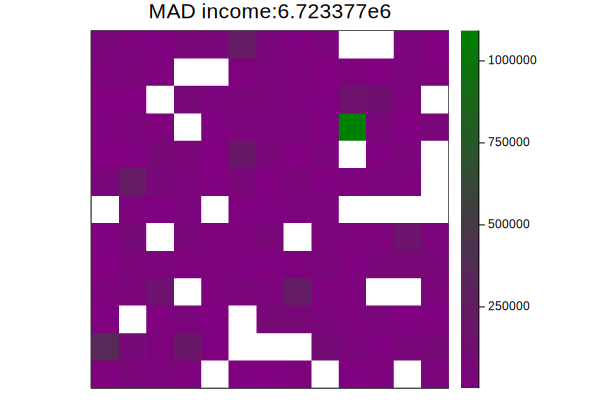

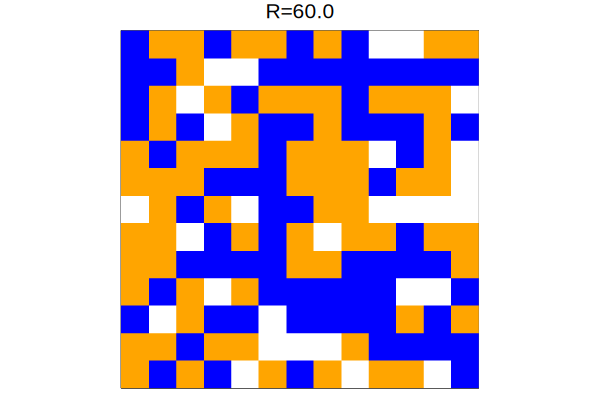

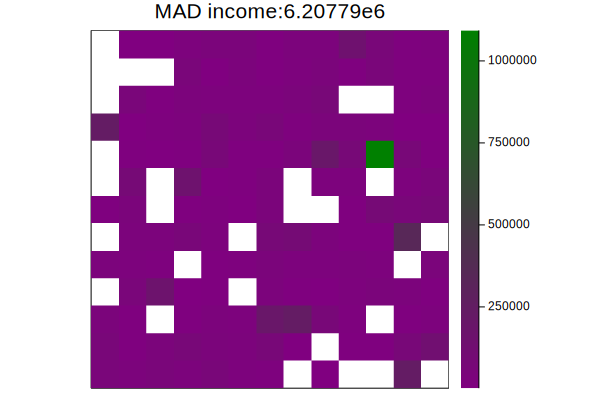

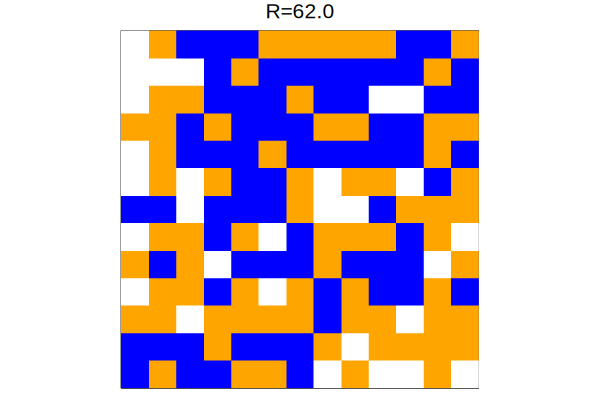

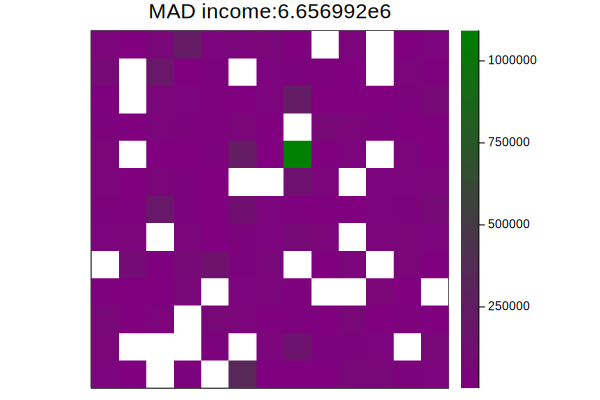

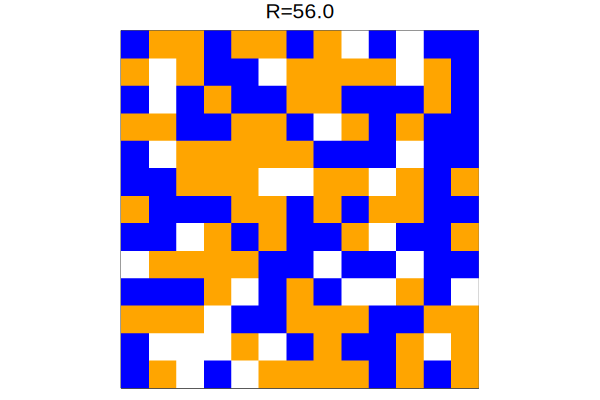

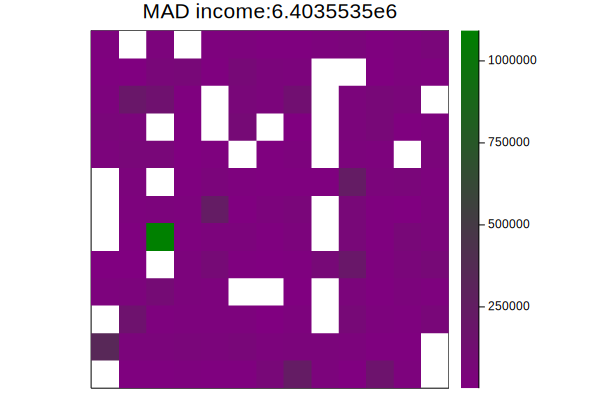

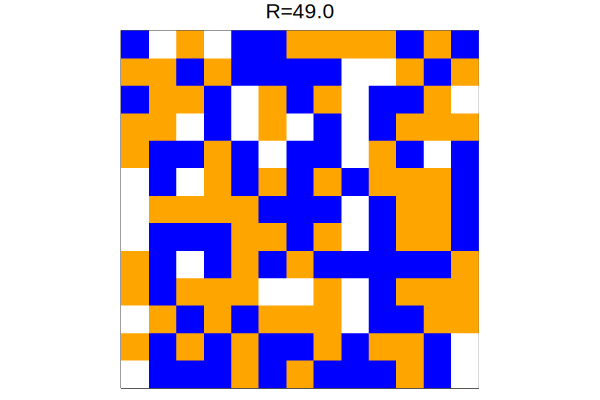

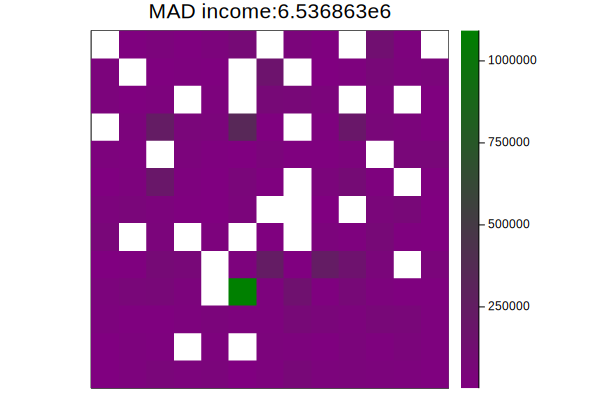

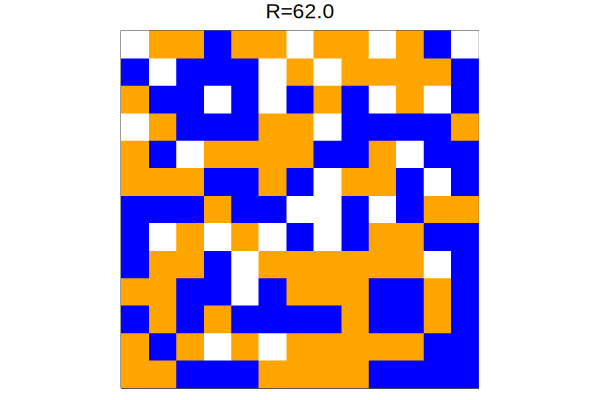

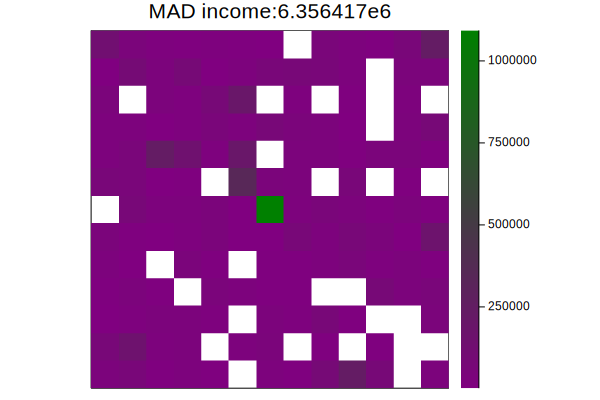

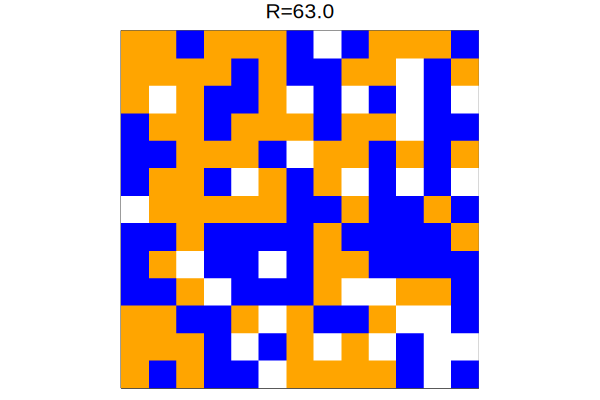

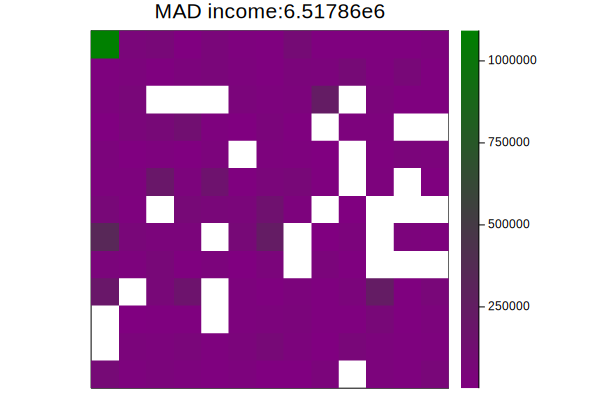

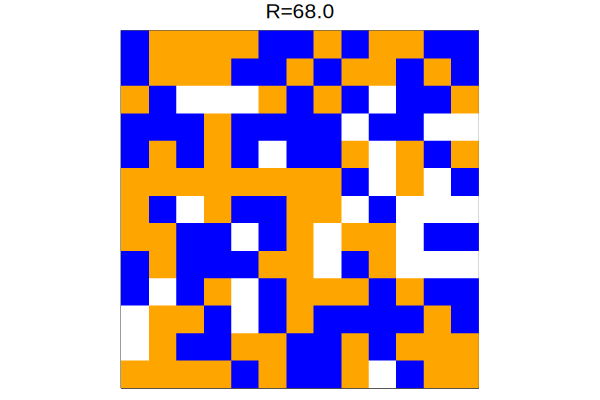

In [137]:
#simulate movement with no dynamics and track both the macrostates variables REAL INCOME DATA
traceR_real_single = zeros(TT)
traceI_real_single = zeros(TT)
moneyGrid = make_random_finance_grid() 
trace2D = [] #stores the tuples of the trace 2D coordinates
for tt in 1:TT     
    if(tt==1)
        moneyGrid = make_random_finance_grid()  
    else
        moneyGrid =  move_cells_for_wealth_NoDynamics(moneyGrid) #make_random_finance_grid()  
    end        
    traceR_real_single[tt] = grid_satisfaction(moneyGrid[:,:,1])
    traceI_real_single[tt] = financial_grid_deviation(moneyGrid)
    
    if(tt==1)
        trace2D = (traceR_real_single[tt],traceI_real_single[tt])
    else
        trace2D = vcat(trace2D,[(traceR_real_single[tt],traceI_real_single[tt])])
    end  
    
    gridTmp = deepcopy(moneyGrid[:,:,2])
    inds = findall(gridTmp .== 0)    
    gridTmp[inds] .= NaN    
    h = heatmap(gridTmp,title="MAD income:$(round(traceI_real_single[tt],digits=2))",
        showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,
        framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=true,
        c=ColorGradient([:purple,:green]))    
    display(h)    
    savefig(h,"FigsV2/simulationSnapShots2/I_time$(tt).png")
    
    h = gridHeatMap(moneyGrid[:,:,1],"R=$(traceR_real_single[tt])",false)
    display(h)    
    savefig(h,"FigsV2/simulationSnapShots2/R_time$(tt).png")
end


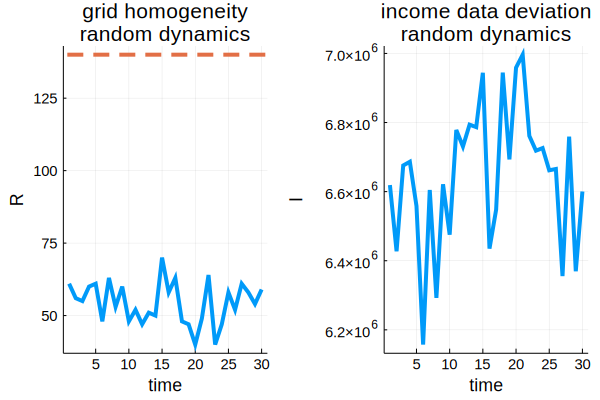

6.57344936225e6
51744.0


In [69]:
#plot the trces for both the spatial and the INCOME DATA
plt1 = plot(traceR_real_single,linewidth=4,title="grid homogeneity \n random dynamics",
    xlabel="time",leg=false,ylabel="R",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
hline!([R_MAX],line=(4,:dash),leg=false)

p2 = plot(traceI_real_single,linewidth=4,title="income data deviation \n random dynamics",xlabel="time",
    leg=false,ylabel="I",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
#hline!([meanRealSampleIncomeDeviations],line=(4,:dash),leg=false)

pboth = plot(plt1,p2)
display(pboth)
savefig(pboth,newFigNameString())
println(meanRealSampleIncomeDeviations)
println(uniformResidentIncomesMean)

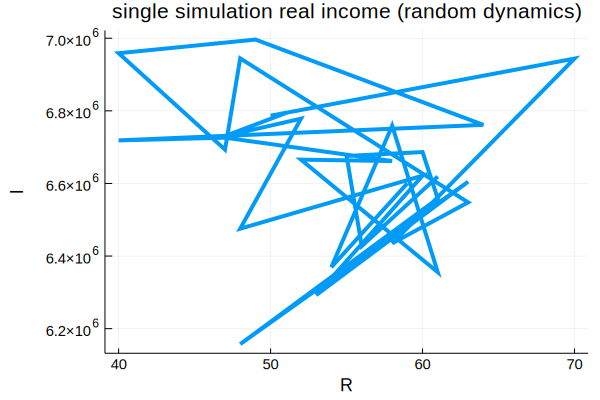

In [70]:
#plot the trajectory of the 2D for REAL DATA INCOME
plt = plot(traceR_real_single,traceI_real_single,line=:path,linewidth=4,title="single simulation real income (random dynamics)",
    xlabel="R",leg=false,ylabel="I",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
display(plt)
savefig(plt,newFigNameString())

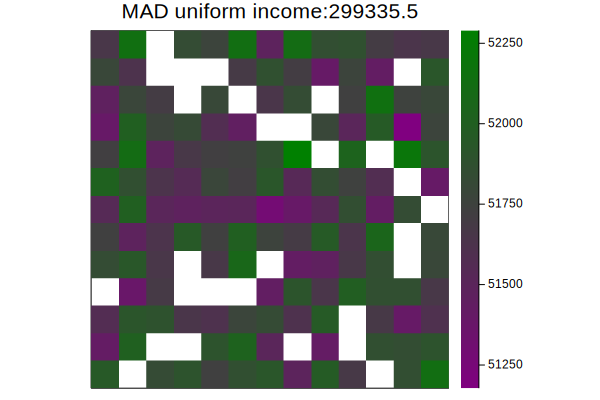

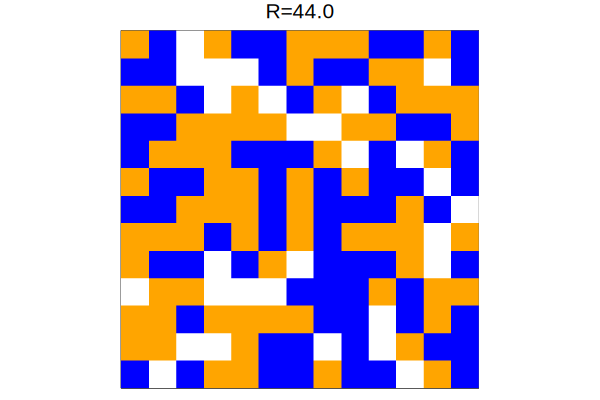

1


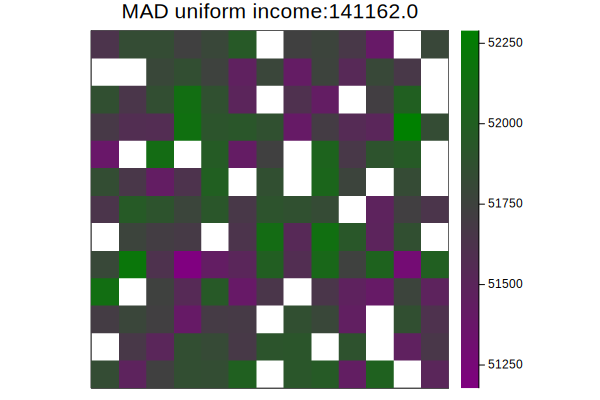

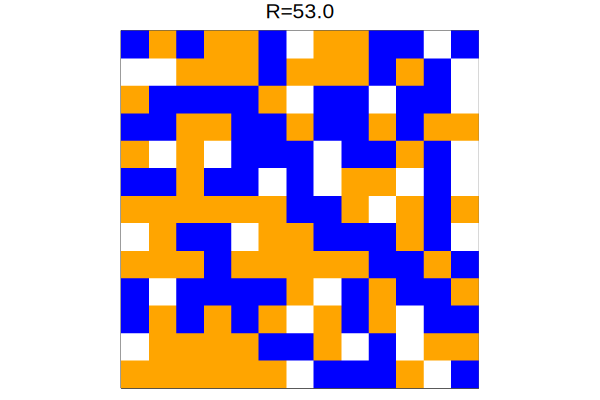

2


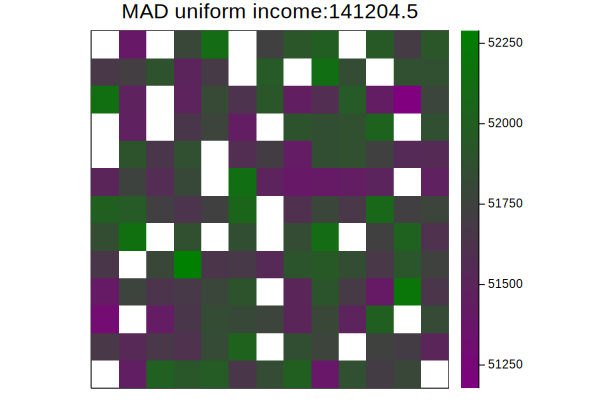

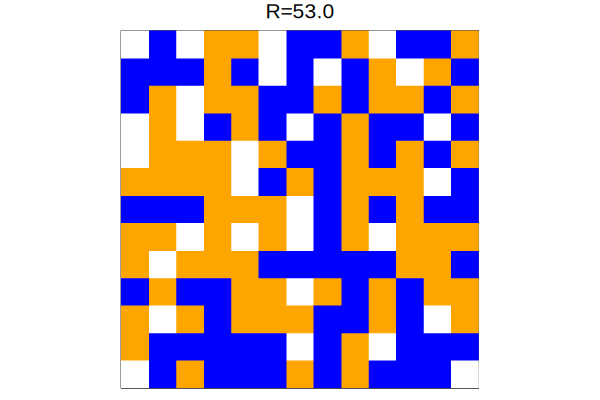

3


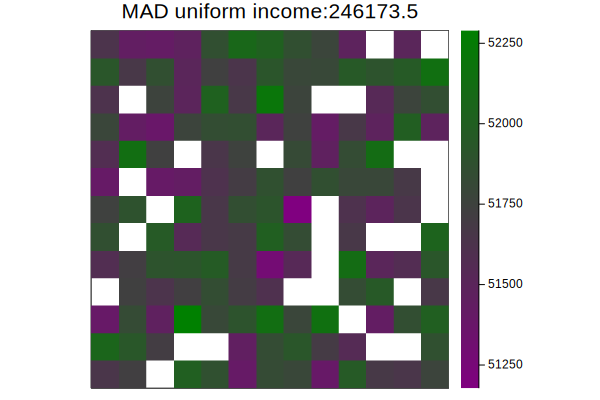

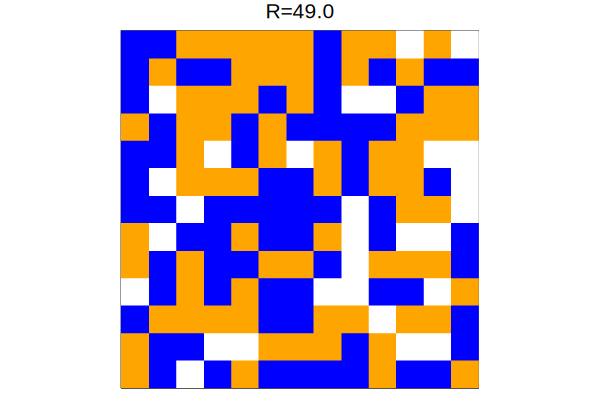

4


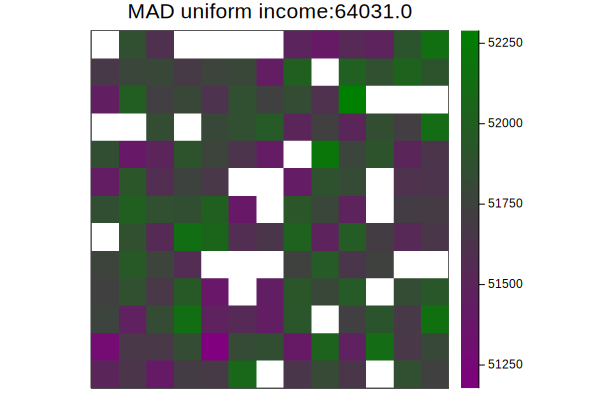

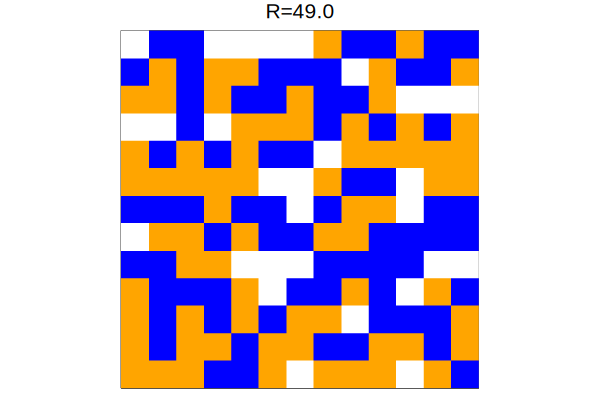

5


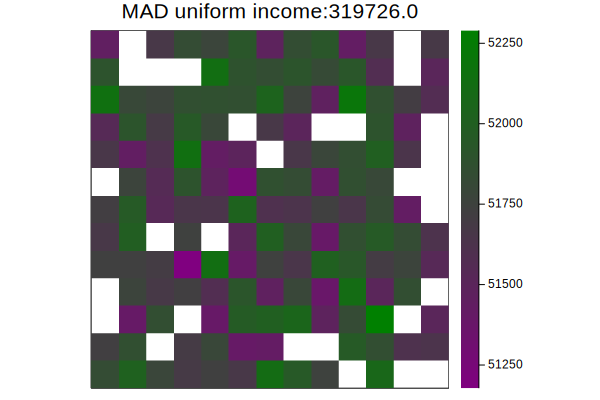

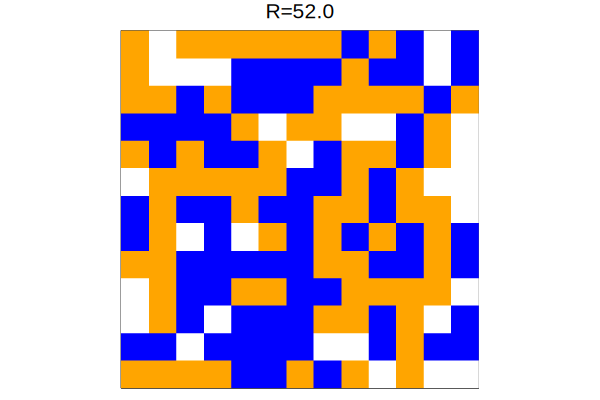

6


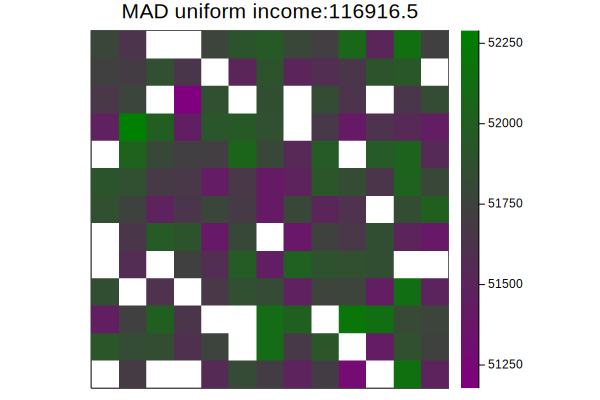

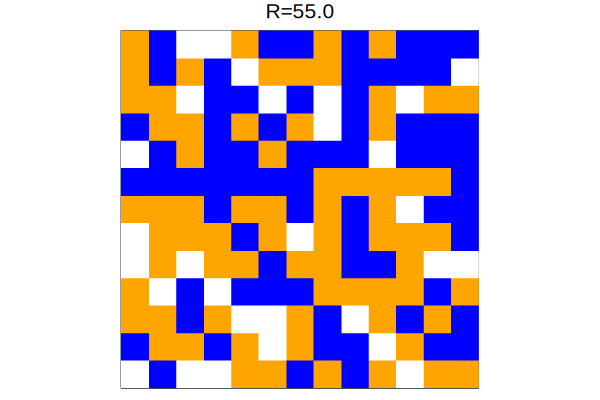

7


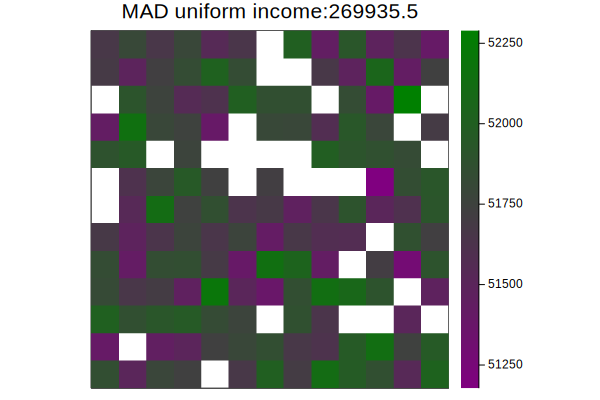

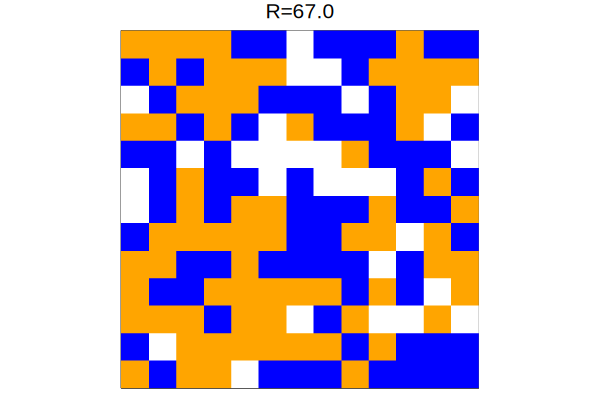

8


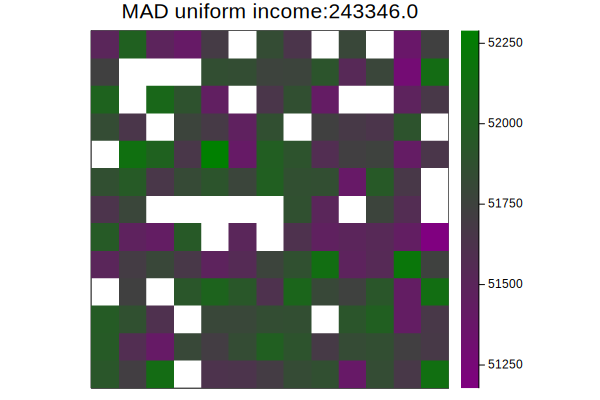

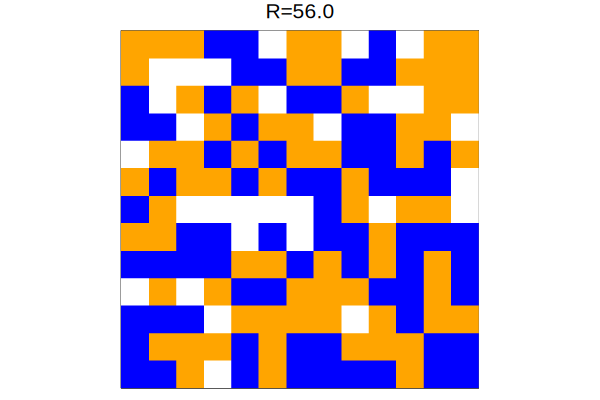

9


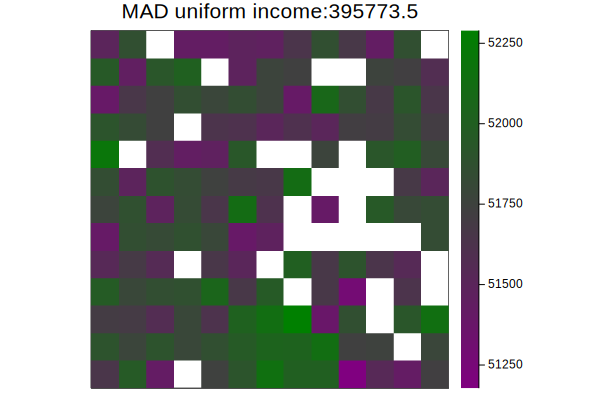

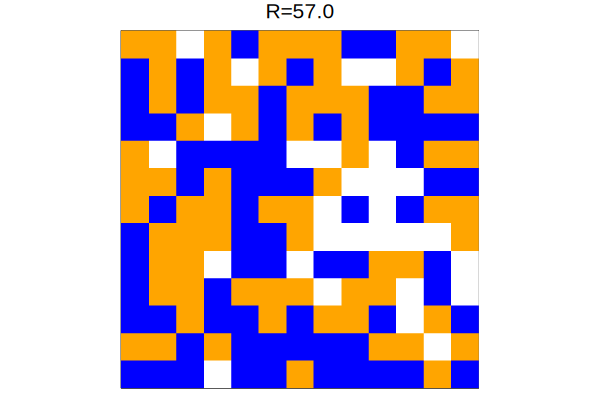

10


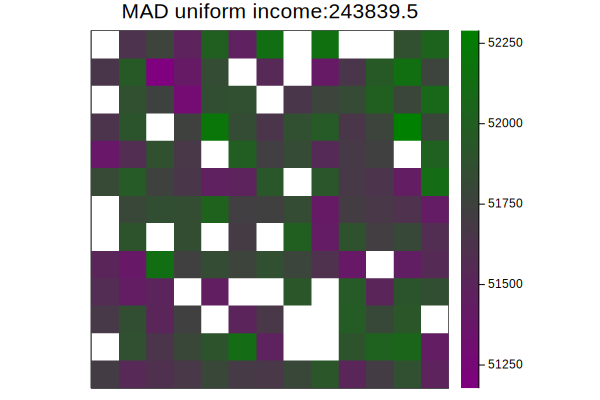

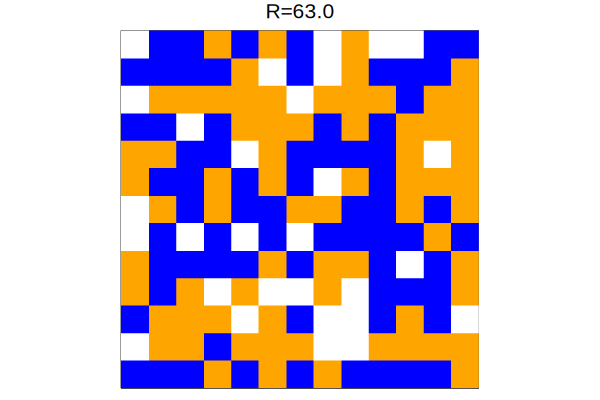

11


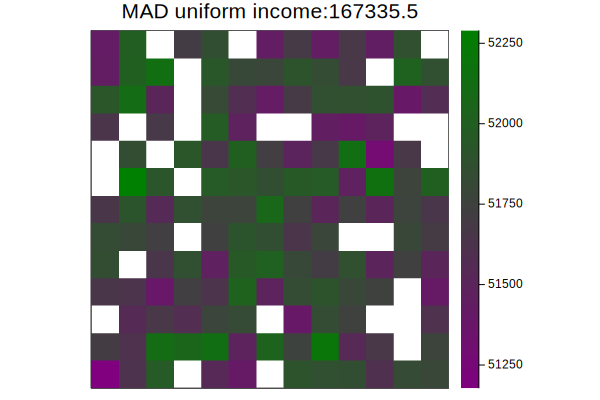

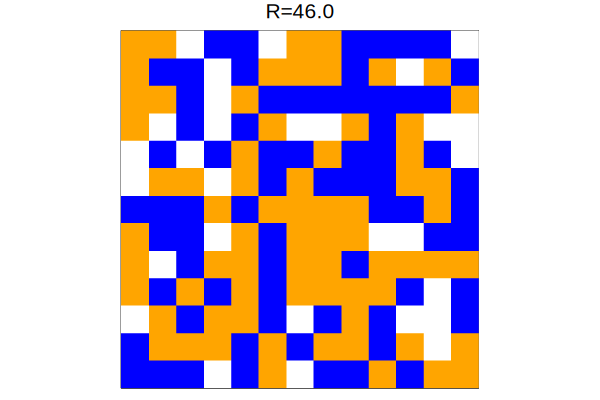

12


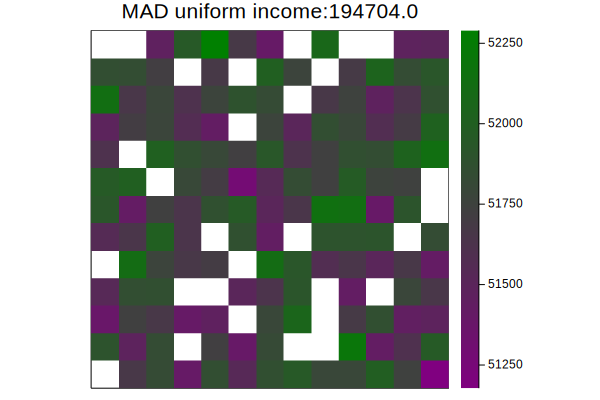

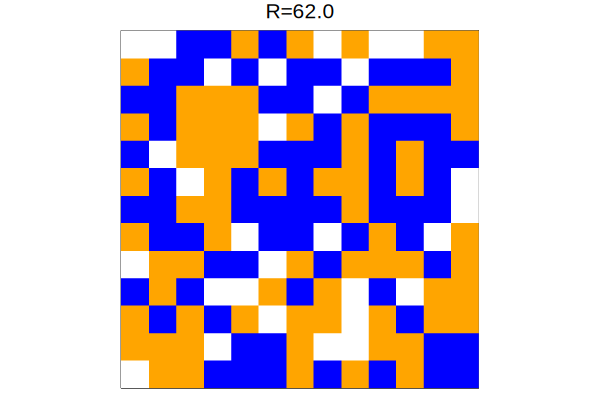

13


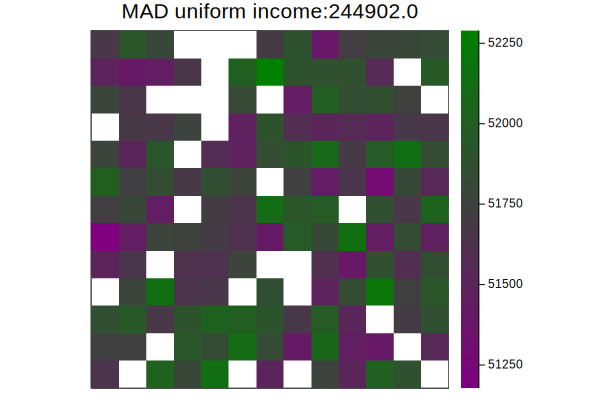

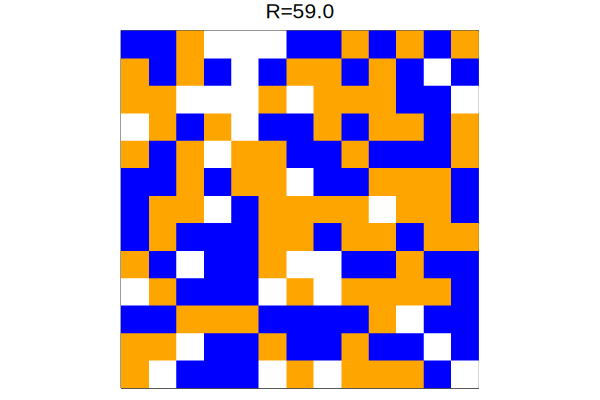

14


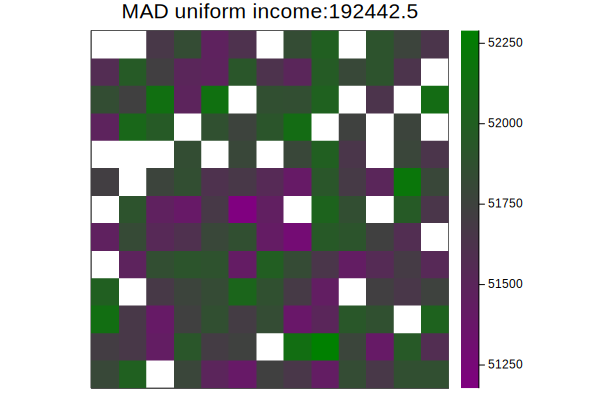

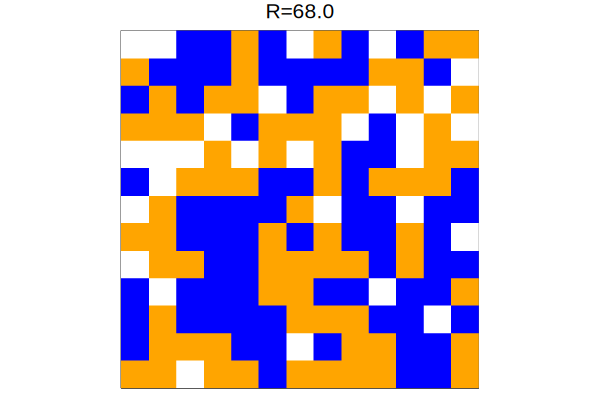

15


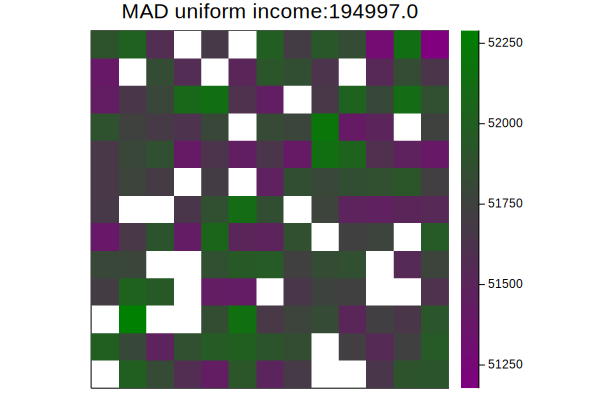

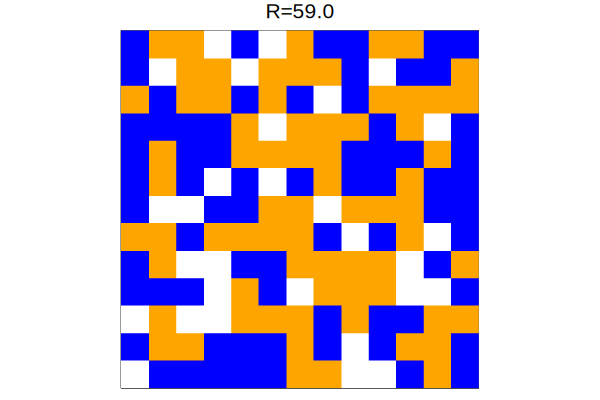

16


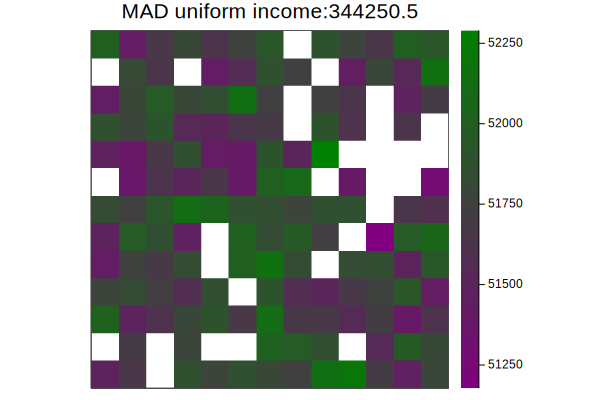

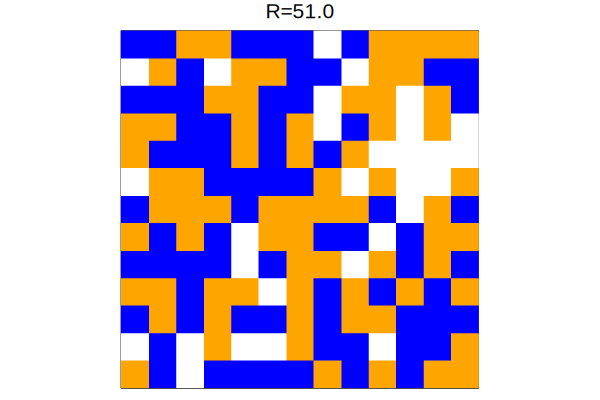

17


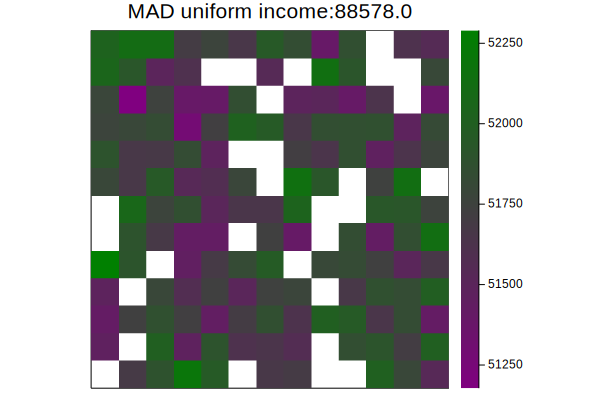

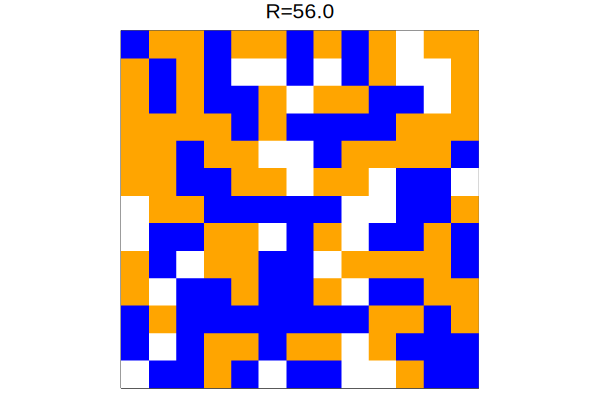

18


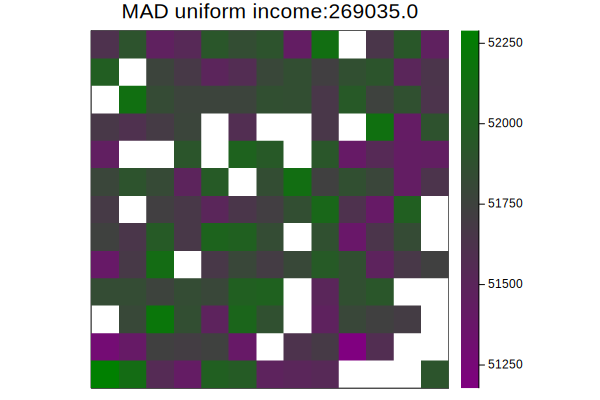

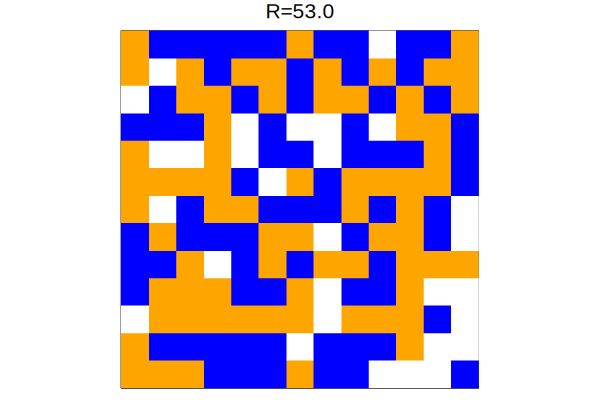

19


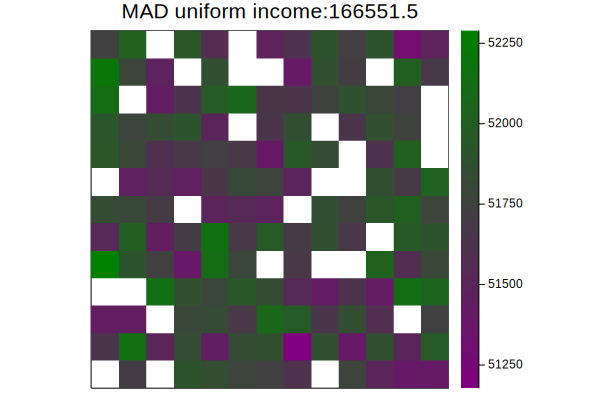

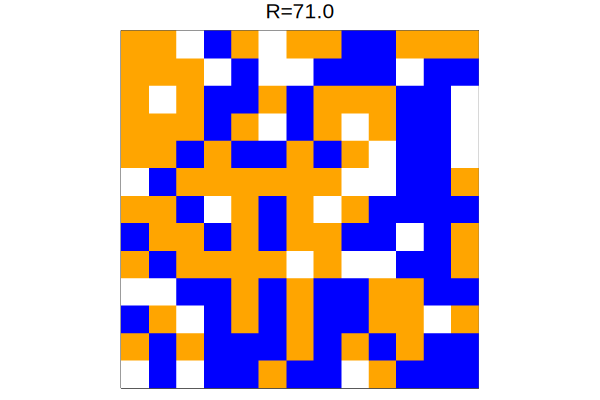

20


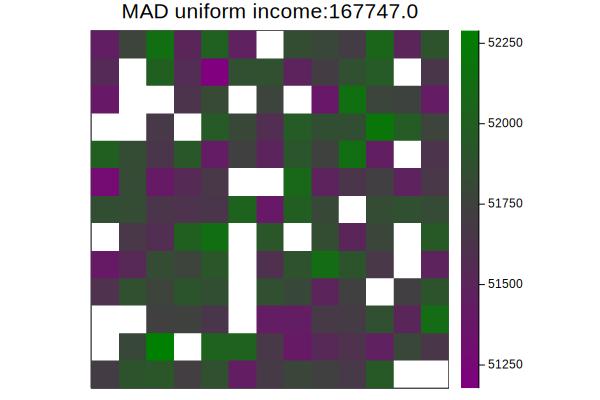

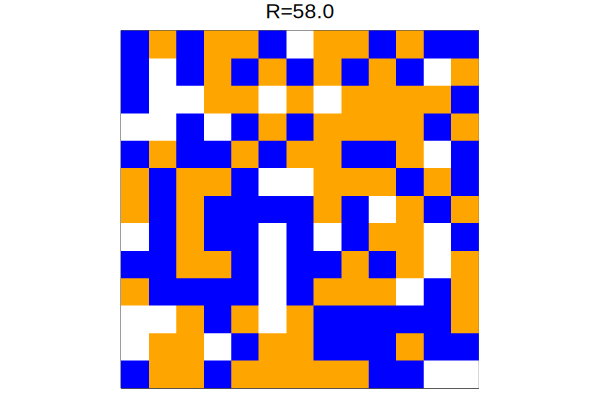

21


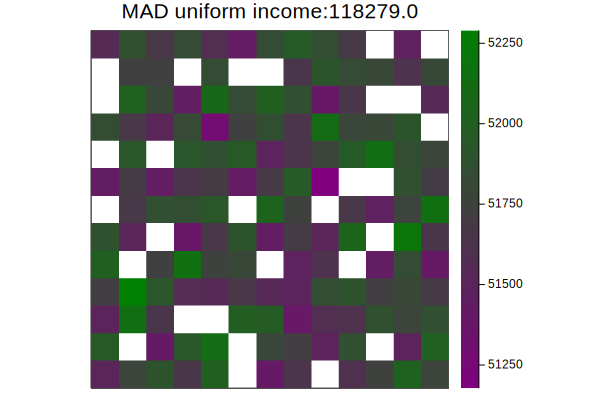

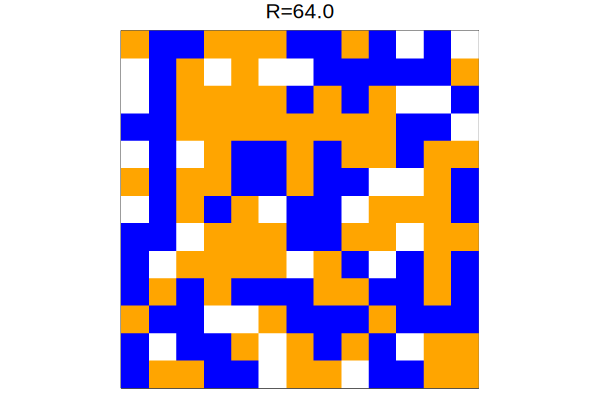

22


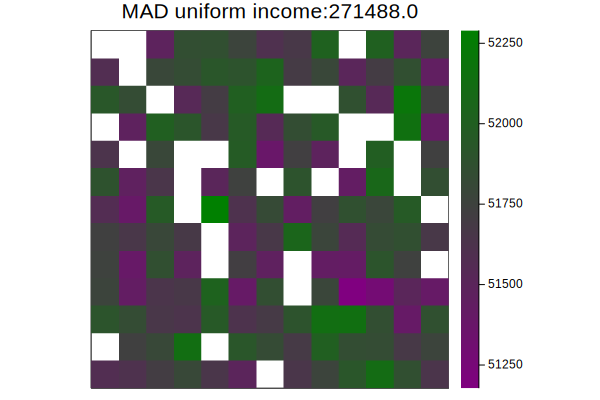

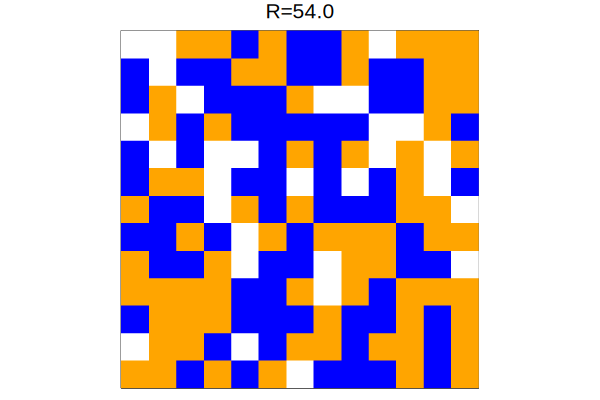

23


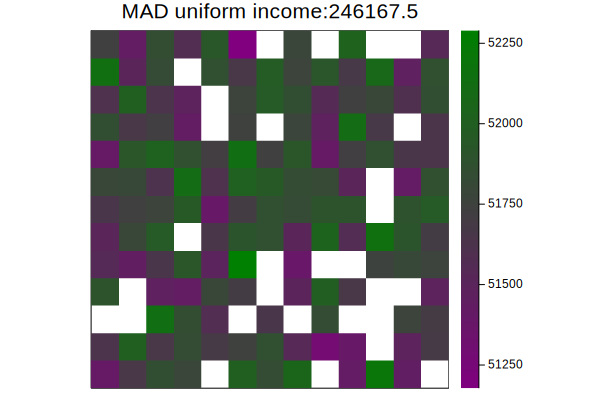

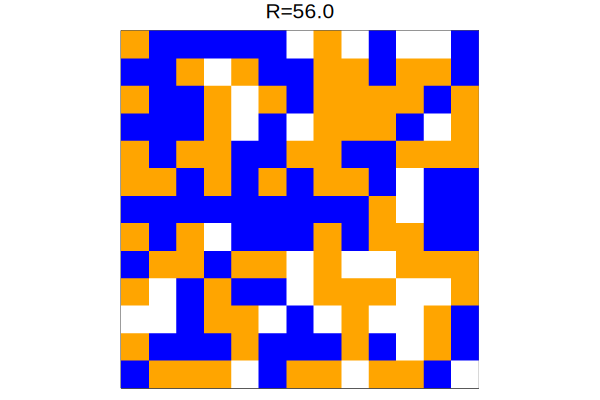

24


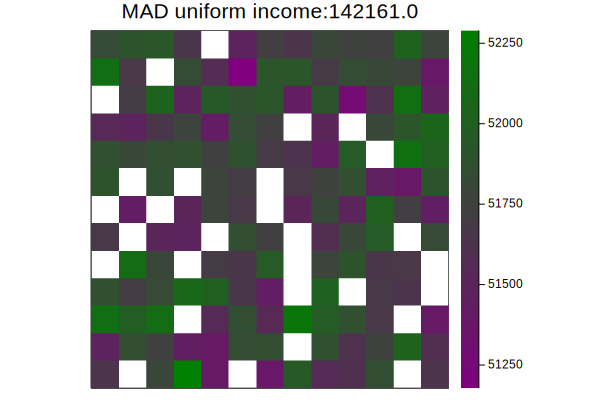

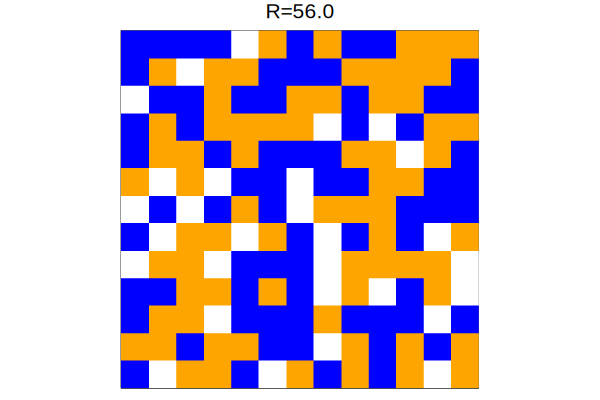

25


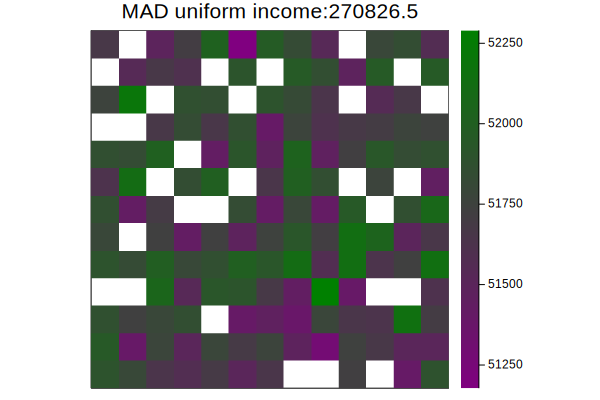

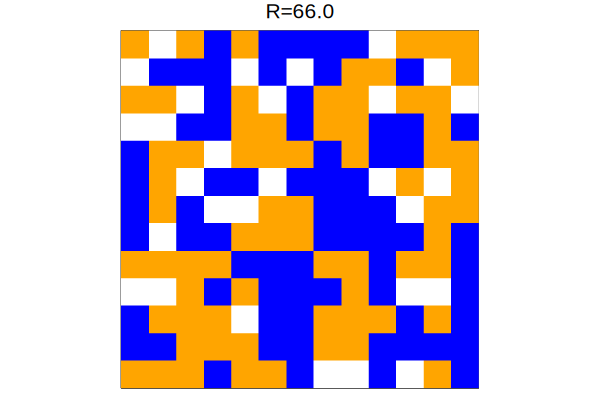

26


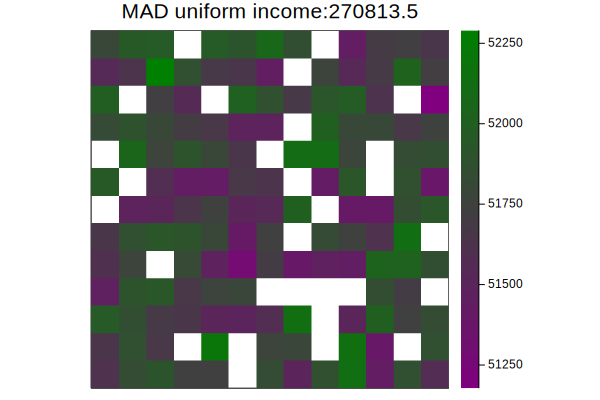

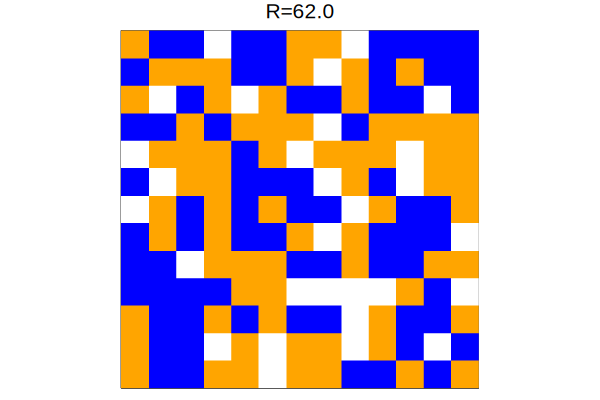

27


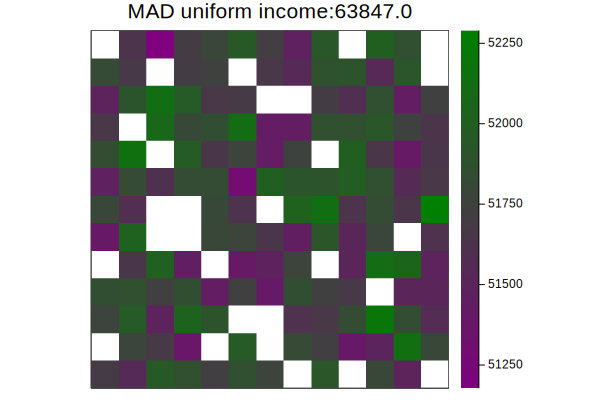

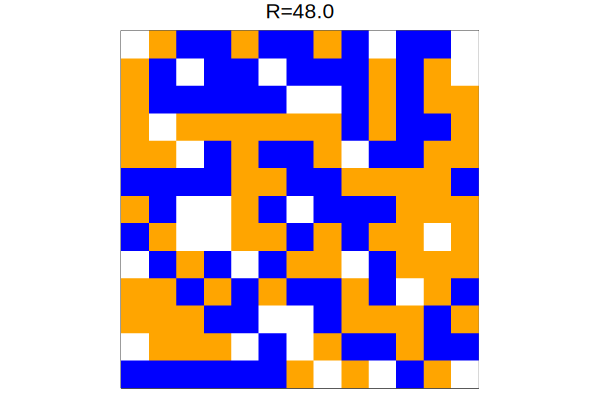

28


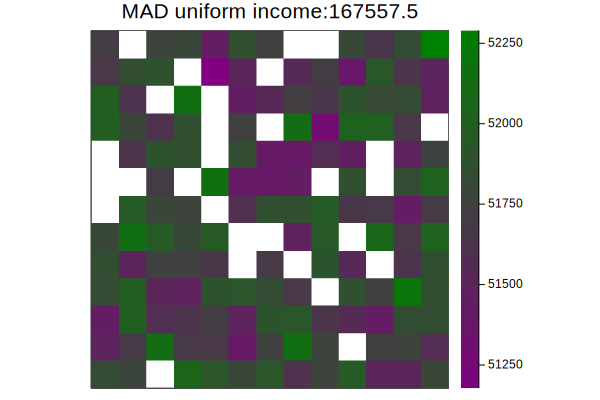

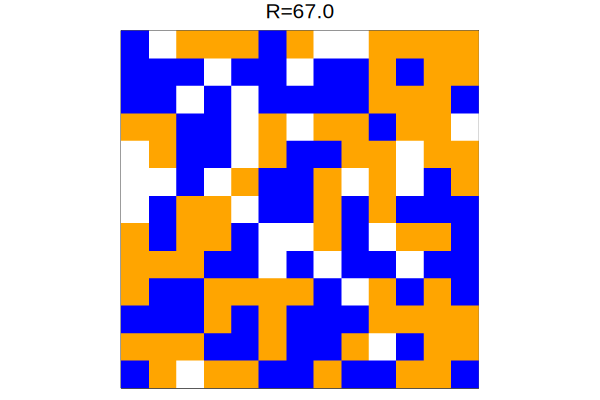

29


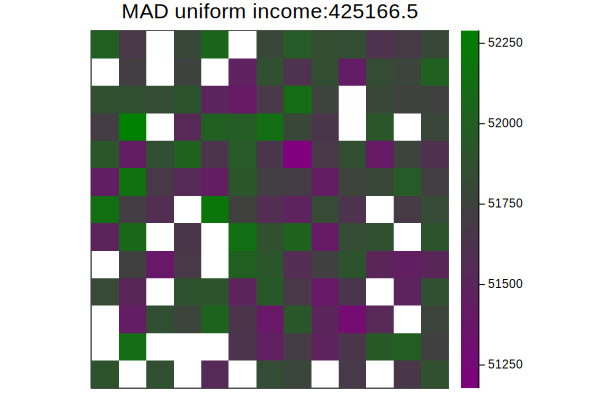

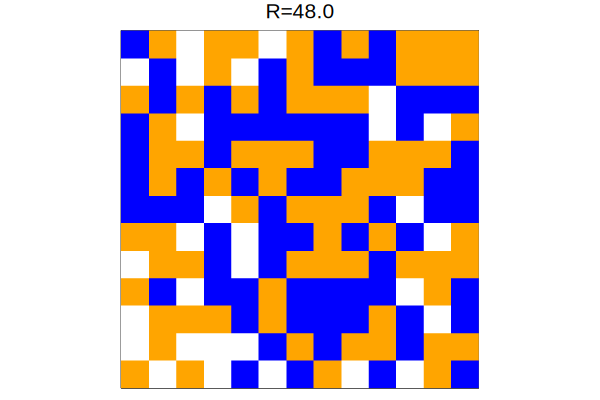

30
425166.5
63847.0


In [136]:
#simulate movement with no dynamics and track both the macrostates variables UNIFORM DATA
traceR_uni_single = zeros(TT)
traceI_uni_single = zeros(TT)
moneyGrid = make_uniform_sampled_finance_grid() 
trace2Duniform = [] #stores the tuples of the trace 2D coordinates
for tt in 1:TT     
    println(tt)
    if(tt==1)
        moneyGrid = make_uniform_sampled_finance_grid()  
    else
        moneyGrid =  move_cells_for_wealth_NoDynamics(moneyGrid) #make_random_finance_grid()  
    end        
    traceR_uni_single[tt] = grid_satisfaction(moneyGrid[:,:,1])
    traceI_uni_single[tt] = financial_grid_deviation(moneyGrid) 
    
    if(tt==1)
        trace2Duniform = (traceR_uni_single[tt],traceI_uni_single[tt])
    else
        trace2Duniform = vcat(trace2Duniform,[(traceR_uni_single[tt],traceI_uni_single[tt])])
    end  
    
    gridTmp = deepcopy(moneyGrid[:,:,2])
    inds = findall(moneyGrid[:,:,1] .== 0)    
    gridTmp[inds] .= NaN   
    h = heatmap(gridTmp,title="MAD uniform income:$(round(traceI_uni_single[tt],digits=2))",
        showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,
        framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=true,
        c=ColorGradient([:purple,:green]))    
    display(h)    
    savefig(h,"FigsV2/simulationSnapShots3/I_time$(tt).png")
    
    h = gridHeatMap(moneyGrid[:,:,1],"R=$(traceR_uni_single[tt])",false)
    display(h)    
    savefig(h,"FigsV2/simulationSnapShots3/R_time$(tt).png")
end
println(maximum(traceI_uni_single))
println(minimum(traceI_uni_single))

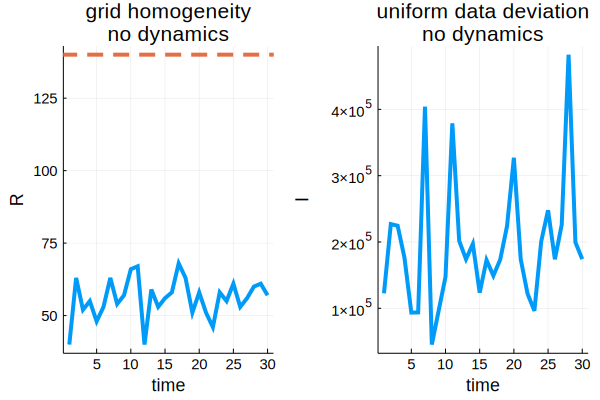

In [72]:
#plot the trces for both the spatial and the UNIFORM DATA
plt1 = plot(traceR_uni_single,linewidth=4,title="grid homogeneity \n no dynamics",
    xlabel="time",leg=false,ylabel="R",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
hline!([R_MAX],line=(4,:dash),leg=false)

p2 = plot(traceI_uni_single,linewidth=4,title="uniform data deviation \n no dynamics",xlabel="time",
    leg=false,ylabel="I",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
#hline!([uniformResidentIncomesMean],line=(4,:dash),leg=false)

pboth = plot(plt1,p2)
display(pboth)
savefig(pboth,newFigNameString())

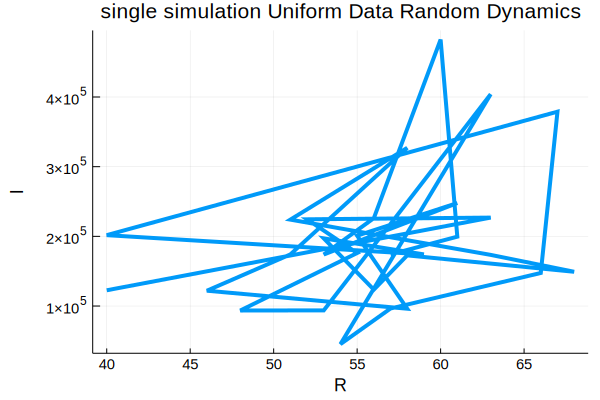

In [73]:
#plot the trajectory of the 2D for UNIFORM DATA INCOME
plt = plot(traceR_uni_single,traceI_uni_single,line=:path,linewidth=4,title="single simulation Uniform Data Random Dynamics",
    xlabel="R",leg=false,ylabel="I",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
display(plt)
savefig(plt,newFigNameString())

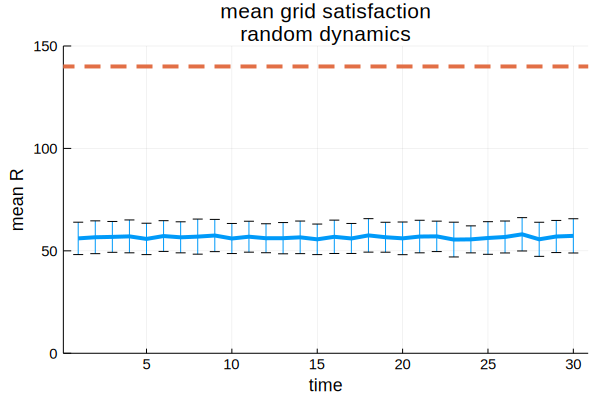

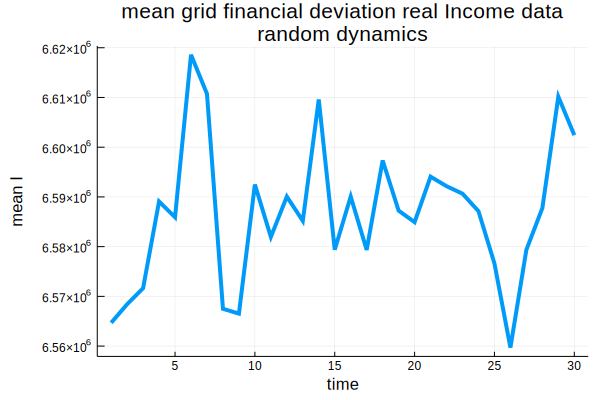

In [74]:
#mean and variance of the no dynamics trajectory REAL INCOME DATA
simulationRvals = zeros(TT,MM)
simulationIvals = zeros(TT,MM)
for mm in 1:MM       
    traceR = zeros(TT)
    traceI = zeros(TT)
    for tt in 1:TT 
        if(tt==1)
            moneyGrid = make_random_finance_grid()  
        else
            moneyGrid =  move_cells_for_wealth_NoDynamics(moneyGrid) #make_random_finance_grid()  
        end    
        traceR[tt] = grid_satisfaction(moneyGrid[:,:,1])
        traceI[tt] = financial_grid_deviation(moneyGrid)   
    end
    simulationRvals[:,mm] = traceR[:]
    simulationIvals[:,mm] = traceI[:]
end
    
plt = plot(mean(simulationRvals,dims=2),xlabel="time",ylabel="mean R",yerr=std(simulationRvals,dims=2),
    linewidth=4,ylim=(0,R_MAX+10),title="mean grid satisfaction \n random dynamics",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
hline!([R_MAX],line=(4,:dash),leg=false)
display(plt)
savefig(plt,newFigNameString())

plt = plot(mean(simulationIvals,dims=2),xlabel="time",ylabel="mean I",
    linewidth=4,
    title="mean grid financial deviation real Income data \n random dynamics",
    leg=false) 
#hline!([meanRealSampleIncomeDeviations],line=(4,:dash),leg=false)
display(plt)
savefig(plt,newFigNameString())

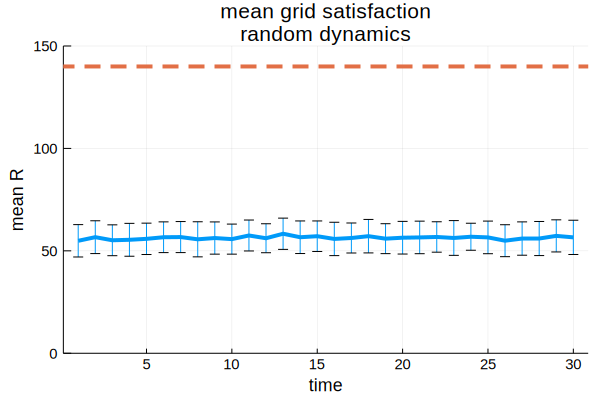

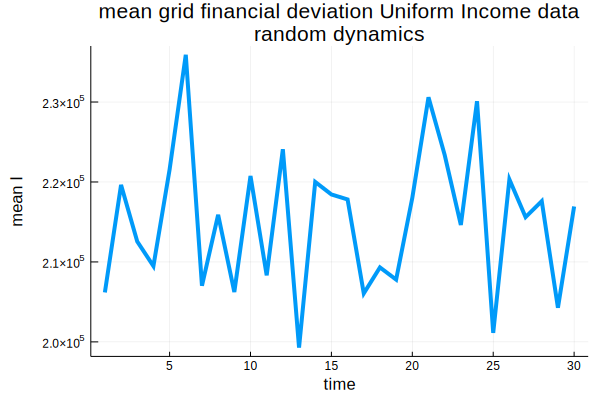

In [75]:
#mean and variance of the no dynamics trajectory UNIFORM INCOME DATA
simulationRvals_uniform_multi = zeros(TT,MM)
simulationIvals_uniform_multi = zeros(TT,MM)
for mm in 1:MM       
    traceR = zeros(TT)
    traceI = zeros(TT)
    for tt in 1:TT 
        if(tt==1)
            moneyGrid = make_uniform_sampled_finance_grid()  
        else
            moneyGrid =  move_cells_for_wealth_NoDynamics(moneyGrid) #make_random_finance_grid()  
        end    
        traceR[tt] = grid_satisfaction(moneyGrid[:,:,1])
        traceI[tt] = financial_grid_deviation(moneyGrid)   
    end
    simulationRvals_uniform_multi[:,mm] = traceR[:]
    simulationIvals_uniform_multi[:,mm] = traceI[:]
end
    
plt = plot(mean(simulationRvals_uniform_multi,dims=2),xlabel="time",ylabel="mean R",yerr=std(simulationRvals,dims=2),
    linewidth=4,ylim=(0,R_MAX+10),title="mean grid satisfaction \n random dynamics",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
hline!([R_MAX],line=(4,:dash),leg=false)
display(plt)
savefig(plt,newFigNameString())

plt = plot(mean(simulationIvals_uniform_multi,dims=2),xlabel="time",ylabel="mean I",
    linewidth=4,
    title="mean grid financial deviation Uniform Income data \n random dynamics",
    leg=false) 
#hline!([uniformResidentIncomesMean],line=(4,:dash),leg=false)
display(plt)
savefig(plt,newFigNameString())

In [82]:
#2D SAMPLE FROM THE GENERATOR TO PRODUCE THE DISTRIBUTION FOR NO DYNAMICS FROM UNIFORM DATA
#will be used for the entropy
SAMPLE_NUM_2D_UNIFORM_INIT = 500
traceR_2d = []
traceI_2d = []

INTERVAL_I = 10000
#get the range for the income bines from the uniform data
randomUniformDataDeviationsBins = sort(Int.(round.(randomUniformDataDeviations ./ INTERVAL_I) * 1))
maxBinI = maximum(randomUniformDataDeviationsBins) 
extraIbins = 20
counts_2D_init_uniform = ones(maxBinI + extraIbins,R_MAX);

I_BIN_NUM = maxBinI + extraIbins

for tt in 1:SAMPLE_NUM_2D_UNIFORM_INIT   #TT*MM             
    moneyGrid = make_uniform_sampled_finance_grid()      
    append!(traceR_2d, Int(grid_satisfaction(moneyGrid[:,:,1])) )
    append!(traceI_2d, Int(round(financial_grid_deviation(moneyGrid) / INTERVAL_I) * 1) )    
    counts_2D_init_uniform[traceI_2d[end],traceR_2d[end]] += 1    
end
traceI_2d = Int.(traceI_2d)
traceR_2d = Int.(traceR_2d);
counts_2D_init_uniformNorm = counts_2D_init_uniform ./ sum(counts_2D_init_uniform);

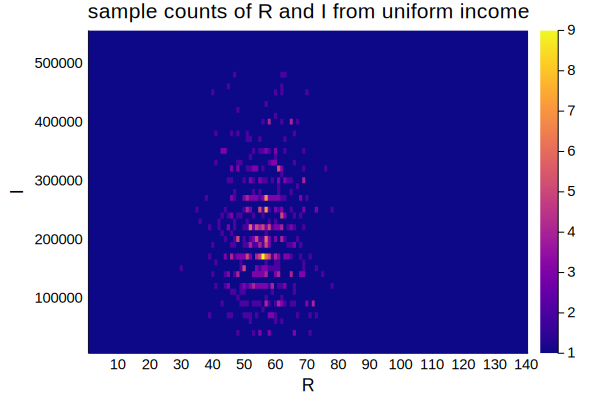

In [83]:
incomeTicks = string.(collect(10:10:size(counts_2D_init_uniform)[1]) .* INTERVAL_I)
h = heatmap(counts_2D_init_uniform,title="sample counts of R and I from uniform income",
        showaxis=true,#    yticks=(yt,yt2 .* "!"),#(collect(minimum(traceI) : 10000 : maximum(traceI))),
        xlabel="R",ylabel="I",fc=:plasma,#xlims=(0.5,xrange+0.5),
        xtickfont=10,ytickfont=10,titlefont=14,guidefont=12,
        xticks=10:10:R_MAX,
        yticks=((10:10:size(counts_2D_init_uniform)[1]),incomeTicks))
display(h)  
savefig(h,newFigNameString())


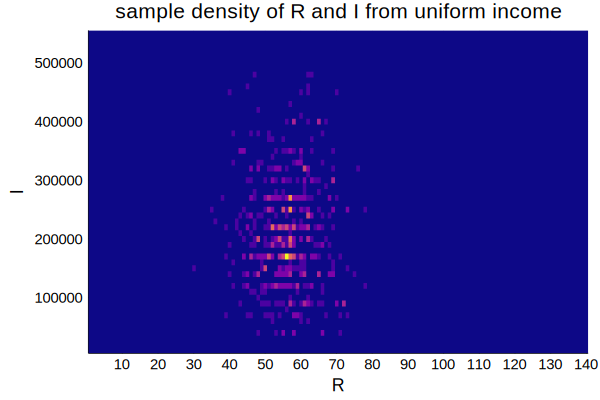

1.0000000000000007


In [84]:
println(sum(counts_2D_init_uniformNorm))
h = heatmap(counts_2D_init_uniformNorm,title="sample density of R and I from uniform income",
        showaxis=true,#    yticks=(yt,yt2 .* "!"),#(collect(minimum(traceI) : 10000 : maximum(traceI))),
        xlabel="R",ylabel="I",fc=:plasma,#xlims=(0.5,xrange+0.5),
        xtickfont=10,ytickfont=10,titlefont=14,guidefont=12,
        xticks=10:10:R_MAX,leg=false,
        yticks=((10:10:size(counts_2D_init_uniform)[1]),incomeTicks))
display(h)  
savefig(h,newFigNameString())

In [85]:
#ENTROPY 2D from the densities and the total count size
sampleOmega_I_R = BigFloat.(zeros(size(counts_2D_init_uniformNorm)[1],size(counts_2D_init_uniformNorm)[2]))
entropyVals_I_R = BigFloat.(zeros(size(sampleOmega_I_R)[1],size(sampleOmega_I_R)[2]))

#return the entropy value for the 2D spatial arrangement that has I and R as the macrostate positioning
function S_entropy_values_from_IandR(I,R)
    return BigFloat( BigFloat(K_B) * log(BigFloat(sampleOmega_I_R[I,R])) )
end

for i in 1:size(sampleOmega_I_R)[1]
    for r in 1:size(sampleOmega_I_R)[2]        
        sampleOmega_I_R[i,r] = BigFloat(counts_2D_init_uniformNorm[i,r]) * BigFloat(CELLS_SPACE_SIZE_2D)
        entropyVals_I_R[i,r] = S_entropy_values_from_IandR(i,r)
    end
end
println(maximum(sampleOmega_I_R))
println(minimum(sampleOmega_I_R))
println(maximum(entropyVals_I_R))
println(minimum(entropyVals_I_R))
println(typeof(maximum(entropyVals_I_R) - minimum(entropyVals_I_R)))


9.659675064269120783404915960898905033503587580251129692010488641918251646481331e+13366255
1.07329722936323553657717132958876470664844574886375008791305619299188981613154e+13366255
4.249215389177700427513721744450760535885228033920627570503384204272235188560092e-16
4.249215085818108880045904971312723712259831281036567649510821195482733392179135e-16
BigFloat


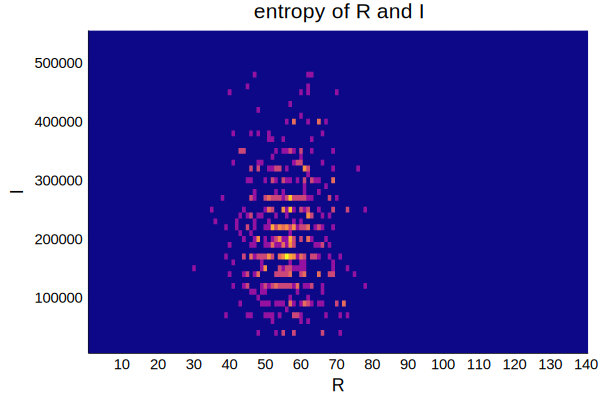

In [86]:
#heatmap of the entropy values
h = heatmap(entropyVals_I_R,title="entropy of R and I",
        showaxis=true,#    yticks=(yt,yt2 .* "!"),#(collect(minimum(traceI) : 10000 : maximum(traceI))),
        xlabel="R",ylabel="I",fc=:plasma,#xlims=(0.5,xrange+0.5),
        xtickfont=10,ytickfont=10,titlefont=14,guidefont=12,
        xticks=10:10:R_MAX,leg=false,
        yticks=(10:10:size(entropyVals_I_R)[1],incomeTicks))
display(h)  
savefig(h,newFigNameString())


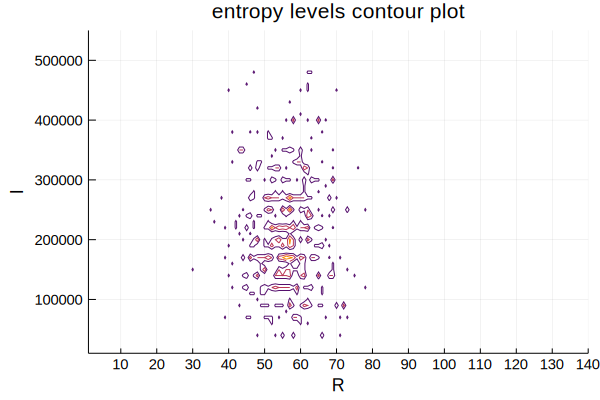

In [87]:
#Uniform data sample entropy contour plot
entropyLookUp(R,I) = entropyVals_I_R[I,R]
xx=collect(1:R_MAX)
yy=collect(1:size(entropyVals_I_R)[1])
plt = contour(xx,yy,entropyLookUp(xx,yy),levels=3 , xlabel="R",ylabel="I",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12,leg=false,
    xticks=10:10:R_MAX,
    yticks=(10:10:size(entropyVals_I_R)[1],incomeTicks))
title!("entropy levels contour plot")
display(plt)
savefig(plt,newFigNameString())

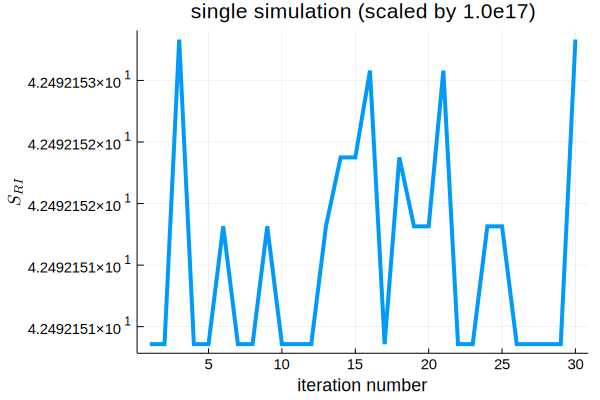

In [88]:
#find the entropy of a trace given the datastructure visualized in the heatmap (SINGLE SIMULATION)
#entropyVals_I_R is the data structure for the 2D look up
traceI_uni_single_inds = Int.(round.(traceI_uni_single ./ INTERVAL_I))  
traceR_uni_single_inds = Int.(traceR_uni_single)
entropy_trace_uni_single = [entropyVals_I_R[traceI_uni_single_inds[x],traceR_uni_single_inds[x]] for x in 1:length(traceR_uni_single_inds)]
scale = 10e16
entropy_trace_uni_single_scaled = scale .* entropy_trace_uni_single 

plt = plot(entropy_trace_uni_single_scaled,    
    linewidth=4,
        xlabel="iteration number",
    title="single simulation (scaled by $(scale))",
    leg=false,ylabel=L"S_{RI}",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
#yticks=([minimum(entropy_trace_uni_single_min_sub),maximum(entropy_trace_uni_single_min_sub)],[eLabels[1],eLabels[2]]) )
display(plt)
savefig(plt,newFigNameString())


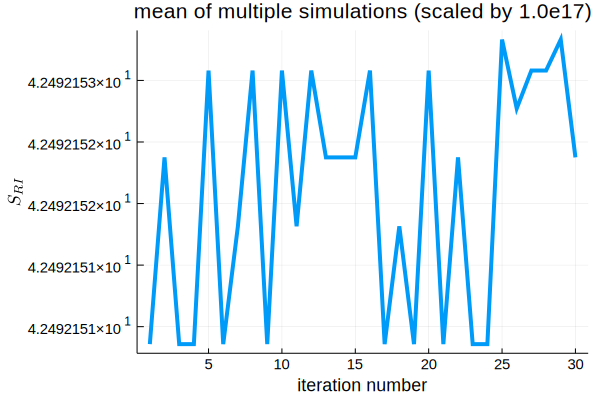

In [89]:
meanRtraceUni = mean(simulationRvals_uniform_multi,dims=2)
meanItraceUni = mean(simulationIvals_uniform_multi,dims=2)
traceI_uni_multi_inds = Int.(round.(meanItraceUni ./ INTERVAL_I))  
traceR_uni_multi_inds = Int.(round.(meanRtraceUni))
entropy_trace_uni_multi = [entropyVals_I_R[traceI_uni_multi_inds[x],traceR_uni_multi_inds[x]] for x in 1:length(traceR_uni_multi_inds)]
scale = 10e16
entropy_trace_uni_multi_scaled = scale .* entropy_trace_uni_multi 

plt = plot(entropy_trace_uni_multi_scaled,    
    linewidth=4,
        xlabel="iteration number",
    title="mean of multiple simulations (scaled by $(scale))",
    leg=false,ylabel=L"S_{RI}",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
#yticks=([minimum(entropy_trace_uni_single_min_sub),maximum(entropy_trace_uni_single_min_sub)],[eLabels[1],eLabels[2]]) )
display(plt)
savefig(plt,newFigNameString())

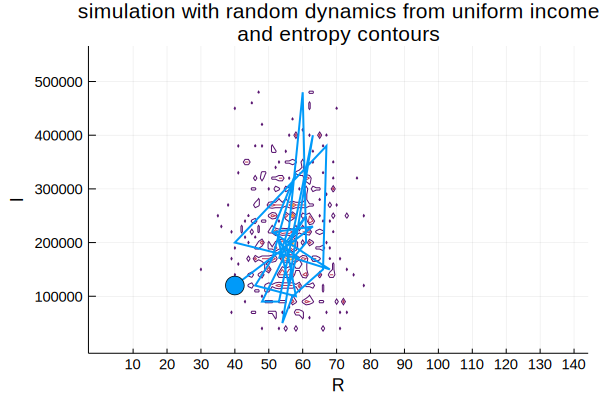

In [90]:
#Uniform data sample entropy contour plot with the single path of uniform!
cc = get_color_palette(:auto, plot_color(:white), 17)[1]

entropyLookUp(R,I) = entropyVals_I_R[I,R]
xx=collect(1:R_MAX)
yy=collect(1:size(entropyVals_I_R)[1])
plt = contour(xx,yy,entropyLookUp(xx,yy),levels=3 , xlabel="R",ylabel="I",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12,leg=false,
    xticks=10:10:R_MAX,
    yticks=(10:10:size(entropyVals_I_R)[1],incomeTicks))
title!("simulation with random dynamics from uniform income \n and entropy contours")

traceI_uni_single_tmp = Int.(round.(traceI_uni_single ./ INTERVAL_I) * 1) 
plot!(traceR_uni_single,traceI_uni_single_tmp,line=:path,linewidth=2,color=cc)
scatter!([traceR_uni_single[1]],[traceI_uni_single_tmp[1]],color=cc,markersize = 10)
    
display(plt)
savefig(plt,newFigNameString())


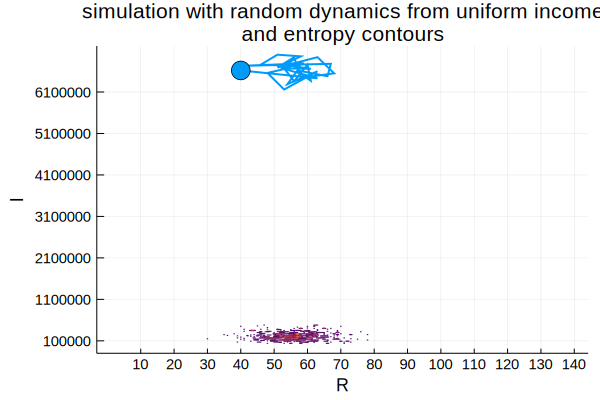

700


In [93]:
#plot the real income data trace in 2D with the init samples
traceI_real_single_tmp = Int.(round.(traceI_real_single ./ INTERVAL_I) * 1) 
endTick = maximum( [size(counts_2D_init_uniform)[1], maximum(traceI_real_single_tmp)] )
endTick = Int.( round(endTick / 100) * 100)
println(endTick)
incomeTicksReal = string.(collect(10:100:endTick) .* INTERVAL_I)

plt = contour(xx,yy,entropyLookUp(xx,yy),levels=3 , xlabel="R",ylabel="I",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12,leg=false,
    xticks=10:10:R_MAX,
    yticks=(10:100:endTick,incomeTicksReal))
title!("simulation with random dynamics from uniform income \n and entropy contours")

plot!(traceR_uni_single,traceI_real_single_tmp,line=:path,linewidth=2,color=cc)
scatter!([traceR_uni_single[1]],[traceI_real_single_tmp[1]],color=cc,markersize = 10)
    
display(plt)
savefig(plt,newFigNameString())


In [287]:
#--------------
#update the wealth of the cell surroundings
#RESIDENTIAL REDISTRIBUTION DYNAMICS!!!
#use < function cell_surround_radiate_financialRandomUniformNew(grid,row,col) >
function cell_surround_array_financial_UpdateNew2(gridFull,row,col,third,incrementAr)    
    ind = 1
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || 
                        (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                if( abs(gridFull[row-1+(ii),(col-1)+(jj),1]) == 1)
                    gridFull[row-1+(ii),(col-1)+(jj),third] += incrementAr[ind]
                    ind += 1
                end
            end
        end
    end   
    return gridFull
end

function cell_surround_radiate_financialRandomUniformNew2(grid,row,col)
    if( grid[row,col,1] == 0 )
        return
    end
    #cell_surrounding = cell_surround_array_grid(grid,row,col,1)    
    cell_surrounding = cell_surround_arrayTMP_financial(grid,row,col,1) 
    
    neighborNum = Int(sum(abs.(cell_surrounding)))    
    if(neighborNum > 4)
    #newWealth = round.(  grid[row,col,2] * (1-0.01*neighborNum)  )
    newWealth = round.(grid[row,col,2] * 0.995)#(1-0.01*neighborNum))#rand()) #random percentage of number of dollars off the wealth
    radiate = round.(grid[row,col,2] - newWealth) #how much is radiated on the surrounding residents        
    
    
    #!!!KEY TO THE DYNAMICS!!! THIS IS EFFECTIVELY THE REDISTRIBUTION MODEL!!!!<<<<
    rTmp = ones(neighborNum)#rand(neighborNum) 
    rTmpNorm = rTmp ./ sum(rTmp) 
    radiateDist = Int.(round.(radiate .* rTmpNorm))
    
    #residual = sum(radiateDist) - radiate
    #radiateDist[rand(1:neighborNum)] += residual    
    
    grid = cell_surround_array_financial_UpdateNew2(grid,row,col,2,radiateDist)    
    grid[row,col,2] = Int(newWealth) 
    end
    return grid
end

#RANDOM MOVEMENT NO SHELLING, ONLY WEALTH RADIATION DYNAMICS
function move_cells_for_wealth_DynamicsOnly(grid)        
    nonZeroCells = findall(grid[:,:,1] .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)            
    for nzc in nonZeroCells2 
        emptyCells = findall(grid[:,:,1] .== 0)
        emptyCells2 = shuffle(emptyCells)
        ec = emptyCells2[1]
       
        grid[ec[1],ec[2],1] = grid[nzc[1],nzc[2],1]
        grid[nzc[1],nzc[2],1] = 0                        
        grid[ec[1],ec[2],2] = grid[nzc[1],nzc[2],2]
        grid[nzc[1],nzc[2],2] = 0 
        
        #RADIATE THE FINANCE randomly on the surroundings of the 'ec' which was empty but now nzc (nonzero)                
        grid = cell_surround_radiate_financialRandomUniformNew2(grid,ec[1],ec[2])                 
    end          
    return grid
end

move_cells_for_wealth_DynamicsOnly (generic function with 1 method)

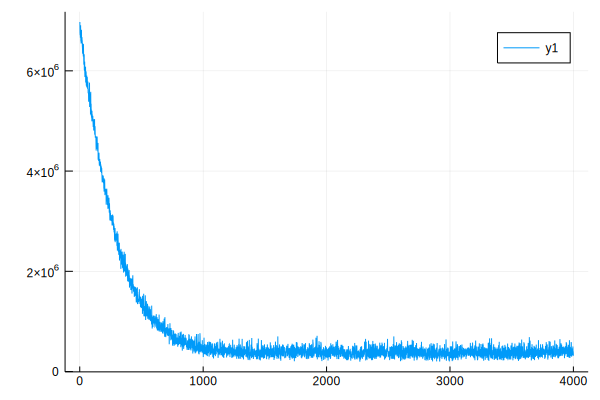

In [289]:
#simulate movement with no dynamics and track both the macrostates variables REAL INCOME DATA
TT=4000
traceR_real_single_Ionly = zeros(TT)
traceI_real_single_Ionly = zeros(TT)
#moneyGrid = make_uniform_sampled_finance_grid()# make_random_finance_grid() # 
moneyGrid = make_random_finance_grid() # 
trace2D_Ionly = [] #stores the tuples of the trace 2D coordinates
sumI = []
maxI = []
minI = []
for tt in 1:TT
    #println(tt)
    if(tt==1)
        #moneyGrid = make_uniform_sampled_finance_grid()# make_random_finance_grid()# 
        moneyGrid = make_random_finance_grid()
        
    else #move_cells_for_wealth_NoDynamics(moneyGrid)#
        moneyGrid = move_cells_for_wealth_DynamicsOnly(moneyGrid) 
    end        
    traceR_real_single_Ionly[tt] = grid_satisfaction(moneyGrid[:,:,1])
    traceI_real_single_Ionly[tt] = financial_grid_deviation(moneyGrid)
    append!(sumI, sum(moneyGrid[:,:,2]))
    append!(maxI, maximum(moneyGrid[:,:,2]))
    append!(minI, minimum(moneyGrid[:,:,2]))
    
    if(tt==1)
        trace2D_Ionly = (traceR_real_single_Ionly[tt],traceI_real_single_Ionly[tt])
    else
        trace2D_Ionly = vcat(trace2D_Ionly,[(traceR_real_single_Ionly[tt],traceI_real_single_Ionly[tt])])
    end  
    
    gridTmp = deepcopy(moneyGrid[:,:,2])
    inds = findall(gridTmp .== 0)    
    gridTmp[inds] .= NaN    
    #=
    h = heatmap(gridTmp,title="MAD income:$(round(traceI_real_single_Ionly[tt],digits=2))",
        showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,
        framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=true,
        c=ColorGradient([:blue,:green,:yellow]))    
    display(h)    
    savefig(h,"FigsV2/simulationSnapShots4/I_time$(tt).png")
    
    h = gridHeatMap(moneyGrid[:,:,1],"R=$(traceR_real_single_Ionly[tt])",false)
    display(h)    
    savefig(h,"FigsV2/simulationSnapShots4/R_time$(tt).png")
    =#
    
end
p=plot(traceI_real_single_Ionly)
display(p)
savefig(p,newFigNameString())


In [278]:
println(sumI)

println(maxI)

Any[7.24416e6, 7.24418e6, 7.2437e6, 7.24371e6, 7.24372e6, 7.24372e6, 7.24369e6, 7.24369e6, 7.24369e6, 7.24372e6, 7.24372e6, 7.24372e6, 7.24373e6, 7.24371e6, 7.2437e6, 7.24372e6, 7.24368e6, 7.24369e6, 7.24372e6, 7.24376e6, 7.24376e6, 7.24374e6, 7.24373e6, 7.24371e6, 7.24372e6, 7.24374e6, 7.24374e6, 7.24369e6, 7.24368e6, 7.24366e6, 7.24368e6, 7.24369e6, 7.24368e6, 7.24374e6, 7.24377e6, 7.24378e6, 7.24376e6, 7.2435e6, 7.24352e6, 7.24353e6, 7.24354e6, 7.24354e6, 7.24357e6, 7.2436e6, 7.24361e6, 7.24361e6, 7.24366e6, 7.24368e6, 7.24369e6, 7.24372e6, 7.24375e6, 7.24376e6, 7.24376e6, 7.24379e6, 7.24352e6, 7.24347e6, 7.24343e6, 7.2434e6, 7.24342e6, 7.24341e6, 7.24342e6, 7.24344e6, 7.24348e6, 7.24349e6, 7.24352e6, 7.24347e6, 7.24346e6, 7.24346e6, 7.24348e6, 7.24344e6, 7.24341e6, 7.24343e6, 7.24345e6, 7.24344e6, 7.24345e6, 7.24347e6, 7.24347e6, 7.24344e6, 7.24344e6, 7.24339e6, 7.24338e6, 7.24338e6, 7.24339e6, 7.24339e6, 7.24341e6, 7.24339e6, 7.24338e6, 7.24338e6, 7.24338e6, 7.24337e6, 7.24333e6, 

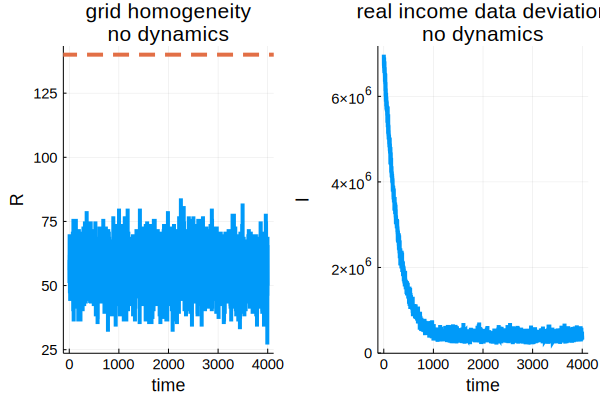

In [290]:
plt1 = plot(traceR_real_single_Ionly,linewidth=4,title="grid homogeneity \n no dynamics",
    xlabel="time",leg=false,ylabel="R",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
hline!([R_MAX],line=(4,:dash),leg=false)
p2 = plot(traceI_real_single_Ionly,linewidth=4,title="real income data deviation \n no dynamics",xlabel="time",
    leg=false,ylabel="I",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
#hline!([uniformResidentIncomesMean],line=(4,:dash),leg=false)
pboth = plot(plt1,p2)
display(pboth)
savefig(pboth,newFigNameString())

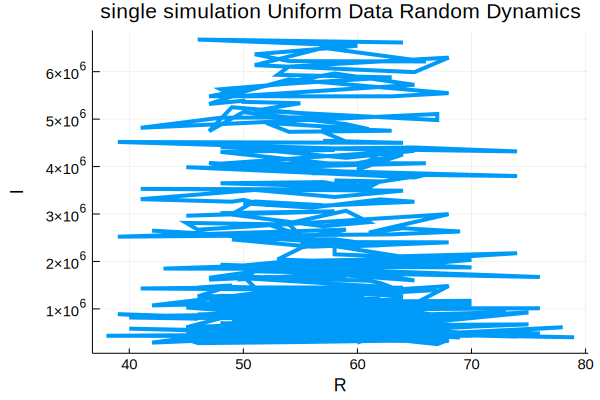

In [280]:
plt = plot(traceR_real_single_Ionly,traceI_real_single_Ionly,line=:path,linewidth=4,title="single simulation Uniform Data Random Dynamics",
    xlabel="R",leg=false,ylabel="I",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
display(plt)
savefig(plt,newFigNameString())

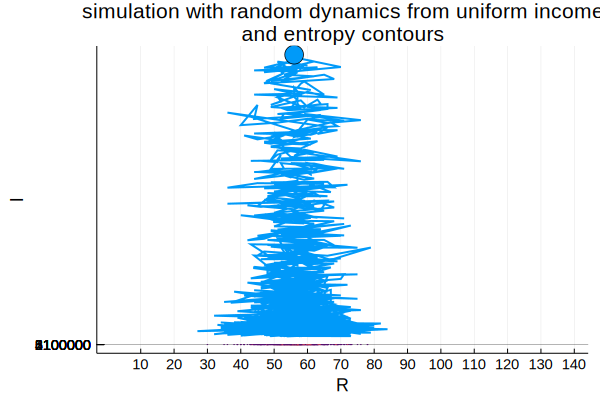

700


In [291]:

#entropyLookUp(R,I) = entropyVals_I_R[I,R]
xx=collect(1:R_MAX)
yy=collect(1:size(entropyVals_I_R)[1])

traceI_real_single_tmp = Int.(round.(traceI_real_single_Ionly ./ INTERVAL_I) * 1) 
endTick = maximum( [size(counts_2D_init_uniform)[1], maximum(traceI_real_single_tmp)] )
endTick = Int.( round(endTick / 100) * 100)
println(endTick)
incomeTicksReal = string.(collect(10:100:endTick) .* INTERVAL_I)

plt = contour(xx,yy,entropyLookUp(xx,yy),levels=3 , xlabel="R",ylabel="I",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12,leg=false,
    xticks=10:10:R_MAX,
    yticks=(10:100:endTick,incomeTicksReal))
title!("simulation with random dynamics from uniform income \n and entropy contours")

plot!(traceR_real_single_Ionly,traceI_real_single_Ionly,line=:path,linewidth=2,color=cc)
scatter!([traceR_real_single_Ionly[1]],[traceI_real_single_Ionly[1]],color=cc,markersize = 10)
    
display(plt)
savefig(plt,newFigNameString())


In [ ]:

#plot the trces for both the spatial and the INCOME DATA
plt1 = plot(traceR_real_single,linewidth=4,title="grid homogeneity \n random dynamics",
    xlabel="time",leg=false,ylabel="R",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
hline!([R_MAX],line=(4,:dash),leg=false)

p2 = plot(traceI_real_single,linewidth=4,title="income data deviation \n random dynamics",xlabel="time",
    leg=false,ylabel="I",
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
#hline!([meanRealSampleIncomeDeviations],line=(4,:dash),leg=false)

pboth = plot(plt1,p2)
display(pboth)
savefig(pboth,newFigNameString())
println(meanRealSampleIncomeDeviations)
println(uniformResidentIncomesMean)



In [75]:
#need random initializations as macrostate value distributions to produce counts of the values to
#counts for probabilities as 2D since the combination is inherent in the problem definition.
#macrostate density will be a 2D lookup in a matrix!



In [39]:
#randUniformWealthBracketSample()    make_uniform_sampled_finance_grid()  make_random_finance_grid()
#randomMoneyDeviationsUG = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]

#MACROSTATE SEPARATOR parameter manually fixed as a bin size
SEPBIN = 0.01
roundDigits = 2
maxValExtension = 1.75

#now sample deviations for the probability distribution to be produced for the entropy later
randomMoneyDeviations = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]
randomMoneyDeviations = round.(randomMoneyDeviations,digits=roundDigits)
#set the maximum macrostate counts to be 
maxDev = round(maxValExtension * maximum(randomMoneyDeviations),digits=roundDigits)
#rintln(maxDev)
moneyDeviationBins = collect(range(0,step=SEPBIN,stop=maxDev))
#println("moneyDeviationBins=",moneyDeviationBins)
#println("size of the moneyDeviationBins=",length(moneyDeviationBins))
#println(randomMoneyDeviations)
binsDevCounts = [length( findall( dev .== randomMoneyDeviations ) ) for dev in moneyDeviationBins]
replace!(binsDevCounts,0=>1)
binsDevCountsProb = binsDevCounts ./ sum(binsDevCounts)
#println("binsDevCountsProb=",binsDevCountsProb)
#println("size of the moneyDeviationBins=",length(binsDevCountsProb))
binsDev = collect( 0:SEPBIN:length(moneyDeviationBins) .* SEPBIN )

binsAndProbsMoney = hcat(moneyDeviationBins,binsDevCountsProb)
#println("binAndProbsMoney=",binsAndProbsMoney)

#DICT FOR THE WEALTH STATE PROB
dictBinsWealthDevProb = Dict(zip(binsDev,binsDevCountsProb));

#println(dictBinsWealthDevProb)
#println(dictBinsWealthDevProb[1.8])

#DICT FOR THE SAMPLE SPACE
sampleOmegaWD = binsDevCountsProb .* CELLS_SPACE_SIZE
#println(sampleOmegaW)
dictBinsWealthDevOmegaW = Dict(zip(binsDev,sampleOmegaWD));

#println(dictBinsWealthDevOmegaB)
#println(dictBinsWealthDevOmegaB[1.8])
#println(dictBinsWealthDevOmegaB[1.1])


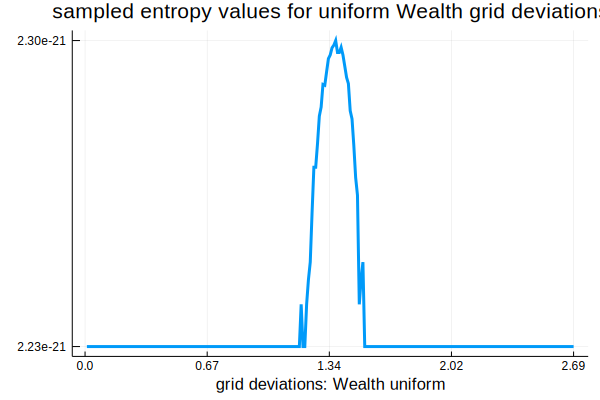

269
2.30e-212.23e-21


In [40]:

function S_entropy_values_from_WD(W)
    return k_b * log(sampleOmegaWD[W])
       
end

entropyValsW = [S_entropy_values_from_WD(W) for W in 1:length(moneyDeviationBins)]
println(length(entropyValsW))
#println((entropyValsW))

minStr = string(minimum(entropyValsW))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyValsW)) )
tmp2 = string(minimum(entropyValsW))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyValsW))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyValsW)) )
tmp2 = string(maximum(entropyValsW))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

strTmp0 = string(0*SEPBIN)
tmp0 = 0
strTmp1 = string(round( length(moneyDeviationBins)* 1/4  * SEPBIN,digits=2))
tmp1 = round( length(moneyDeviationBins)* 1/4,digits=2 )
strTmp2 = string(round( length(moneyDeviationBins)* 2/4  * SEPBIN,digits=2))
tmp2 = round( length(moneyDeviationBins)* 2/4,digits=2 ) 
strTmp3 = string(round( length(moneyDeviationBins)* 3/4  * SEPBIN,digits=2))
tmp3 = round( length(moneyDeviationBins)* 3/4,digits=2 )
strTmp4 = string(length(moneyDeviationBins)*SEPBIN)
tmp4 = length(moneyDeviationBins)

pltSW = plot(1:length(moneyDeviationBins),entropyValsW,
    yticks=([minimum(entropyValsW),maximum(entropyValsW)],[labelMin,labelMax]),
    xticks=([0 tmp1 tmp2 tmp3 tmp4],
        [strTmp0 strTmp1 strTmp2 strTmp3 strTmp4]),
    ylim=(minimum(entropyValsW)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyValsW)),
    linewidth=3,title="sampled entropy values for uniform Wealth grid deviations",xlabel="grid deviations: Wealth uniform",
    leg=false)

display(pltSW)
savefig(pltSW,"figs/entropyWdistribution.png")


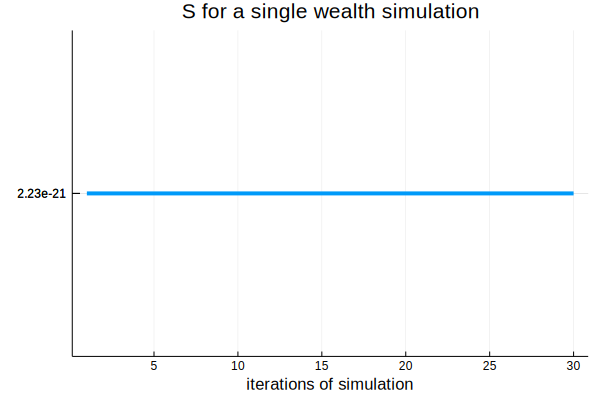

BigFloat[2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21, 2.231e-21]
2.23e-212.23e-21
2.29e-21

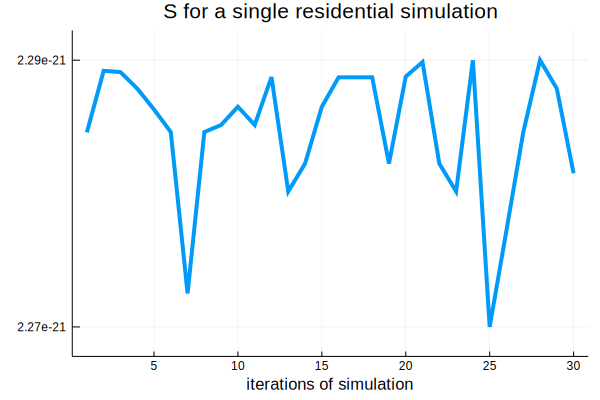

2.27e-21


In [41]:
#entropyValsW hold the values of the bins of the accuracy of increments in steps of SEPBIN
#So for the trajectory of the wealth produce an entropy trace

#println(traceWD)

traceWDrnd = round.(traceWD,digits=2)
indsEntropy = map(x->findfirst(x .== binsDev),traceWDrnd)
entropyTraceW = entropyValsW[indsEntropy]


println(entropyTraceW)

function S_entropy_values_from_R(R)
    return k_b * log(sampleOmegaR[R])
       
end

minStr = string(minimum(entropyTraceW))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyTraceW)) )
tmp2 = string(minimum(entropyTraceW))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyTraceW))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyTraceW)) )
tmp2 = string(maximum(entropyTraceW))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt5 = plot(entropyTraceW,
    yticks=([minimum(entropyTraceW),maximum(entropyTraceW)],[labelMin,labelMax]),
    ylims=(minimum(entropyTraceW)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyTraceW)),
    linewidth=4,title="S for a single wealth simulation",xlabel="iterations of simulation",leg=false)
display(plt5)
savefig(plt5,"figs/entropyWsingleTrace.png")

#now for the residential entropy trace
traceSv = [ S_entropy_values_from_R(Int(rr)) for rr in traceR]

minStr = string(minimum(traceSv))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(traceSv)) )
tmp2 = string(minimum(traceSv))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(traceSv))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(traceSv)) )
tmp2 = string(maximum(traceSv))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt5 = plot(traceSv,
    yticks=([minimum(traceSv),maximum(traceSv)],[labelMin,labelMax]),
    ylims=(minimum(traceSv)*(1-(10^-3)),(1 + 10^-3)*maximum(traceSv)),
    linewidth=4,title="S for a single residential simulation",xlabel="iterations of simulation",leg=false)
display(plt5)
savefig(plt5,"figs/entropyRsingleTrace.png")

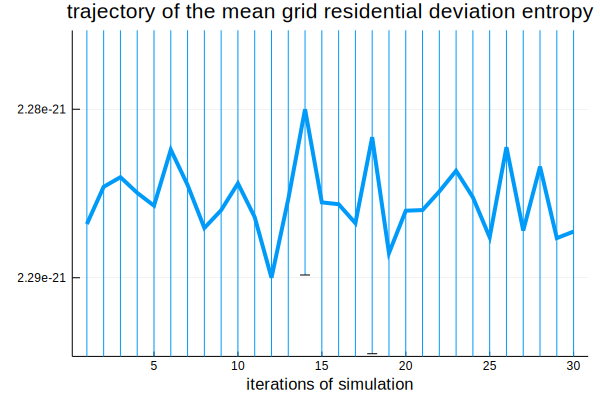

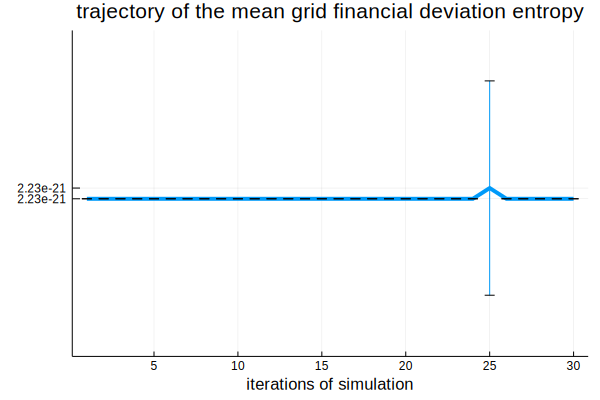

In [42]:
#now the wealth and spatial deviations from a batch simulation

simulationRvalsEntropy = zeros(TT,MM)
simulationWvalsEntropy = zeros(TT,MM)

function entropyTraceWDhelper(wdArray)
    traceWDrnd = round.(wdArray,digits=2)
    indsEntropy = map(x->findfirst(x .== binsDev),traceWDrnd)
    entropyTraceW = entropyValsW[indsEntropy]
    return entropyTraceW
end

function labelMaxMinEntropy(trace)
    minStr = string(minimum(trace))[1:4] 
    tmp = findfirst( isequal('e') , string(minimum(trace)) )
    tmp2 = string(minimum(trace))[tmp:end]
    labelMin = string(minStr,tmp2)
    maxStr = string(maximum(trace))[1:4] 
    tmp = findfirst( isequal('e') , string(maximum(trace)) )
    tmp2 = string(maximum(trace))[tmp:end]
    labelMax = string(maxStr,tmp2)
    return labelMax,labelMin
end

for i in 1:TT
    for j in 1:MM       
        simulationRvalsEntropy[i,j] = S_entropy_values_from_R(Int(simulationRvals[i,j] ))
        simulationWvalsEntropy[i,j] = entropyTraceWDhelper(simulationWvals[i,j])
    end
end



tmp = labelMaxMinEntropy(mean(simulationRvalsEntropy,dims=2))
labelMin,labelMax = tmp[1],tmp[2]
plt5 = plot(mean(simulationRvalsEntropy,dims=2),
    yticks=([minimum(mean(simulationRvalsEntropy,dims=2)),maximum(mean(simulationRvalsEntropy,dims=2))],
        [labelMin,labelMax]),yerr=std(simulationRvalsEntropy,dims=2),
    ylims=(minimum(mean(simulationRvalsEntropy,dims=2))*(1-(10^-3)),(1 + 10^-3)*maximum(mean(simulationRvalsEntropy,dims=2))),
    linewidth=4,title="trajectory of the mean grid residential deviation entropy",xlabel="iterations of simulation",leg=false)
display(plt5)
savefig(plt5,"figs/trajectoryMeanGridSatisfactionResidencyEntropy.png")

tmp = labelMaxMinEntropy(mean(simulationWvalsEntropy,dims=2))
labelMin,labelMax = tmp[1],tmp[2]
plt5 = plot(mean(simulationWvalsEntropy,dims=2),
    yticks=([minimum(mean(simulationWvalsEntropy,dims=2)),maximum(mean(simulationWvalsEntropy,dims=2))],
        [labelMin,labelMax]),yerr=std(simulationWvalsEntropy,dims=2),
        ylims=(minimum(mean(simulationWvalsEntropy,dims=2))*(1-(10^-3)),(1 + 10^-3)*maximum(mean(simulationWvalsEntropy,dims=2))),
    linewidth=4,title="trajectory of the mean grid financial deviation entropy",xlabel="iterations of simulation",leg=false)
display(plt5)
savefig(plt5,"figs/meanTrajFinancialDeviationEntropy.png")

In [43]:
#------------------------Financial Dynamics Now---------------------#
#------------------------Random moves with Financial 'Spending'-----#

In [44]:
#now there is the residential and the wealth entropy traces up to this point!
#from this point onwards... what needs to be done?
#Change the residential and wealth dynamics to now have the simulation components of expected changes

#has the non-uniform wealth samples so that the radiation makes it more uniform
moneyGrid2 = make_random_finance_grid()
#println(moneyGrid2)
tmp = cell_surround_arrayTMP_financial(moneyGrid2,1,2,2)
println(tmp)
tmp = cell_surround_arrayTMP_financial(moneyGrid2,1,2,1)
println(tmp)
println(sum(abs.(tmp)))

Any[0.0, 0.000326669, 0.00084934, 0.000457337, 0.000196002]
Any[0.0, -1.0, -1.0, -1.0, -1.0]
4.0


In [45]:
#get the cell surroundings
#pass the grid and provide the cell to get the surrounding finance or resident type array
#println(moneyGrid2)
moneyGrid2 = make_random_finance_grid()
function cell_surround_array_grid(gridFull,row,col,third)
    grid = gridFull[:,:,third]
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end
        end
    end
    return cell_surrounding
end
#=cell_surrounding = cell_surround_array_grid(moneyGrid2,11,11,1)   
println(cell_surrounding)
neighborNum = Int(sum(abs.(cell_surrounding)))
println(neighborNum)=#

cell_surround_array_grid (generic function with 1 method)

In [46]:
#pass the grid and provide the cell and the array of finance to increment/update the array
#does not update the center cell!
moneyGrid2 = make_random_finance_grid()
function cell_surround_array_financial_Update(gridFull,row,col,third,incrementAr)    
    ind = 1
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                if( abs(gridFull[row-1+(ii),(col-1)+(jj),1]) == 1)
                    gridFull[row-1+(ii),(col-1)+(jj),third] += incrementAr[ind]
                    ind += 1
                end
            end
        end
    end    
end
#=
for i in 1:13,j in 1:13
    total = Int(sum(abs.(cell_surround_array_grid(moneyGrid2,i,j,1) )))
    disp = Int.(round.(rand(total) .* 10 .+ 1) )
    tmp = cell_surround_array_financial_Update(moneyGrid2,i,j,2,disp)
    println(disp)
end
=#

cell_surround_array_financial_Update (generic function with 1 method)

In [47]:
#update the wealth of the cell surroundings
#RESIDENTIAL REDISTRIBUTION DYNAMICS!!!

function cell_surround_radiate_financialRandomUniform(grid,row,col)
    if( grid[row,col,1] == 0 )
        return
    end
    newWealth = rand() * grid[row,col,2] #take a random percentage off the wealth
    radiate = grid[row,col,2] - newWealth #how much is spent on the surroundings
    
    cell_surrounding = cell_surround_array_grid(grid,row,col,1)    
    neighborNum = Int(sum(abs.(cell_surrounding)))
    #println(neighborNum)
    
    #!!!KEY TO THE DYNAMICS!!! THIS IS EFFECTIVELY THE REDISTRIBUTION MODEL!!!!<<<<
    rTmp = rand(neighborNum)
    rTmpNorm = rTmp ./ sum(rTmp)
    radiateDist = radiate .* rTmpNorm       
    
    cell_surround_array_financial_Update(grid,row,col,2,radiateDist)
    
    grid[row,col,2] = newWealth 
    return grid
end
#cell_surround_radiate_financialRandomUniform(moneyGrid2,1,1)
#println(moneyGrid2[1:4,1:4,2])

cell_surround_radiate_financialRandomUniform (generic function with 1 method)

In [48]:
#now there is the grid and there has to be moves and wealth dynamics to show the model changes to 
#the entropy regarding the wealth only
#MOVEMENT NO SHELLING, ONLY WEALTH RADIATION
moneyGrid2 = make_random_finance_grid()

function move_cells_for_wealth_Dynamics1(grid)
    #grid = deepcopy(gridOrig)     
    nonZeroCells = findall(grid[:,:,1] .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)            
    for nzc in nonZeroCells2 
        emptyCells = findall(grid[:,:,1] .== 0)
        emptyCells2 = shuffle(emptyCells)
        ec = emptyCells2[1]
       
        grid[ec[1],ec[2],1] = grid[nzc[1],nzc[2],1]
        grid[nzc[1],nzc[2],1] = 0             
           
        grid[ec[1],ec[2],2] = grid[nzc[1],nzc[2],2]
        grid[nzc[1],nzc[2],2] = 0 
        
        #RADIATE THE FINANCE randomly on the surroundings of the 'ec' which was empty but now nzc (nonzero)
                
        cell_surround_radiate_financialRandomUniform(grid,ec[1],ec[2]) 
                
    end          
    #println(g2[:,:,1] == newGrid2[:,:,1])
    return grid
end
move_cells_for_wealth_Dynamics1(moneyGrid2)
println(sum(moneyGrid2))

2.0000000000000004


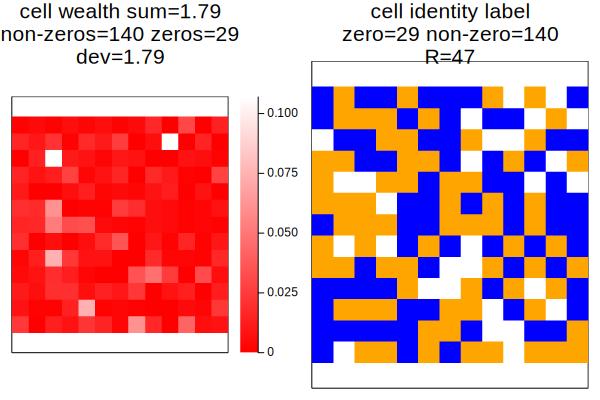

1
1.9999999999999998


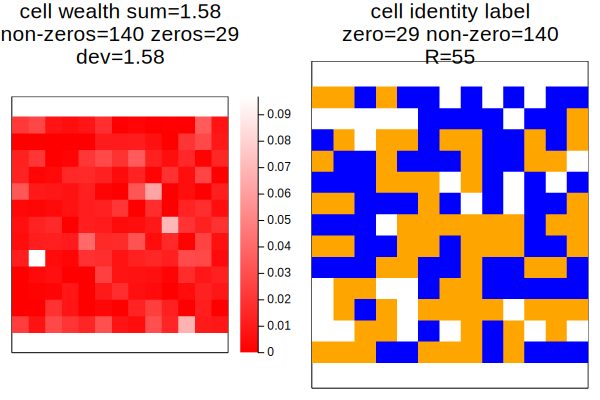

2
2.0
3

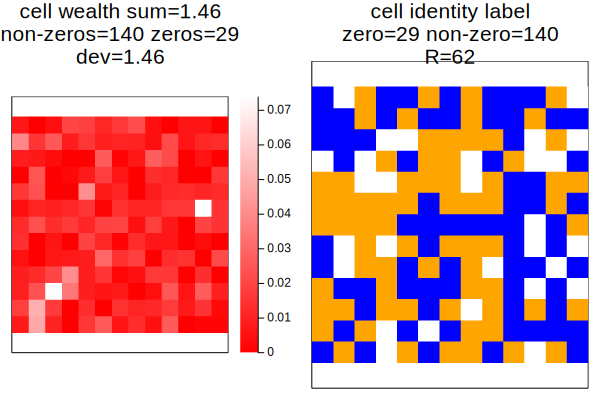


2.0


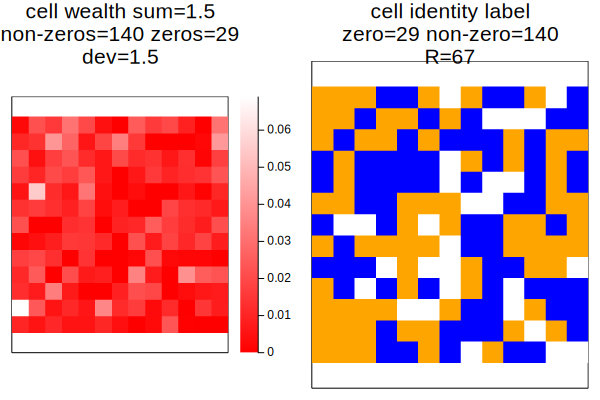

4
2.0
5

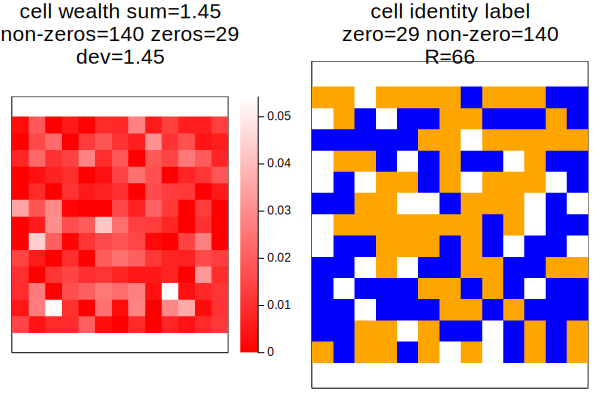


1.9999999999999996
6

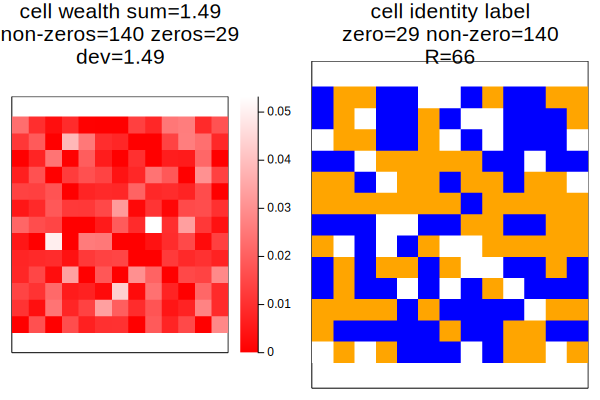


1.9999999999999998
7

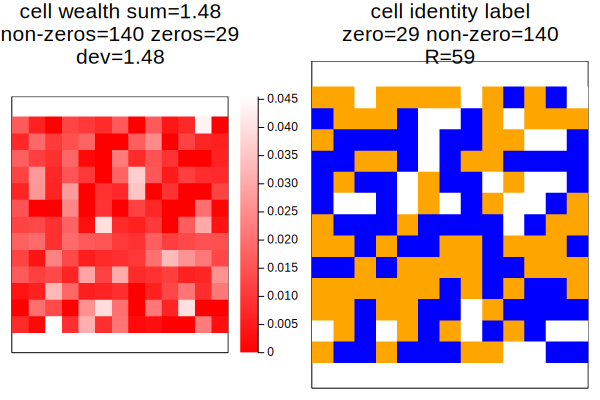


2.0


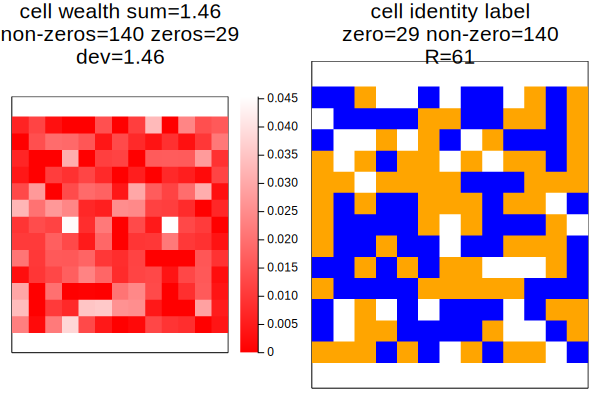

8
2.0000000000000004


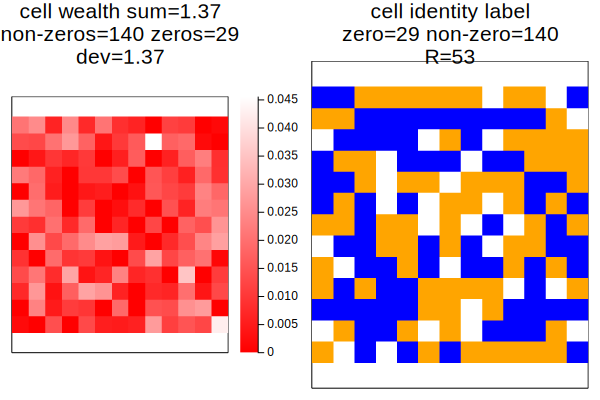

9
1.9999999999999998


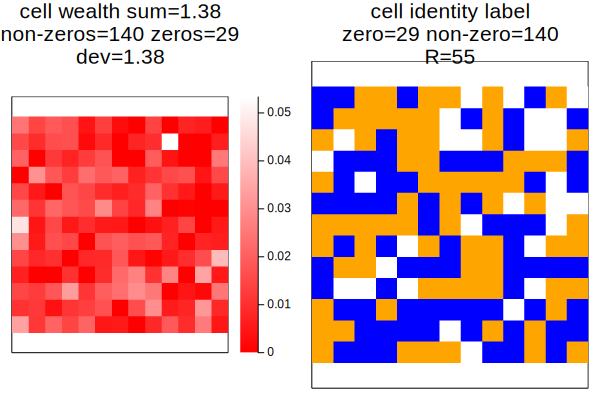

10
2.0
11

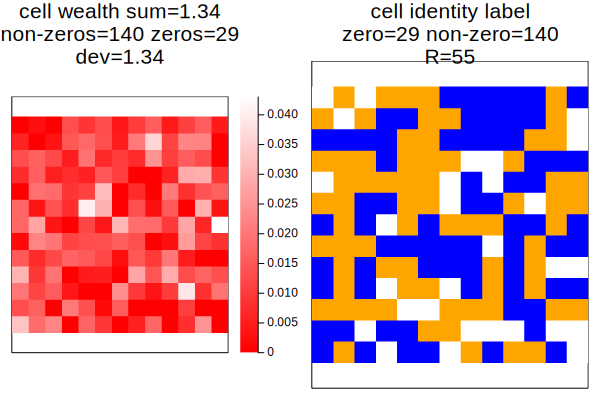


2.0


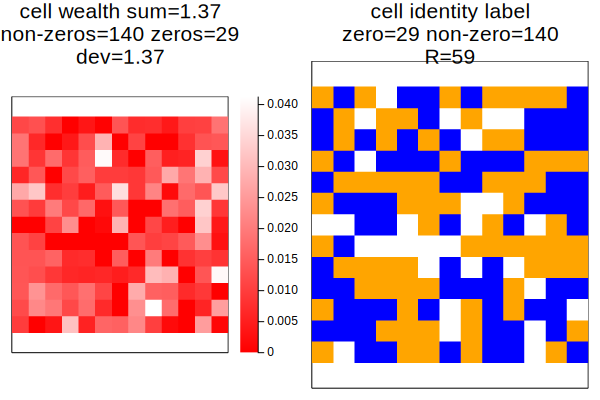

12
2.0
13

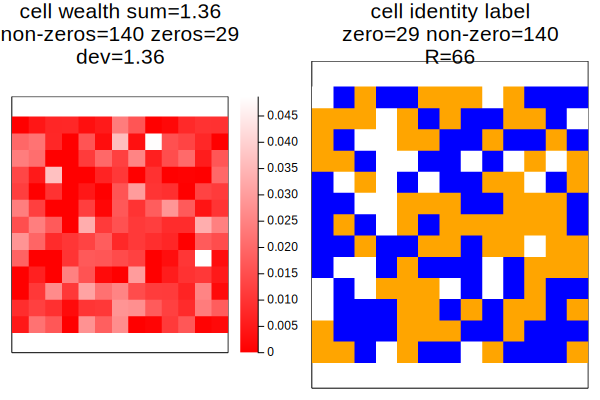


2.0


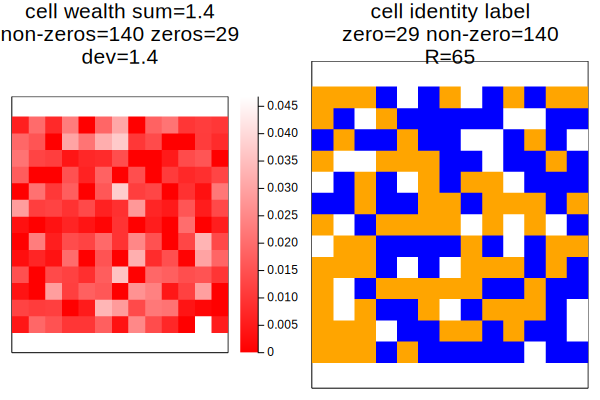

14
2.0
15

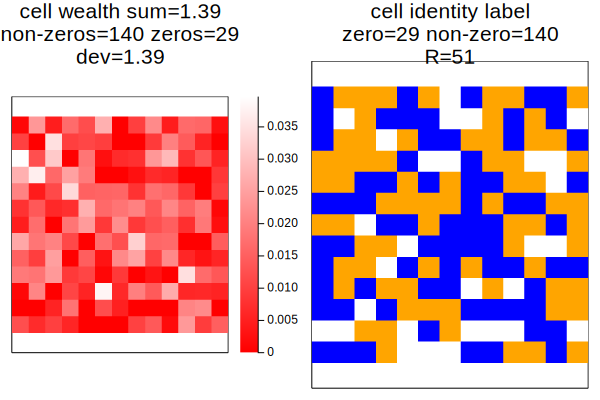


2.0


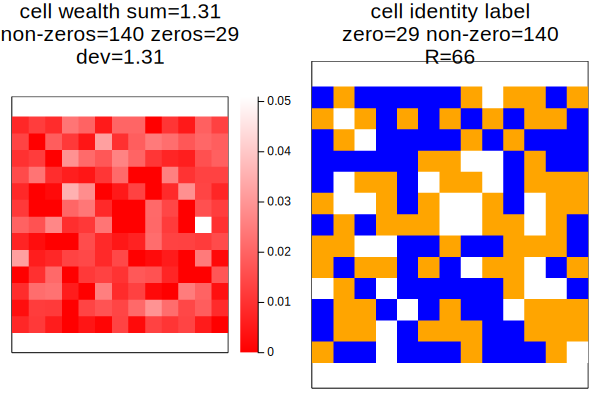

16
2.0000000000000004


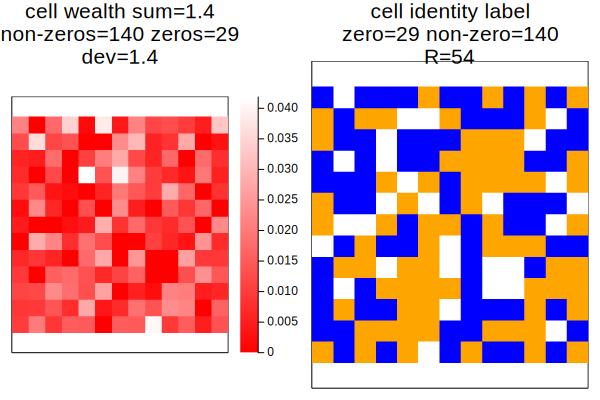

17
2.0
18

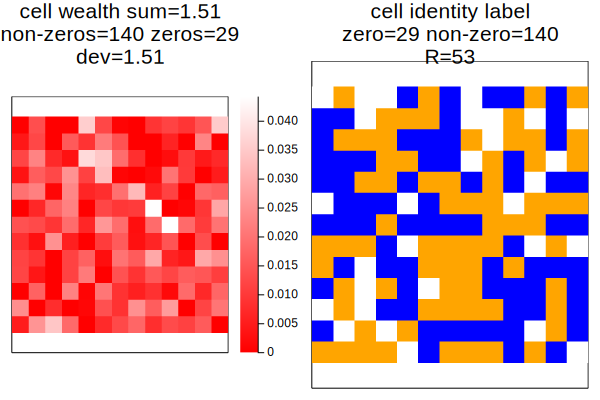


2.0


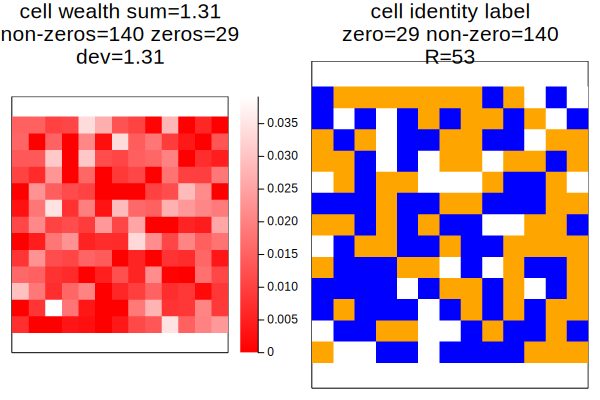

19
1.9999999999999998


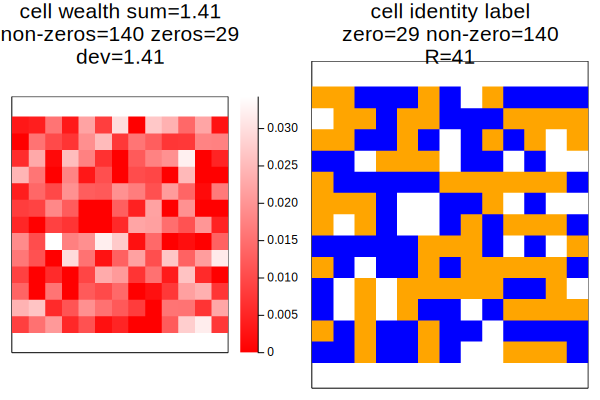

20
1.9999999999999998


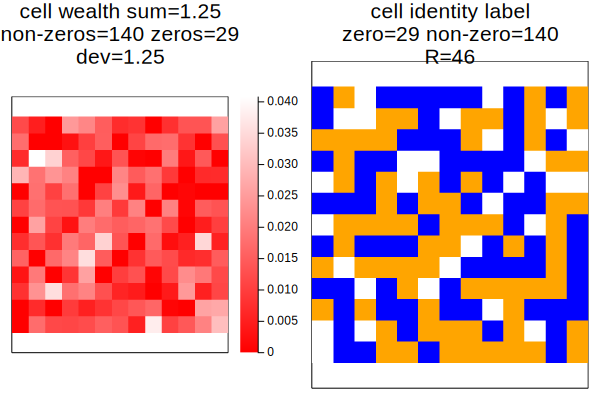

21
2.0
22

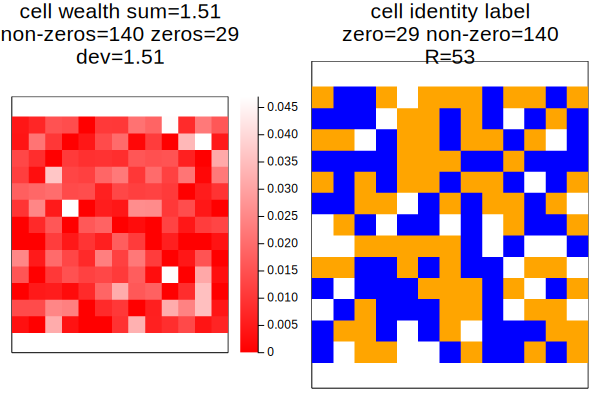


1.9999999999999998
23

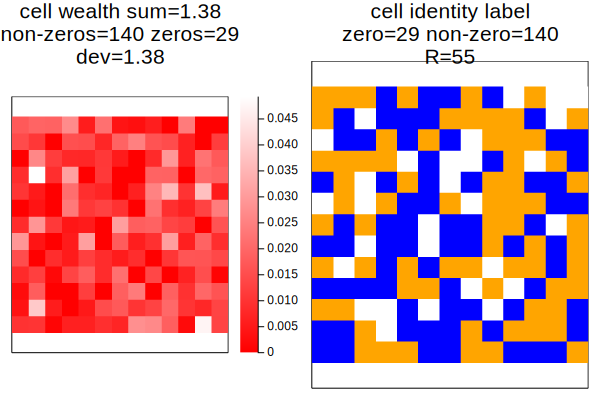


1.9999999999999998
24

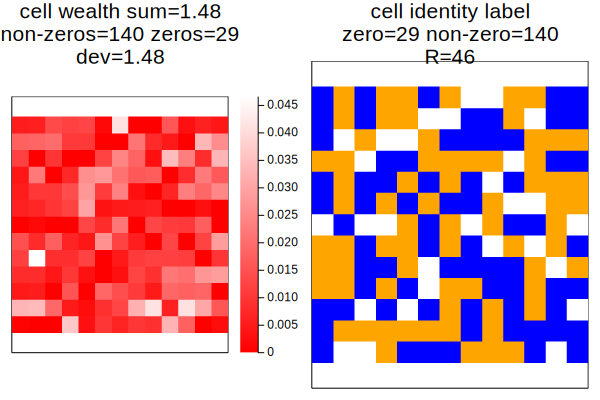


1.9999999999999998
25

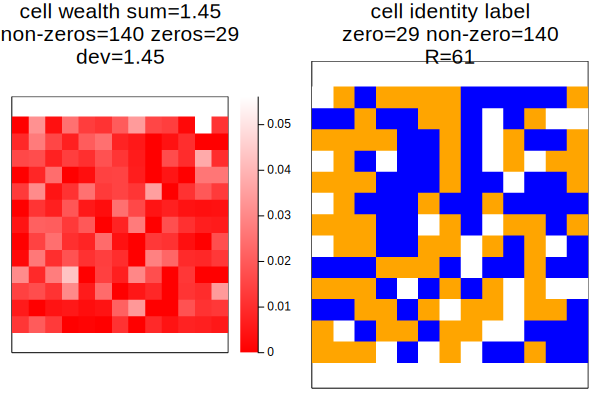


1.9999999999999998
26

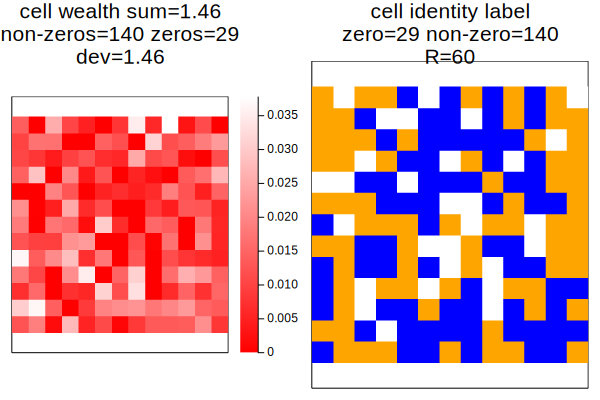


2.0


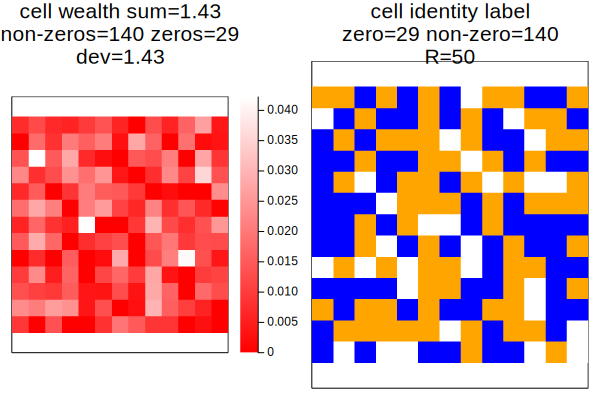

27
2.0
28

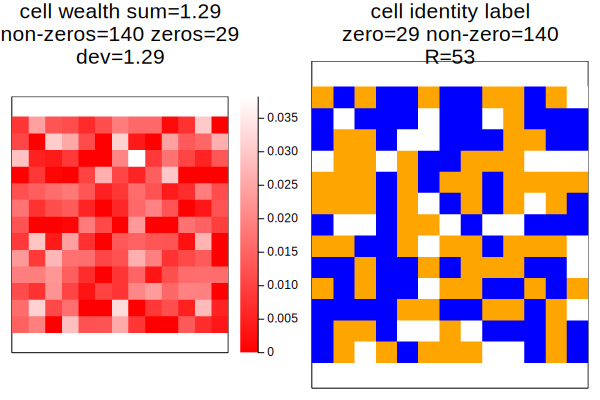


1.9999999999999996
29

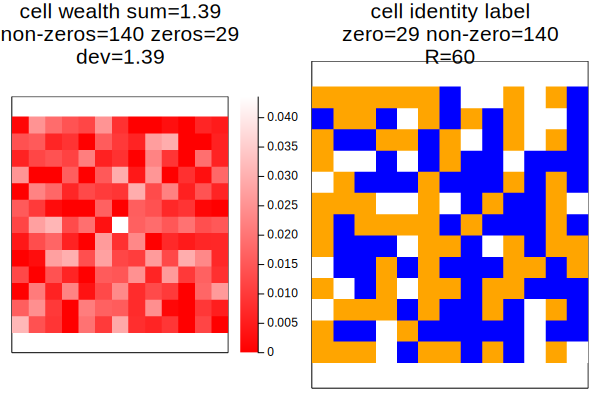


2.0


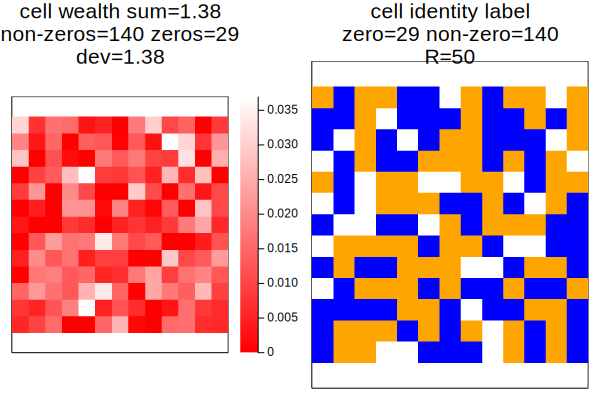

30
2.0


In [49]:
#now that the random moves, and financial dispersion is made... it is time to produce the entropy traces

traceR2 = zeros(TT)
traceWD2 = zeros(TT)
 
for tt in 1:TT   
    println(tt)
    if(tt==1)
        moneyGrid = make_random_finance_grid()  
    else
        moneyGrid =  move_cells_for_wealth_Dynamics1(moneyGrid) #make_random_finance_grid()  
    end          
    println(sum(moneyGrid[:,:,2]))
    traceR2[tt] = grid_satisfaction(moneyGrid[:,:,1])
    traceWD2[tt] = financial_grid_deviation(moneyGrid)
    wdevTmp = financial_grid_deviation(moneyGrid)
    Rtmp = grid_satisfaction(moneyGrid[:,:,1])
    tmp = round(sum(wdevTmp),digits=2)
    tmp2 = length(findall(moneyGrid[:,:,1] .!= 0))
    tmp2b = length(findall(moneyGrid[:,:,1] .== 0))
    tmp3 = length(findall(moneyGrid[:,:,2] .== 0))
    tmp4 = length(findall(moneyGrid[:,:,2] .!= 0))
    
    hm = heatmap(moneyGrid[:,:,2],title="cell wealth sum=$(tmp) \n non-zeros=$(tmp4) zeros=$(tmp3) \n dev=$(round(wdevTmp,digits=2))",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,
        framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=true,
    c=ColorGradient([:red,:white]))
    hm2 = heatmap(moneyGrid[:,:,1],title="cell identity label \n zero=$(tmp2b) non-zero=$(tmp2) \n R=$(Rtmp)",
        showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
        c=ColorGradient([:orange,:white,:blue]))

    p1=plot(hm,hm2)
    display(p1)
    savefig(hm,"figs/simulationSnapShots3/time$(tt).png")
end


In [50]:
randomMoneyDeviationsData = [ financial_grid_deviation(make_random_finance_grid()) for x in 1:numberOfRandomSamples]
randomMoneyDeviationsData = round.(randomMoneyDeviationsData,digits=roundDigits)
println(mean(randomMoneyDeviationsData))
randomMoneyDeviationsUniform = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]
randomMoneyDeviationsUniform = round.(randomMoneyDeviationsUniform,digits=roundDigits)
println(mean(randomMoneyDeviationsUniform))

1.8137649999999998
1.370155


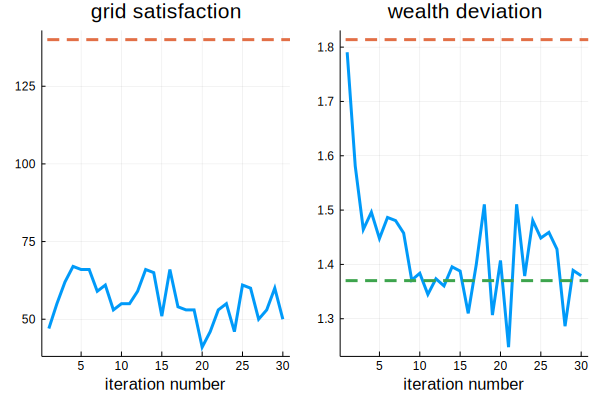

In [51]:
#now the trajectory of the simulation for the finance and the schelling must be done

p1 = plot(traceR2,linewidth=3,title="grid satisfaction",xlabel="iteration number")
hline!([R_MAX],line=(3,:dash),leg=false)
p2 = plot(traceWD2,linewidth=3,title="wealth deviation",xlabel="iteration number")
hline!([mean(randomMoneyDeviationsData)],line=(3,:dash),leg=false)
hline!([mean(randomMoneyDeviationsUniform)],line=(3,:dash),leg=false)
pboth = plot(p1,p2)
display(pboth)
savefig(pboth,"figs/RandWealthDevRandomDynamics1.png")


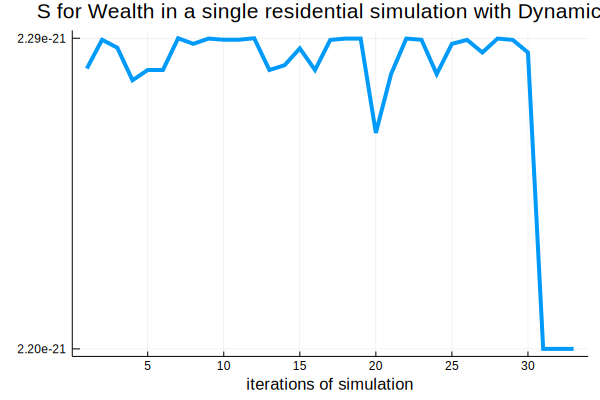

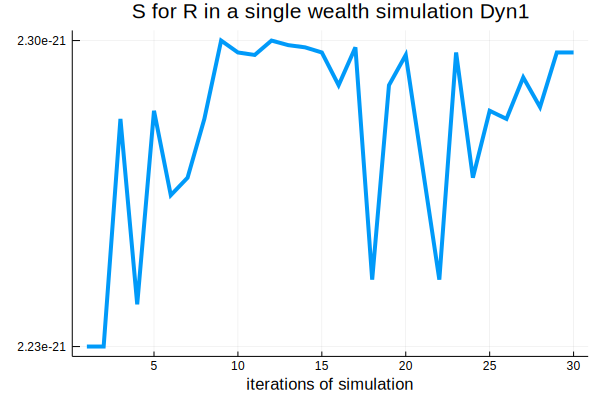

In [52]:
#now calculate the entropy traces for a single simulation

#-------------------#
#residential trace first
traceSv2 = [ S_entropy_values_from_R(Int(rr)) for rr in traceR2]

SMAX = S_entropy_values_from_R(R_MAX)
#println(minimum([traceSv2;SMAX]))
minStr = string(minimum([traceSv2;SMAX]))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(traceSv2)) )
tmp2 = string(minimum(traceSv2))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum([traceSv2;SMAX]))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(traceSv2)) )
tmp2 = string(maximum(traceSv2))[tmp:end]
labelMax = string(maxStr,tmp2)

plt5 = plot(traceSv2,
    yticks=([minimum(append!(traceSv2,SMAX)),maximum([traceSv2;SMAX])],[labelMin,labelMax]),
    ylims=(minimum(append!(traceSv2,SMAX))*(1-(10^-3)),(1 + 10^-3)*maximum(append!(traceSv2,SMAX))),
    linewidth=4,title="S for Wealth in a single residential simulation with Dynamics1",xlabel="iterations of simulation",leg=false)
#hline!([minimum([traceSv2;SMAX])],line=(3,:dash),leg=false)#SMAX)
display(plt5)
savefig(plt5,"figs/entropyRsingleTraceWealthDynamics1.png")


#------------------#
#now for the wealth trace, traceWD2

traceWDrnd2 = round.(traceWD2,digits=2)
indsEntropy2 = map(x->findfirst(x .== binsDev),traceWDrnd2)
entropyTraceW2 = entropyValsW[indsEntropy2]

SMAXW = maximum(entropyValsW)

#=function S_entropy_values_from_R(R)
    return k_b * log(sampleOmegaR[R])
       
end=#
minStr = string(minimum([entropyTraceW2;SMAXW]))[1:4] 
tmp = findfirst( isequal('e') , string(minimum([entropyTraceW2;SMAXW])) )
tmp2 = string(minimum([entropyTraceW2;SMAXW]))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum([entropyTraceW2;SMAXW]))[1:4] 
tmp = findfirst( isequal('e') , string(maximum([entropyTraceW2;SMAXW])) )
tmp2 = string(maximum([entropyTraceW2;SMAXW]))[tmp:end]
labelMax = string(maxStr,tmp2)

plt5 = plot(entropyTraceW2,
    yticks=([minimum([entropyTraceW2;SMAXW]),maximum([entropyTraceW2;SMAXW])],[labelMin,labelMax]),
    ylims=(minimum([entropyTraceW2;SMAXW])*(1-(10^-3)),(1 + 10^-3)*maximum([entropyTraceW2;SMAXW])),
    linewidth=4,title="S for R in a single wealth simulation Dyn1",xlabel="iterations of simulation",leg=false)
#hline!([maximum([entropyTraceW2;SMAXW])],line=(3,:dash),leg=false)#SMAX)
display(plt5)
savefig(plt5,"figs/entropyWsingleTraceWealthDynamics1.png")


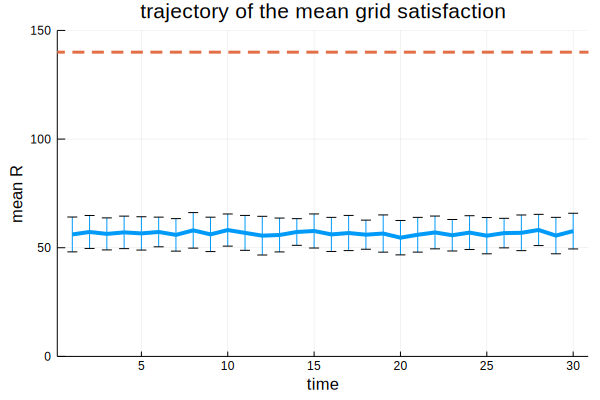

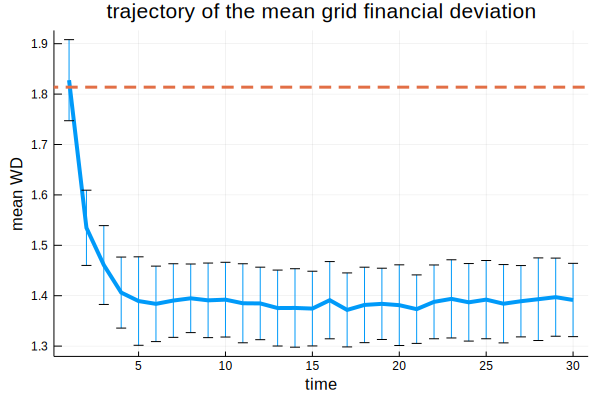

In [53]:
#now do the bulk simulation study for the financial dynamics

simulationRvals2 = zeros(TT,MM)
simulationWvals2 = zeros(TT,MM)
for mm in 1:MM        
    traceRtmp = zeros(TT)
    traceWDtmp = zeros(TT)
    for tt in 1:TT   
        #println(tt)
        if(tt==1)
            moneyGrid = make_random_finance_grid()  
        else
            moneyGrid =  move_cells_for_wealth_Dynamics1(moneyGrid) #make_random_finance_grid()  
        end    
        traceRtmp[tt] = grid_satisfaction(moneyGrid[:,:,1])
        traceWDtmp[tt] = financial_grid_deviation(moneyGrid)        
    end
    simulationRvals2[:,mm] = traceRtmp[:]
    simulationWvals2[:,mm] = traceWDtmp[:]
end

plt = plot(mean(simulationRvals2,dims=2),xlabel="time",ylabel="mean R",
    yerr=std(simulationRvals,dims=2),linewidth=4,ylim=(0,R_MAX+10),
    title="trajectory of the mean grid satisfaction") 
hline!([R_MAX],line=(3,:dash),leg=false)
display(plt)
savefig(plt,"figs/trajectoryMeanGridSatisfactionWithWealthDynamics1.png")

plt = plot(mean(simulationWvals2,dims=2),xlabel="time",ylabel="mean WD",
    yerr=std(simulationWvals,dims=2),linewidth=4,
    title="trajectory of the mean grid financial deviation",leg=false) 
#hline!([R_MAX],line=(3,:dash),leg=false)
hline!([mean(randomMoneyDeviationsData)],line=(3,:dash),leg=false)
#hline!([mean(randomMoneyDeviationsUniform)],line=(3,:dash),leg=false)
display(plt)

savefig(plt,"figs/meanTrajFinancialDeviationDynamics1.png")


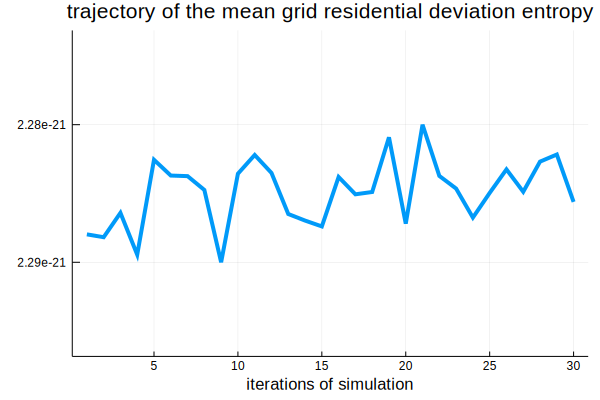

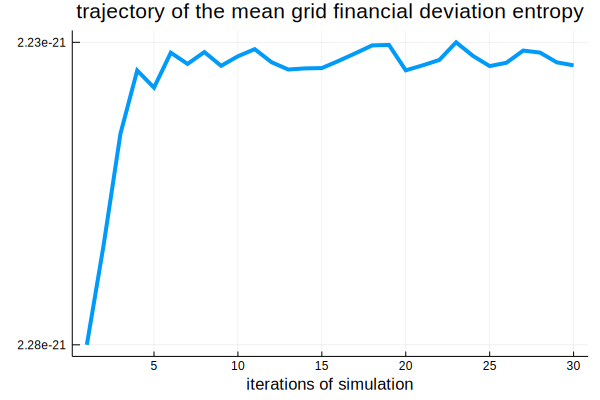

In [54]:
#now the wealth and spatial deviations from a batch simulation with Dynamics1

simulationRvals1 = zeros(TT,MM)
simulationWvals1 = zeros(TT,MM)

for mm in 1:MM        
    traceR = zeros(TT)
    traceWD = zeros(TT)
    for tt in 1:TT   
        #println(tt)
        if(tt==1)
            moneyGrid = make_random_finance_grid()  
        else
            moneyGrid =  move_cells_for_wealth_Dynamics1(moneyGrid) #make_random_finance_grid()  
        end   
        traceR[tt] = grid_satisfaction(moneyGrid[:,:,1])
        traceWD[tt] = financial_grid_deviation(moneyGrid)        
    end
    simulationRvals1[:,mm] = traceR[:]
    simulationWvals1[:,mm] = traceWD[:]
end

simulationRvalsEntropy1 = zeros(TT,MM)
simulationWvalsEntropy1 = zeros(TT,MM)

function entropyTraceWDhelper(wdArray)
    traceWDrnd = round.(wdArray,digits=2)
    indsEntropy = map(x->findfirst(x .== binsDev),traceWDrnd)
    entropyTraceW = entropyValsW[indsEntropy]
    return entropyTraceW
end

function labelMaxMinEntropy(trace)
    minStr = string(minimum(trace))[1:4] 
    tmp = findfirst( isequal('e') , string(minimum(trace)) )
    tmp2 = string(minimum(trace))[tmp:end]
    labelMin = string(minStr,tmp2)
    maxStr = string(maximum(trace))[1:4] 
    tmp = findfirst( isequal('e') , string(maximum(trace)) )
    tmp2 = string(maximum(trace))[tmp:end]
    labelMax = string(maxStr,tmp2)
    return labelMax,labelMin
end

for i in 1:TT
    for j in 1:MM       
        simulationRvalsEntropy1[i,j] = S_entropy_values_from_R(Int(simulationRvals1[i,j] ))
        simulationWvalsEntropy1[i,j] = entropyTraceWDhelper(simulationWvals1[i,j])
    end
end


tmp = labelMaxMinEntropy(mean(simulationRvalsEntropy1,dims=2))
labelMin,labelMax = tmp[1],tmp[2]
plt5 = plot(mean(simulationRvalsEntropy1,dims=2),
    yticks=([minimum(mean(simulationRvalsEntropy1,dims=2)),maximum(mean(simulationRvalsEntropy1,dims=2))],
        [labelMin,labelMax]),#yerr=std(simulationRvalsEntropy1,dims=2),
    ylims=(minimum(mean(simulationRvalsEntropy1,dims=2))*(1-(10^-3)),(1 + 10^-3)*maximum(mean(simulationRvalsEntropy1,dims=2))),
    linewidth=4,title="trajectory of the mean grid residential deviation entropy",xlabel="iterations of simulation",leg=false)
display(plt5)
savefig(plt5,"figs/trajectoryMeanGridSatisfactionResidencyEntropy1.png")

tmp = labelMaxMinEntropy(mean(simulationWvalsEntropy1,dims=2))
labelMin,labelMax = tmp[1],tmp[2]
plt5 = plot(mean(simulationWvalsEntropy1,dims=2),
    yticks=([minimum(mean(simulationWvalsEntropy1,dims=2)),maximum(mean(simulationWvalsEntropy1,dims=2))],
        [labelMin,labelMax]),#yerr=std(simulationWvalsEntropy1,dims=2),
        ylims=(minimum(mean(simulationWvalsEntropy1,dims=2))*(1-(10^-3)),(1 + 10^-3)*maximum(mean(simulationWvalsEntropy1,dims=2))),
    linewidth=4,title="trajectory of the mean grid financial deviation entropy",xlabel="iterations of simulation",leg=false)
display(plt5)
savefig(plt5,"figs/meanTrajFinancialDeviationEntropy1.png")




In [55]:
#-----------------------------------------------#
#-------------NOW FOR BOTH THE DYNAMICS OF WEALTH AND RESIDENTIAL--------#


In [56]:
#we need the movement dynamics to operate according to the schelling and also perform radial dispersion
#we have for no dynamics / schelling no wealth / wealth no schelling > need schelling and wealth
#then the sampling of the entropy of the states will have to be different, it will have to be a contour plot
#the x being the R satisfaction and the y being the wealth deviation


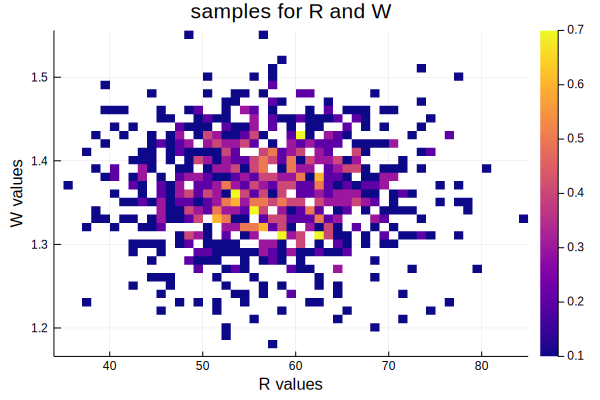

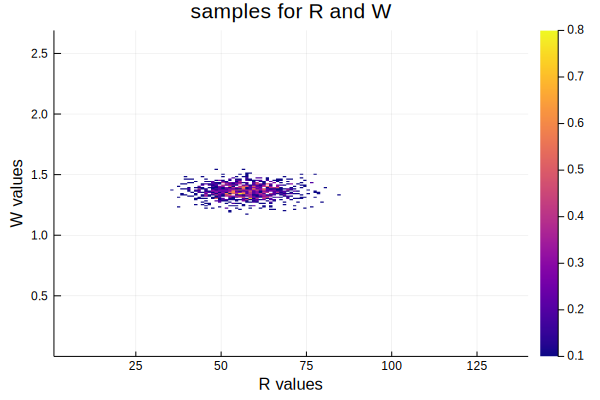

In [70]:
#2D sample space simulation
sampleNum2D = 1000

samplesR3 = zeros(sampleNum2D)
samplesWD3 = zeros(sampleNum2D)

for ii in 1:sampleNum2D
    gridII = make_uniform_sampled_finance_grid()
    #gridII = make_random_finance_grid()
    samplesR3[ii] = grid_satisfaction(gridII[:,:,1])
    samplesWD3[ii] = financial_grid_deviation(gridII)
    
    
end

hist2D = histogram2d(samplesR3,samplesWD3,title="samples for R and W",fc=:plasma,
    xlabel="R values",ylabel="W values",  normed=true,
    bins=(minimum(samplesR3)-1:1:maximum(samplesR3)+1,
        minimum(samplesWD3)-SEPBIN:SEPBIN:maximum(samplesWD3)+SEPBIN) )
display(hist2D)
savefig(hist2D,"figs/hist2DsamplesRandW.png")

hist2D = histogram2d(samplesR3,samplesWD3,title="samples for R and W",fc=:plasma,
    xlabel="R values",ylabel="W values",  normed=true,
    bins=(1:1:R_MAX,
        minimum(binsDev):SEPBIN:maximum(binsDev)) )
display(hist2D)
savefig(hist2D,"figs/hist2DsamplesRandWfullDomain.png")

In [58]:
#from the counts calculate the entropy for the 2D positions as a coordinate
#entorpy of 2D




In [59]:
simulationRvals1 = zeros(TT,MM)
simulationWvals1 = zeros(TT,MM)

for mm in 1:MM        
    traceR = zeros(TT)
    traceWD = zeros(TT)
    for tt in 1:TT   
        #println(tt)
        if(tt==1)
            moneyGrid = make_random_finance_grid()  
        else
            moneyGrid =  move_cells_for_wealth_Dynamics1(moneyGrid) #make_random_finance_grid()  
        end   
        traceR[tt] = grid_satisfaction(moneyGrid[:,:,1])
        traceWD[tt] = financial_grid_deviation(moneyGrid)        
    end
    simulationRvals1[:,mm] = traceR[:]
    simulationWvals1[:,mm] = traceWD[:]
end

simulationRvalsEntropy1 = zeros(TT,MM)
simulationWvalsEntropy1 = zeros(TT,MM)


30×100 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [60]:



function move_cells_for_satisfactionDynamics2(grid)
    
    newGrid = deepcopy(grid)
    nonZeroCells = findall(grid .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)
    satisfiedNonZeroCells = [is_cell_satisfied(newGrid,nzc[1],nzc[2]) for nzc in nonZeroCells2]    
    #R_START = grid_satisfaction(grid)

    #remove (skip) the satisfied, don't include them in the rotation on each iteration
    satisfiedInds = findall(satisfiedNonZeroCells .== 1)
    deleteat!(nonZeroCells2,satisfiedInds)   
    
    for nzc in nonZeroCells2        
        isCellSatisfied = is_cell_satisfied(newGrid,nzc[1],nzc[2])
        
        if(isCellSatisfied != 1)          
            emptyCells = findall(newGrid .== 0)
            emptyCells2 = shuffle(emptyCells)
            #find an empty cell nzc could move to
            moved = false
            for ec in emptyCells2                
                wouldCellBeSatisfied = would_cell_be_satisfied(newGrid,ec[1],ec[2],newGrid[nzc[1],nzc[2]] )
                if(wouldCellBeSatisfied == 1)  
                    
                    newGrid[ec[1],ec[2]] = newGrid[nzc[1],nzc[2]]
                    newGrid[nzc[1],nzc[2]] = 0  
                    #no longer try to move it
                    moved = true
                    break
                end                
            end   
            #=if(moved == false)
                println("cell at i=$(nzc[1]) and j=$(nzc[2]) did not move")
            end=#
        end       
    end
    
    return newGrid
end

newGrid = move_cells_for_satisfaction(start_grid)

satisfiedOneGrid = grid_satisfaction(newGrid)
#println(satisfiedOneGrid)
h3 = heatmap(newGrid,title="new allocation of residents R=$(satisfiedOneGrid)",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))

moneyGrid2 = make_random_finance_grid()

function move_cells_for_wealth_Dynamics1(grid)
    #grid = deepcopy(gridOrig)     
    nonZeroCells = findall(grid[:,:,1] .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)            
    for nzc in nonZeroCells2 
        emptyCells = findall(grid[:,:,1] .== 0)
        emptyCells2 = shuffle(emptyCells)
        ec = emptyCells2[1]
       
        grid[ec[1],ec[2],1] = grid[nzc[1],nzc[2],1]
        grid[nzc[1],nzc[2],1] = 0             
           
        grid[ec[1],ec[2],2] = grid[nzc[1],nzc[2],2]
        grid[nzc[1],nzc[2],2] = 0 
        
        #RADIATE THE FINANCE randomly on the surroundings of the 'ec' which was empty but now nzc (nonzero)
                
        cell_surround_radiate_financialRandomUniform(grid,ec[1],ec[2]) 
                
    end          
    #println(g2[:,:,1] == newGrid2[:,:,1])
    return grid
end
move_cells_for_wealth_Dynamics1(moneyGrid2)
println(sum(moneyGrid2))


2.0


In [61]:
#-------------------------------------------------------#



In [62]:

#savefig(hm,"figs/simulationSnapShots1/time$(tt).png")




#for the sampling of the composite dynamics entropy states

#wealthSamples = [randUniformWealthBracketSample() for i in 1:10]

function make_uniform_sampled_finance_grid2()    
    empty_grid = zeros(GRID_SIZE,GRID_SIZE,2)
    shiftsTmp = GRID_SIZE^2;
    #in the finance grid we store both the type of agent and the financial part
    yellowUniformSample = [randUniformWealthBracketSample() for i in 1:yellow_count]
    blueUniformSample = [randUniformWealthBracketSample() for i in 1:blue_count]

    NORMED = true

    if(NORMED == true)
        wealthSamplesYellowUniformSampled = yellowUniformSample ./ sum(yellowUniformSample)
        wealthSamplesBlueUniformSampled = blueUniformSample ./ sum(blueUniformSample)
        println(wealthSamplesBlueUniformSampled)
    else
        wealthSamplesYellowUniformSampled = yellowUniformSample #./ sum(yellowUniformSample)
        wealthSamplesBlueUniformSampled = blueUniformSample# ./ sum(blueUniformSample)
    end
    
    #set the agent occupations in the lattice
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    #set the financial values for the agents
    empty_grid[1+shiftsTmp:yellow_count+shiftsTmp] .= wealthSamplesYellowUniformSampled
    empty_grid[yellow_count+1+shiftsTmp:yellow_count+blue_count+shiftsTmp] .= wealthSamplesBlueUniformSampled
    
    empty_grid[:,:,1] = shuffle(empty_grid[:,:,1])
    empty_grid[:,:,2] = shuffle(empty_grid[:,:,2])
    return empty_grid
end


moneyGridUniformSampled2 = make_uniform_sampled_finance_grid2();


[0.0121865, 0.000693199, 0.00825832, 0.0165011, 0.0255485, 0.00688768, 0.0229263, 0.0135942, 0.0214843, 0.0103894, 0.029211, 0.0260152, 0.00705549, 0.0287933, 0.0291756, 0.024448, 0.0177423, 0.00843145, 0.00821304, 0.00112297, 0.00740072, 0.0190202, 0.0110973, 0.0232382, 0.0177762, 0.00510596, 0.00946445, 0.0162728, 0.0164672, 0.0144053, 0.028601, 0.0128303, 0.00447748, 0.0219271, 0.0216468, 0.027878, 0.00239056, 0.00352537, 0.00978001, 0.0236434, 0.00419355, 0.00904082, 0.0213878, 0.00110321, 2.25925e-5, 0.0106545, 0.00552063, 0.00525444, 0.0289207, 0.0265157, 0.0249524, 0.0221911, 0.0280515, 0.00027482, 0.0142162, 0.0173749, 0.000769483, 0.018777, 0.0157751, 0.011888, 0.00859326, 0.0139353, 0.0130709, 0.00343008, 0.0291591, 0.0189424, 0.00179195, 0.0200355, 0.00407242, 0.00445873]


In [63]:

##just make a function to move the sampled agents around and see if the deviation is altered
#take the trace over time and since thre is no dynamics move one cell randomly at a time 
#but they do still radiate their money randomly and uniformly upon their destination locality
#where they end up, plot hlines for the means of the the two histograms above
#look at the results for starting with the uniform and real data to see if the deviation goes up or down...
#then do the randoml movement but people only move into areas where they have more than the median of
#the locality. and 
#on arrival disperse radially a random percentage of their wealth around them.
#check the median and mean deviations for th grid overt that time and check to see if it locks as
#if there is a point where the movement stops. 

#schelling said that the small changes in probability can have drastic effects. and that these
#preferencces can be so small that even the agents themselves the residents are not 
#aware of their biases because of the effects on the macrostate examining individuals
#may not be a viable solution. Therefore examining the macrostate and the change in the
#entropy would be a more sensitive and reslient approach. the minor amplificiations on
#the agent level can produce massive combinational changes on the macrostate.
#it also reacts quickly!

#the radial disperal at the start is benign, but afterwards the high wealth individuals
#create a block for the low to now enter like in physics for the satisfaction of new
#molecular bonds in how satisfied they will be. That is the same as 'gentrification'
 
#we get wealth samples, and sample from that for the allocations and then the wealth on movement 
#that here is initially random that gets radially distributed.
#how many random allocations of the financial units would it take to arrive at the 
#distribution of the wealth indicators
#eg, we start out with wealth sampled from the CDF, we allocate them to the residents. 
#they then move around randomly without homogeneity search
#we then do a set of random allocations of the funds to get a distribution for the variance 
#of the wealth and the skew so that we can say that the macro state variable is the variance and skew

#later we do the model that has both the homogeneity and the financial indicators and get the macrostate trajectory

#question: we need to have the purchasing to be constrained so that they cannot move forever 
#or that we can regulated it according to the size of the system.
#if tons of wealth is dropped it can go forever? or can we say that the wealth 
#movement is a relative measure? the relative measure would be more robust but the constrained version
#should also work.

In [64]:
#now to find a model that respects an increasing entropy value trace
#now to do the financial part...


#when an agent moves into a new place, they subtract the averagej from themselves
#and distribute that radially amongst the surrounding people.

#what is the accumulated gaps (disparity) ....of the wealth on the local levels..! :)
#take the min and max due to corners, then we keep that difference, and take the accumulation 
#of the total differences
#we simply compare that aggregate to the aggregates of the random initial samples...



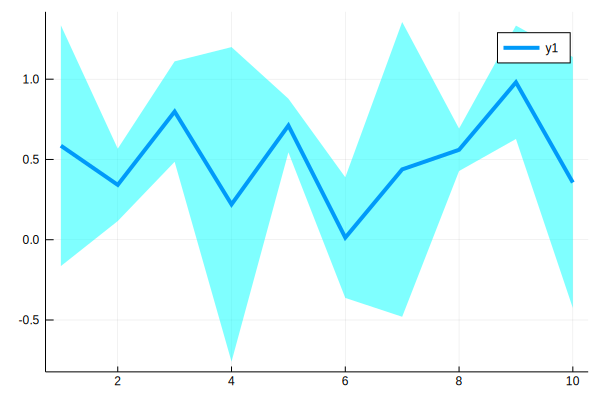

In [65]:
 plot(rand(10),ribbon=rand(10),fill=:cyan,linewidth=4)

In [66]:
function f1(x)
    x = x^2
    return x+x
end

f1 (generic function with 1 method)

In [67]:
x=3
println(f1(x))

18


$$\lambda + \beta$$
$$\frac{12}{4}$$

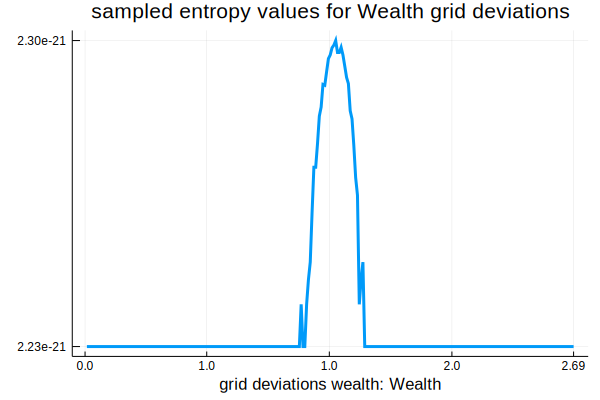

269
2.30e-212.23e-21
random grid satisfactionOLD value=92
set grid satisfactionOLD value=140


In [68]:
function randUniformWealthBracketSampleOLD()
    #row = Int(round(rand() * size(percsAndWealth)[1]))
    return rand()
end

wealthSamples = [randUniformWealthBracketSample() for i in 1:10]
#println(wealthSamples)


#in the finance grid we store both the type of agent and the financial part
yellowUniformSample = [randUniformWealthBracketSample() for i in 1:yellow_count]
blueUniformSample = [randUniformWealthBracketSample() for i in 1:blue_count]

NORMED = true

if(NORMED == true)
    wealthSamplesYellowUniformSampled = yellowUniformSample ./ sum(yellowUniformSample)
    wealthSamplesBlueUniformSampled = blueUniformSample ./ sum(blueUniformSample)
    #println(wealthSamplesBlueUniformSampled)
else
    wealthSamplesYellowUniformSampled = yellowUniformSample #./ sum(yellowUniformSample)
    wealthSamplesBlueUniformSampled = blueUniformSample# ./ sum(blueUniformSample)
end

moneyGridUniformSampled = make_uniform_sampled_finance_grid()
println(sum(moneyGridUniformSampled))


randomUniformMoneyDeviations = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealUniformMoneyDeviations = mean(randomUniformMoneyDeviations)

println("mean of the deviations for he uniform sampled= $(mean(randomUniformMoneyDeviations))")
pltHistUniform = histogram(randomUniformMoneyDeviations,leg=false,normalize=:probability,title="uniform sampled wealth deviations from cell\n and neighborhood")
vline!([mean(randomUniformMoneyDeviations)],line=(3,:dash),leg=false)


function S_entropy_values_from_WD(W)
    return k_b * log(sampleOmegaWD[W])
       
end

entropyValsW = [S_entropy_values_from_WD(W) for W in 1:length(moneyDeviationBins)]
println(length(entropyValsW))
#println((entropyValsW))

minStr = string(minimum(entropyValsW))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyValsW)) )
tmp2 = string(minimum(entropyValsW))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyValsW))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyValsW)) )
tmp2 = string(maximum(entropyValsW))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

strTmp0 = string(0*SEPBIN)
tmp0 = 0
strTmp1 = string(round( length(moneyDeviationBins)* 1/4  * SEPBIN))
tmp1 = round( length(moneyDeviationBins)* 1/4 )
strTmp2 = string(round( length(moneyDeviationBins)* 2/4  * SEPBIN))
tmp2 = length(moneyDeviationBins)* 2/4 
strTmp3 = string(round( length(moneyDeviationBins)* 3/4  * SEPBIN))
tmp3 = round( length(moneyDeviationBins)* 3/4 )
strTmp4 = string(length(moneyDeviationBins)*SEPBIN)
tmp4 = length(moneyDeviationBins)

pltSW = plot(1:length(moneyDeviationBins),entropyValsW,
    yticks=([minimum(entropyValsW),maximum(entropyValsW)],[labelMin,labelMax]),
    xticks=([0 tmp1 tmp2 tmp3 tmp4],
        [strTmp0 strTmp1 strTmp2 strTmp3 strTmp4]),
    ylim=(minimum(entropyValsW)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyValsW)),
    linewidth=3,title="sampled entropy values for Wealth grid deviations",xlabel="grid deviations wealth: Wealth",
    leg=false)
display(pltSW)
savefig(pltSW,"figs/entropyWdistribution.png")


#old code


function grid_satisfactionOLD(start_grid) 
cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            cell_surrounding = []
            if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
                for ii in 0:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
                for ii in 0:1
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==1))#top left corner
                for ii in 1:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==GRID_SIZE))#top right corner
                for ii in 1:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==1))#bottom left corner
                for ii in 0:1
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
                for ii in 1:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
                for ii in 0:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
                for ii in 0:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
                for ii in 0:1
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
        end
    end
#println(cell_satisfaction)
#println(size(cell_satisfaction))
#println(sum(cell_satisfaction))

    return sum(cell_satisfaction)
end

satisfiedOneGrid = grid_satisfactionOLD(start_grid)
println("random grid satisfactionOLD value=",satisfiedOneGrid)
R_MAX = grid_satisfactionOLD(set_grid)
println("set grid satisfactionOLD value=",R_MAX)

In [69]:
#R_MAX
#now compute the sampled distribution for the probability of the different bins
numberOfRandomSamples = 2000
randomMoneyDeviations = [ financial_grid_deviation(make_random_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealSampleMoneyDeviations = mean(randomMoneyDeviations)

println("mean of the deviations for the sampled= $(mean(randomMoneyDeviations))")
pltHist = histogram(randomMoneyDeviations,leg=false,normalize=:probability,
    bins=range(minimum(randomMoneyDeviations),stop = maximum(randomMoneyDeviations),length=R_MAX),
    title="wealth deviations from cell\n and neighborhood")
vline!([mean(randomMoneyDeviations)],line=(3,:dash),leg=false)
display(pltHist)
savefig(pltHist,"figs/RawWealthDeviationsSample.png")

#randUniformWealthBracketSample()    make_uniform_sampled_finance_grid()

randomMoneyDeviationsUG = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealSampleMoneyDeviationsUG = mean(randomMoneyDeviationsUG)
println("mean of the uniform deviations for the sampled= $(mean(randomMoneyDeviationsUG))")
pltHist = histogram(randomMoneyDeviationsUG,leg=false,normalize=:probability,
    bins=range(minimum(randomMoneyDeviationsUG),stop = maximum(randomMoneyDeviationsUG),length=R_MAX),
    title="uniform wealth deviations from cell\n and neighborhood")
vline!([mean(randomMoneyDeviationsUG)],line=(3,:dash),leg=false)
display(pltHist)
savefig(pltHist,"figs/RawWealthDeviationsSampleUG.png")

wealthSamplesYellowNormed = wealthSamplesYellow ./ sum(wealthSamplesYellow)
wealthSamplesBlueNormed = wealthSamplesBlue ./ sum(wealthSamplesBlue)

println("--yellowNormed mean--",mean(wealthSamplesYellowNormed),"--blueNormed mean--",mean(wealthSamplesBlueNormed))

println("std yellowNormed sample $(std(wealthSamplesYellowNormed))")
println("std blueNormed sample $(std(wealthSamplesBlueNormed))")
println("skewness yellowNormed sample $(skewness(wealthSamplesYellowNormed))")
println("skewness blueNormed sample $(skewness(wealthSamplesBlueNormed))")

pltHistYellowNormed = histogram(wealthSamplesYellowNormed,normalize=:probability,title="Normed wealth samples \n yellow group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesYellowNormed)],line=(4,:dash),leg=false)

pltHistBlueNormed = histogram(wealthSamplesBlueNormed,normalize=:probability,title="Normed wealth samples \n blue group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesBlueNormed)],line=(4,:dash),leg=false)

plotNormedHists = plot(pltHistYellowNormed,pltHistBlueNormed)


function randUniformWealthBracketSampleOLD()
    #row = Int(round(rand() * size(percsAndWealth)[1]))
    return rand()
end

function financial_cell_deviationOLD(gridFull,cellSurroundArray,row,col)
    cellFinance = gridFull[row,col,2]
    if(cellFinance == 0)
        return 0
    end       
    deviation = mad(cellSurroundArray,center=cellFinance,normalize=false)
    return deviation
end
g = (make_uniform_sampled_finance_grid())
gO = deepcopy(g)
g1 = [(g[i,j,2]) for i in 1:3 for j in 1:3];
println(sum(gO[:,:,2]))
tmp = cell_surround_radiate_financialRandomUniformNew(g,1,1)
t1 = [(tmp[i,j,2]) for i in 1:3 for j in 1:3];
println(sum(tmp[:,:,2]))
for i in 1:4
    for j in 1:4
    println("i=$(i) j=$(j) gO=$(gO[i,j,2]) tmp=$(tmp[i,j,2]), spatial g0==$(gO[i,j,1]) tmp=$(tmp[i,j,1])")
    end
end
#Plot 2D visualization of a trace random dynamics UNIFORM DATA

heatmapPaddingR = 10

xrange = Int(maximum(traceR) - minimum(traceR)) + 1 #+ 2*heatmapPaddingR
yrange = length(minimum(traceI) : 10000 : maximum(traceI))
uniform2DsampleInitializations = ones(xrange,yrange)

println(traceR)
println(traceI)
for k in keys(countsDict)        
    rShift = k[1] - Int(minimum(traceR)) + 1
    iShift = Int(k[2]/roundBy) - Int(minimum(traceI)/roundBy) + 1 

    uniform2DsampleInitializations[rShift,iShift] += countsDict[k]
    #println(rShift," ",iShift)
end

println(xrange)
println(yrange)
xrangeTicks = 1:xrange
h = heatmap(uniform2DsampleInitializations,title="density of R and I initial samples Uniform",
        showaxis=true,xticks=true,#    yticks=(yt,yt2 .* "!"),#(collect(minimum(traceI) : 10000 : maximum(traceI))),
    xlabel="R",ylabel="I",#xlims=(0.5,xrange+0.5),
    xtickfont=10,ytickfont=10,titlefont=14,guidefont=12)
display(h)  
savefig(h,newFigNameString())

#=
moneyGrid2 = move_cells_for_wealth_NoDynamics(moneyGrid)

println("---")
println("number of empty resident cells=",length(findall(moneyGrid2[:,:,1] .== 0)))
println("nmber of empty finance cells=",length(findall(moneyGrid2[:,:,2] .== 0)))
println("sum of total finance on finance cells=",sum(moneyGrid2[:,:,2]) )  
println("grid the same as before for residential=",moneyGrid2[:,:,1] == moneyGrid[:,:,1])
println("grid the same as before for finance=",moneyGrid2[:,:,2] == moneyGrid[:,:,2])
println("financial grid deviation=",financial_grid_deviation(moneyGrid))
println("financial grid2 deviation=",financial_grid_deviation(moneyGrid2))
println("grid2 satisfaction=",grid_satisfaction(moneyGrid2[:,:,1]))
println("---")

wdevTmp = round(financial_grid_deviation(moneyGrid2),digits=2)    
Rtmp = grid_satisfaction(moneyGrid2[:,:,1])
hm = heatmap(moneyGrid2[:,:,2],title="cell wealth \n deviation=$(wdevTmp)",
showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,
    framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=true,
c=ColorGradient([:red,:white]))
hm2 = heatmap(moneyGrid2[:,:,1],title="cell identity label \n R=$(Rtmp)",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))

p2=plot(hm,hm2)
display(p2)
#savefig(hm,"figs/simulationSnapShots1/time$(tt).png")
=#
#find neighbor number
    #=cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                if(grid[row-1+(ii),(col-1)+(jj)] != 0) 
                    append!(cell_surrounding,abs(grid[row-1+(ii),(col-1)+(jj)]))              
                end
            end
        end
    end=#